## Estimate weight of long range edges using appropriate penalizations for likelihoods

### Two models: 
1. instantantenous admixture (akin to TreeMix/SpaceMix model) - assume a single long range edge from $s$ to $d$ with some shared portion of the genome $c$. So, then $L^{\dagger_n}_{s,d} = (1-c) \times L^{\dagger_o}_{s,d} + c \times L^{\dagger_o}_{s,s}$

In [ ]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import pandas as pd
import multiprocessing as mp
from scipy.stats.distributions import chi2
import scipy as sp
from joblib import Parallel, delayed

# viz
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import seaborn as sns

# feems
import sys
sys.path.append('../../')
from feems import SpatialGraph, Viz, Objective
from feems.joint_ver import FEEMSmix_SpatialGraph, FEEMSmix_Objective, loss_wrapper
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes, simulate_genotypes_w_admixture
from feems.spatial_graph import query_node_attributes
from feems.objective import comp_mats
from feems.cross_validation import run_cv, run_cvq, run_cv_joint
from feems.helper_funcs import * 

# popgen
# import msprime
# import tskit
import allel

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})
plt.rcParams['axes.axisbelow'] = True
plt.style.use('bmh')
rng = np.random.default_rng(2022)

## Creating a function to calculate Wishart likelihood from a matrix of pairwise resistance distances 

Easier to model $R$ as as function of admixture proportion $c$ instead of modeling $L^\dagger$ as a function of $c$ 

In [76]:
def get_FEEMS_demes_ll_w_c(sp_graph, obj, lrn, c, df=100, sigstar=1):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag
    
    ## sd
    ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, df, -sigstar/df*C @ resmat @ C.T), sp.stats.linregress(np.ravel(2*C @ sp_graph.S @ C.T), np.ravel(-C @ resmat @ C.T))[2]**2
    # return sp.stats.wishart.logpdf(-C @ resmat @ C.T, df, 2*C @ sp_graph.S @ C.T) 

def get_FEEMS_demes_nll_w_c(c, sp_graph, obj, lrn, form='element'):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T
    
    o = sp_graph.n_observed_nodes

    Rmat = -2*obj.Linv[:o,:o] + np.broadcast_to(np.diag(obj.Linv),(o,o)).T + np.broadcast_to(np.diag(obj.Linv),(o,o)) #np.reshape(np.diag(obj.Linv[:o,:o]),(-1,1)) @ np.ones((1,sp_graph.n_observed_nodes)) + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1))
    Q1mat = np.broadcast_to(sp_graph.q_inv_diag.diagonal(),(o,o)) #np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag     

    if(form!='matrix'):
        ##-----------------using the element-wise formulation----------------------##
        ## sd
        ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    else:
        ##-----------------using the matrix formulation----------------------##
        BR1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); BR2 = np.zeros_like(BR1); BR3 = np.zeros_like(BR1);

        ## sd
        BR1[lrn[0][0],lrn[0][1]] = 0.5*c**2-1.5*c+1
        BR1[lrn[0][1],lrn[0][0]] = BR1[lrn[0][0],lrn[0][1]]
        ## id
        for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            #id
            BR1[i,lrn[0][1]] = 1-c
            BR1[lrn[0][1],i] = BR1[i,lrn[0][1]]
            # sd
            BR2[i,lrn[0][1]] = c
            BR2[lrn[0][1],i] = BR2[i,lrn[0][1]]
            # is
            BR3[i,lrn[0][1]] = 0.5*(c**2-c)
            BR3[lrn[0][1],i] = BR3[i,lrn[0][1]]

        BQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

        BQ1[lrn[0][0],lrn[0][1]] = 1+c
        BQ1[lrn[0][1],lrn[0][0]] = 1-c

        Rismat = np.zeros_like(Rmat); Rsdmat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat); Qidmat = np.zeros_like(Rmat)
        for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
            Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

            Rsdmat[i,lrn[0][1]] = Rmat[lrn[0][0],lrn[0][1]]
            Rsdmat[lrn[0][1],i] = Rsdmat[i,lrn[0][1]]

            Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
            Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

            Qidmat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][1]]
            Qidmat[lrn[0][1],i] = Qidmat[i,lrn[0][1]]

        resmat = np.multiply(BR1,Rmat) + np.multiply(BR3,Rsdmat) + np.multiply(BQ1,Q1mat) + np.multiply(Q1mat.T,BQ1.T) + np.multiply(BR2,Rismat+Qismat-Qidmat) - 2*np.diag(1/sp_graph.q)

    # return resmat
    D = np.ones(sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(sp_graph.S).reshape(1,-1) + np.diag(sp_graph.S).reshape(-1,1) @ np.ones(sp_graph.n_observed_nodes).reshape(1,-1) - 2*sp_graph.S
    # plt.plot((-C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)].T,(-sp_graph.n_snps*C@D@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.ylabel(r'$-pC\hat D C^\top$'); plt.xlabel(r'$-C\Delta C^\top$'); 
    # plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot((-C@resmat@C.T)[:,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[:,lrn[0][1]-1],'g*',label='id'); 
    # plt.plot((-C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[lrn[0][1]-1,lrn[0][1]-1],'r.',label='dd'); plt.legend(); 
    # plt.title(r'$c=${}, $\tau=${}, $\ell=${}, $R^2=${}'.format(c,tau,round(-sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -C @ resmat @ C.T),2),round(sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2],5))); plt.box(False)
    # return -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)
    return -sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)

In [2]:
## writing code to pass in gradient wrt c (using scipy.optimize.minimize)
## this is basic code to check if the analytical derivative was found correctly and if I can code it up correctly 
def get_grad_FEEMS_demes_nll_w_c(c, opts):
    sp_graph = opts['sp_graph']; lrn = opts['lrn']

    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*opts['obj'].Linv + np.reshape(np.diag(opts['obj'].Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(opts['obj'].Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag
    BR1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); BR2 = np.zeros_like(BR1); BR3 = np.zeros_like(BR1);

    ## sd
    BR1[lrn[0][0],lrn[0][1]] = 0.5*c**2-1.5*c+1
    BR1[lrn[0][1],lrn[0][0]] = BR1[lrn[0][0],lrn[0][1]]
    ## id
    for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        #id
        BR1[i,lrn[0][1]] = 1-c
        BR1[lrn[0][1],i] = BR1[i,lrn[0][1]]
        # sd
        BR2[i,lrn[0][1]] = c
        BR2[lrn[0][1],i] = BR2[i,lrn[0][1]]
        # is
        BR3[i,lrn[0][1]] = 0.5*(c**2-c)
        BR3[lrn[0][1],i] = BR3[i,lrn[0][1]]

    BQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); #BQ2 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

    BQ1[lrn[0][0],lrn[0][1]] = 1+c
    BQ1[lrn[0][1],lrn[0][0]] = 1-c

    Rismat = np.zeros_like(Rmat); Rsdmat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat); Qidmat = np.zeros_like(Rmat)
    for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
        Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

        Rsdmat[i,lrn[0][1]] = Rmat[lrn[0][0],lrn[0][1]]
        Rsdmat[lrn[0][1],i] = Rsdmat[i,lrn[0][1]]

        Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
        Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

        Qidmat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][1]]
        Qidmat[lrn[0][1],i] = Qidmat[i,lrn[0][1]]

    resmat = -0.5*(np.multiply(BR1,Rmat) + np.multiply(BR3,Rsdmat) + np.multiply(BQ1,Q1mat) + np.multiply(Q1mat.T,BQ1.T) + np.multiply(BR2,Rismat+Qismat-Qidmat) - 2*np.diag(1/sp_graph.q))

    ## construct derivative vectors
    ## using version from FEEMS appendix
    delldsig = sp_graph.n_snps * (C.T@(np.linalg.inv(C@resmat@C.T)@(C@sp_graph.S@C.T)@np.linalg.inv(C@resmat@C.T)-np.linalg.inv(C@resmat@C.T))@C).reshape(1,-1)
    
    dsigdc = np.zeros((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes))
    dsigdc[lrn[0][0],lrn[0][1]] = (c-1.5)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[lrn[0][0]] - 1/sp_graph.q[lrn[0][1]]
    dsigdc[lrn[0][1],lrn[0][0]] = dsigdc[lrn[0][0],lrn[0][1]]
    for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        dsigdc[i,lrn[0][1]] = -Rmat[i,lrn[0][1]] + Rmat[i,lrn[0][0]] + (c-0.5)*Rmat[lrn[0][0],lrn[0][1]] - 1/sp_graph.q[lrn[0][1]] + 1/sp_graph.q[lrn[0][0]]
        dsigdc[lrn[0][1],i] = dsigdc[i,lrn[0][1]]

    # dBR1 = np.zeros((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); dBR2 = np.zeros_like(dBR1); dBR3 = np.zeros_like(dBR1)
    # dBR1[lrn[0][0],lrn[0][1]] = c-1.5
    # dBR1[lrn[0][1],lrn[0][0]] = dBR1[lrn[0][0],lrn[0][1]]
    # ## id
    # for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
    #     #id
    #     dBR1[i,lrn[0][1]] = -1
    #     dBR1[lrn[0][1],i] = dBR1[i,lrn[0][1]]
    #     # sd
    #     dBR2[i,lrn[0][1]] = 1
    #     dBR2[lrn[0][1],i] = dBR2[i,lrn[0][1]]
    #     # is
    #     dBR3[i,lrn[0][1]] = c-0.5
    #     dBR3[lrn[0][1],i] = dBR3[i,lrn[0][1]]

    # dBQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

    # dBQ1[lrn[0][0],lrn[0][1]] = 1
    # dBQ1[lrn[0][1],lrn[0][0]] = -1

    # dresmat = np.multiply(dBR1,Rmat) + np.multiply(dBR3,Rsdmat) + np.multiply(dBQ1,Q1mat) + np.multiply(Q1mat.T,dBQ1.T) + np.multiply(dBR2,Rismat+Qismat-Qidmat)
    # dsigdc = dresmat.reshape(-1,1)


    return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, 1/sp_graph.n_snps*C @ resmat @ C.T)#, np.ravel(delldsig @ dsigdc.reshape(-1,1))[0]

In [3]:
def get_FEEMS_udemes_nll_w_c(c, sp_graph, obj, lrn):
    '''Here, we are modeling the admixture est. framework between an unsampled deme (1) & a sampled deme (d)'''
    # sp_graph = opts['sp_graph']; obj = opts['obj']; lrn = opts['lrn'] # (1, d, s)
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes] + np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1))
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T); resmat[np.diag_indices(sp_graph.n_observed_nodes)] = 0 #- 2*sp_graph.q_inv_diag

    # need to compute pseudo-inverse of L_{d x d}
    Lpinv = np.linalg.pinv(sp_graph.L.todense())  

    neighs = list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[lrn[0][0]]))
    ## only for sampled neighboring nodes 
    neighs = [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]

    R1d = -2*Lpinv[lrn[0][0],lrn[0][1]] + Lpinv[lrn[0][0],lrn[0][0]] + Lpinv[lrn[0][1],lrn[0][1]]

    for s in neighs:
        # convert back to appropriate indexing excluding the unsampled demes
        s = [k for k, v in nx.get_node_attributes(sp_graph,'permuted_idx').items() if v==s][0]
        resmat[s,lrn[0][1]] = Rmat[s,lrn[0][1]] + 0.5*(c**2-c)*R1d + (1-c)/sp_graph.q[s] + (1+c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],s] = resmat[s,lrn[0][1]]

    # closest sampled deme is the proxy source for the unsampled deme
    proxs = np.argmin([nx.shortest_path_length(sp_graph,source=lrn[0][0],target=d) for d in set([k for k, v in nx.get_node_attributes(sp_graph,'n_samples').items() if v>0])-set([lrn[0][0]])])
    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]+neighs):
        Ri1 = -2*Lpinv[i,lrn[0][0]] + Lpinv[i,i] + Lpinv[lrn[0][0],lrn[0][0]]
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[proxs]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)

In [535]:
def get_FEEMS_demes_nll_w_c_t(x, sp_graph, obj, lrn):
    c = x[0]; tau = x[1]#*np.median(1/sp_graph.q)
    
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes] + np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1))
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag

    #TODO: consider dividing the weights by the maximum to get it to lower levels as higher migmat means higher prob of diffusion, etc.?
    migmat = deepcopy(sp_graph.W.todense()); np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(sp_graph.n_observed_nodes).reshape(-1,1)))
    # migmat = np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist()); np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(80).reshape(-1,1)))
    probmat = sp.linalg.expm(migmat*tau)

    s = lrn[0][0]; d = lrn[0][1]

    onehot = np.zeros(sp_graph.n_observed_nodes); onehot[s] = 1
    ps = np.ravel(onehot @ probmat)

    onehot[s] = 0; onehot[d] = 1
    pd = np.ravel(onehot @ probmat)

    # for i in range(0,sp_graph.n_observed_nodes):
    #     for j in range(i+1,sp_graph.n_observed_nodes):
    #         resmat[i,j] = Rmat[i,s] * (ps[j] - ps[i]*ps[j] - pd[i]*ps[j] - c*ps[i]*pd[j] - c*pd[i]*pd[j] + c*pd[j] \
    #                                 - 0.5*c*pd[i] - 0.5*ps[i] + 0.5*c*pd[i]**2 + 0.5*ps[i]**2 + 0.5*pd[i]*ps[i] + 0.5*c*pd[i]*ps[i]) + \
    #                     Rmat[j,s] * (ps[i] + c*pd[i] - c*pd[i]*pd[j] - ps[i]*pd[j] - c*pd[i]*ps[j] - ps[i]*ps[j] \
    #                                 - 0.5*c*pd[j] - 0.5*ps[j] + 0.5*c*pd[j]**2 + 0.5*ps[j]**2 + 0.5*pd[j]*ps[j] + 0.5*c*pd[j]*ps[j]) + \
    #                     Rmat[s,d] * (pd[i]*ps[j] - c*pd[i]*ps[j] + ps[i]*pd[j] - c*ps[i]*pd[j] + 2*c*pd[i]*pd[j] - 2*c**2*pd[i]*pd[j] \
    #                                 - 0.5*pd[i]*ps[i] + 0.5*s*pd[i]*ps[i] - 0.5*c*pd[i]**2 + 0.5*c**2*pd[i]**2 - 0.5*pd[j]*ps[j] \
    #                                 + 0.5*c*pd[j]*ps[j] - 0.5*c*pd[j]**2 + 0.5*c**2*pd[j]**2) + \
    #                     Rmat[i,d] * (c*ps[i]*pd[j] - ps[i]*pd[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[j] - c*pd[j] \
    #                                 - 0.5*c*pd[i]*ps[i] + 0.5*pd[i]*ps[i] - 0.5*c*pd[i]**2 + 0.5*pd[i]**2 - 0.5*pd[i] + 0.5*c*pd[i]) + \
    #                     Rmat[j,d] * (c*pd[i]*ps[j] - pd[i]*ps[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[i] - c*pd[i] \
    #                                 - 0.5*c*pd[j]*ps[j] + 0.5*pd[j]*ps[j] - 0.5*c*pd[j]**2 + 0.5*pd[j]**2 - 0.5*pd[j] + 0.5*c*pd[j]) + \
    #                     Rmat[i,j] * (ps[i]*ps[j] + pd[i]*ps[j] - ps[j] + ps[i]*pd[j] + pd[i]*pd[j] - pd[j] - ps[i] - pd[i] + 1) + \
    #                     (ps[i] + ps[j] + c*pd[i] + c*pd[j])/sp_graph.q[s] + \
    #                     ((1-c)*pd[i] + (1-c)*pd[j])/sp_graph.q[d] + \
    #                     (1 - ps[i] - pd[i])/sp_graph.q[i] + (1 - ps[j] - pd[j])/sp_graph.q[j] + 2*tau
    #         resmat[j,i] = resmat[i,j]

    for i in range(0,sp_graph.n_observed_nodes):
        for j in range(i+1,sp_graph.n_observed_nodes):
            pid = pd[i]; pjd = pd[j]
            pis = ps[i]; pjs = ps[j]
            resmat[i,j] = (1.*pid - 1.*c*pid + 1.*pjd - 1.*c*pjd)/sp_graph.q[d] + (1. - 1.*pid - 1.*pis)/sp_graph.q[i] + \
                (1. + pid - 2.*pis**2 - 2.*pjd - pid*pjd + 1.*pjd**2 - 1.*pjs - pid*pjs + 2.*pis*pjs + 1.*pjd*pjs)/sp_graph.q[j] + \
                (1.*c*pid + 1.*pis - 2.*pis**2 + 1.*c*pjd + 1.*pjs + 2.*pis*pjs)/sp_graph.q[s] + \
                (-0.5*pid + 0.5*c*pid + 0.5*pid**2 - 0.5*c*pid**2 + 0.5*pid*pis - 0.5*c*pid*pis + 1.*pjd - 1.*c*pjd - 1.*pid*pjd + 1.*c*pid*pjd - 1.*pis*pjd + 1.*c*pis*pjd)*Rmat[i,d] + \
                (1. - 1.*pid - 1.*pis - 1.*pjd + 1.*pid*pjd + 1.*pis*pjd - 1.*pjs + 1.*pid*pjs + 1.*pis*pjs)*Rmat[i,j] + \
                (-0.5*c*pid + 0.5*c*pid**2 - 0.5*pis + 0.5*pid*pis + 0.5*c*pid*pis + 0.5*pis**2 + 1.*c*pjd - 1.*c*pid*pjd - 1.*c*pis*pjd + 1.*pjs - 1.*pid*pjs - 1.*pis*pjs)*Rmat[i,s] + \
                (1.*pid - 1.*c*pid - 0.5*pjd + 0.5*c*pjd - 1.*pid*pjd + 1.*c*pid*pjd + 0.5*pjd**2 - 0.5*c*pjd**2 - 1.*pid*pjs + 1.*c*pid*pjs + 0.5*pjd*pjs - 0.5*c*pjd*pjs)*Rmat[j,d] + \
                (1.*c*pid + 1.*pis - 1.*pis**2 - 0.5*c*pjd - 1.*c*pid*pjd - 1.*pis*pjd + 0.5*c*pjd**2 - 0.5*pjs - 1.*c*pid*pjs + 0.5*pjd*pjs + 0.5*c*pjd*pjs + 0.5*pjs**2)*Rmat[j,s] + \
                (-0.5*c*pid**2 + 0.5*c**2*pid**2 - 0.5*pid*pis + 0.5*c*pid*pis + 2.*c*pid*pjd - 2.*c**2*pid*pjd + 1.*pis*pjd - 1.*c*pis*pjd - 0.5*c*pjd**2 + 0.5*c**2*pjd**2 + 1.*pid*pjs - 1.*c*pid*pjs - 0.5*pjd*pjs + 0.5*c*pjd*pjs)*Rmat[s,d] + \
                4*tau + 2*pid*tau - 8*pis**2*tau - 2*pjd*tau - 2*pid*pjd*tau + 2*pjd**2*tau - 2*pid*pjs*tau + 8*pis*pjs*tau + 2*pjd*pjs*tau
            resmat[j,i] = resmat[i,j]

    # for i in range(0,sp_graph.n_observed_nodes):
    #     for j in range(i,sp_graph.n_observed_nodes):
    #         pid = pd[i]; pjd = pd[j]
    #         pis = ps[i]; pjs = ps[j]
    #         resmat[i,j] = (1.*pid-1.*c*pid+1.*pjd-1.*c*pjd)*1/sp_graph.q[d]+(1.-1.*pid-1.5*pis-0.5*pid*pjd+0.5*pjd**2+0.5*pjs-0.5*pid*pjs+0.5*pjd*pjs)*1/sp_graph.q[i]+(1.+1.*pid+0.5*pis-2.*pis**2-2.*pjd-0.5*pid*pjd+0.5*pjd**2-1.5*pjs-0.5*pid*pjs+2.*pis*pjs+0.5*pjd*pjs)*1/sp_graph.q[j]+(1.*c*pid+1.*pis-2.*pis**2+1.*c*pjd+1.*pjs+2.*pis*pjs)*1/sp_graph.q[s]+(-0.25*pid+0.25*c*pid+0.25*pid**2-0.25*c*pid**2+0.25*pid*pis-0.25*c*pid*pis+0.75*pjd-0.75*c*pjd-1.*pid*pjd+1.*c*pid*pjd-1.*pis*pjd+1.*c*pis*pjd+0.25*pjd**2-0.25*c*pjd**2+0.25*pjd*pjs-0.25*c*pjd*pjs)*Rmat[i,d]+(0.5-0.25*pid-0.25*pid**2-0.5*pis-0.5*pid*pis-0.25*pis**2-0.75*pjd+0.75*pid*pjd+1.*pis*pjd-0.5*pjs+0.75*pid*pjs+1.*pis*pjs-0.25*pjd*pjs-0.25*pjs**2)*Rmat[i,j]+(-0.25*c*pid+0.25*c*pid**2-0.25*pis+0.25*pid*pis+0.25*c*pid*pis+0.25*pis**2+0.75*c*pjd-1.*c*pid*pjd-1.*c*pis*pjd+0.25*c*pjd**2+0.75*pjs-1.*pid*pjs-1.*pis*pjs+0.25*pjd*pjs+0.25*c*pjd*pjs+0.25*pjs**2)*Rmat[i,s]+(0.75*pid-0.75*c*pid+0.25*pid**2-0.25*c*pid**2+0.25*pid*pis-0.25*c*pid*pis-0.25*pjd+0.25*c*pjd-1.*pid*pjd+1.*c*pid*pjd+0.25*pjd**2-0.25*c*pjd**2-1.*pid*pjs+1.*c*pid*pjs+0.25*pjd*pjs-0.25*c*pjd*pjs)*Rmat[j,d]+(0.75*c*pid+0.25*c*pid**2+0.75*pis+0.25*pid*pis+0.25*c*pid*pis-0.75*pis**2-0.25*c*pjd-1.*c*pid*pjd-1.*pis*pjd+0.25*c*pjd**2-0.25*pjs-1.*c*pid*pjs+0.25*pjd*pjs+0.25*c*pjd*pjs+0.25*pjs**2)*Rmat[j,s]+(-0.5*c*pid**2+0.5*c**2*pid**2-0.5*pid*pis+0.5*c*pid*pis+2.*c*pid*pjd-2.*c**2*pid*pjd+1.*pis*pjd-1.*c*pis*pjd-0.5*c*pjd**2+0.5*c**2*pjd**2+1.*pid*pjs-1.*c*pid*pjs-0.5*pjd*pjs+0.5*c*pjd*pjs)*Rmat[s,d] + 4*tau+10*pid*tau+8*pis*tau-8*pis**2*tau+6*pjd*tau-10*pid*pjd*tau-8*pis*pjd*tau+2*pjd**2*tau+8*pjs*tau-10*pid*pjs*tau+2*pjd*pjs*tau
    #         resmat[j,i] = resmat[i,j]

    resmat += np.diag(np.repeat(tau,sp_graph.n_observed_nodes))
    # resmat += np.diag(1/sp_graph.q+2*tau)

    # D = squareform(pdist(sp_graph.frequencies*np.sqrt(sp_graph.mu*(1-sp_graph.mu)),"sqeuclidean"))/1000
    D = np.ones(sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(sp_graph.S).reshape(1,-1) + np.diag(sp_graph.S).reshape(-1,1) @ np.ones(sp_graph.n_observed_nodes).reshape(1,-1) - 2*sp_graph.S

    plt.plot((-C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)].T,(-sp_graph.n_snps*C@D@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.ylabel(r'$-pC\hat D C^\top$'); plt.xlabel(r'$-C\Delta C^\top$'); 
    plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot((-C@resmat@C.T)[:,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[:,lrn[0][1]-1],'g*',label='id'); 
    plt.plot((-C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[lrn[0][1]-1,lrn[0][1]-1],'r.',label='dd'); plt.legend(); 
    plt.title(r'$c=${}, $\tau=${}, $\ell=${}, $R^2=${}'.format(c,tau,round(-sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -C @ resmat @ C.T),2),round(sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2],5))); plt.box(False)

    # return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)
    # return -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)
    # return -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T), -sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)], (2*sp_graph.n_snps*C @ sp_graph.S @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)])[2]
    return -sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)#, -sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2], -sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)])[2]  
    # tempS = 2*sp_graph.n_snps*C @ sp_graph.S @ C.T; tempS[np.diag_indices(sp_graph.n_observed_nodes-1)] = 50000

    # tempR = -C @ resmat @ C.T; tempR[np.diag_indices(sp_graph.n_observed_nodes-1)] = 500
    # return -sp.stats.wishart.logpdf(tempS, sp_graph.n_snps, tempR), -sp.stats.linregress(tempR[np.tril_indices(sp_graph.n_observed_nodes-1,-1)], tempS[np.tril_indices(sp_graph.n_observed_nodes-1,-1)])[2]

In [4]:
def get_FEEMS_hao_nll_w_c_t(x, sp_graph, obj, lrn):
    c = x[0]; tau = x[1]#*np.median(1/sp_graph.q)

    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes] + np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1))
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    # resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag

    Tstar = Rmat + (Q1mat + Q1mat.T); Tstar[np.diag_indices(sp_graph.n_observed_nodes)] = 0
    dT0 = np.zeros_like(Tstar)
    dT0[lrn[0][0],lrn[0][1]] = c*Tstar[lrn[0][0],lrn[0][0]] - c*Tstar[lrn[0][0],lrn[0][1]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 2*c/sp_graph.q[lrn[0][0]]
    dT0[lrn[0][1],lrn[0][0]] = dT0[lrn[0][0],lrn[0][1]]
    for i in list(set(range(dT0.shape[0]))-set([lrn[0][0],lrn[0][1]])):
    # for i in list(set(range(dT0.shape[0]))-set([lrn[0][1]])):
        # dT0[i,lrn[0][1]] = c*Tstar[i,lrn[0][0]] - c*Tstar[i,lrn[0][1]]; dT0[lrn[0][1],i] = dT0[i,lrn[0][1]]
        dT0[i,lrn[0][1]] = c*Tstar[i,lrn[0][0]] - c*Tstar[i,lrn[0][1]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]]; dT0[lrn[0][1],i] = dT0[i,lrn[0][1]]
    # dT0[lrn[0][1],lrn[0][1]] = c**2 * Tstar[lrn[0][0],lrn[0][0]] + 2*c*(1-c)*Tstar[lrn[0][0],lrn[0][1]] + (c**2-2*c) * Tstar[lrn[0][1],lrn[0][1]] 
    dT0[lrn[0][1],lrn[0][1]] = c*Tstar[lrn[0][0],lrn[0][0]] - c*Tstar[lrn[0][1],lrn[0][1]] 
    # plt.imshow(dT0); plt.colorbar(); plt.show()

    dTt = -tau*(np.diag(1/sp_graph.q)@np.diag(np.diag(dT0)) + obj.Linv@dT0 + dT0@obj.Linv) + dT0

    resmat = Tstar+dTt+tau
    # - np.ones((sp_graph.n_observed_nodes,1)) @ (Tstar+dTt).diagonal().reshape(1,-1) - (Tstar+dTt).diagonal().reshape(-1,1) @ np.ones((1,sp_graph.n_observed_nodes))

    # resmat -= np.diag(np.repeat(tau,sp_graph.n_observed_nodes))
    # resmat[np.diag_indices_from(resmat)] = 0.01
    # resmat += np.diag(1/sp_graph.q+2*tau)

    D = np.ones(sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(sp_graph.S).reshape(1,-1) + np.diag(sp_graph.S).reshape(-1,1) @ np.ones(sp_graph.n_observed_nodes).reshape(1,-1) - 2*sp_graph.S

    # plt.plot((-C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)].T,(-sp_graph.n_snps*C@D@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.ylabel(r'$-pC\hat D C^\top$'); plt.xlabel(r'$-C\Delta C^\top$'); 
    # plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot((-C@resmat@C.T)[:,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[:,lrn[0][1]-1],'g*',label='id'); 
    # plt.plot((-C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[lrn[0][1]-1,lrn[0][1]-1],'r.',label='dd'); plt.legend(); 
    # plt.title(r'$c=${}, $\tau=${}, $\ell=${}, $R^2=${}'.format(c,tau,round(-sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -2*C @ resmat @ C.T),2),round(sp.stats.linregress((-2*C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2],5))); plt.box(False)

    # return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)
    # return -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)
    # return -sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)], (-sp_graph.n_snps*C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)])[2] #-sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T), 
    return -sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -2*C @ resmat @ C.T)#, -sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2], -sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)])[2]  
    # tempS = 2*sp_graph.n_snps*C @ sp_graph.S @ C.T; tempS[np.diag_indices(sp_graph.n_observed_nodes-1)] = 50000

    # tempR = -C @ resmat @ C.T; tempR[np.diag_indices(sp_graph.n_observed_nodes-1)] = 500
    # return -sp.stats.wishart.logpdf(tempS, sp_graph.n_snps, tempR), -sp.stats.linregress(tempR[np.tril_indices(sp_graph.n_observed_nodes-1,-1)], tempS[np.tril_indices(sp_graph.n_observed_nodes-1,-1)])[2]

In [1612]:
def get_FEEMS_demes_nll_w_c_x(est, sp_graph, obj, lrn):
    c = est[0]; x = est[1]
    
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes] + np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1))
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag

    s = lrn[0][0]; d = lrn[0][1]

    migmat = deepcopy(sp_graph.W.todense()); np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(sp_graph.n_observed_nodes).reshape(-1,1)))
    probmat = sp.linalg.expm(migmat*(0.5*x/sp_graph.q[s]))

    onehot = np.zeros(sp_graph.n_observed_nodes); onehot[s] = 1
    ps = np.ravel(onehot @ probmat)

    onehot[s] = 0; onehot[d] = 1
    pd = np.ravel(onehot @ probmat)

    for i in range(0,sp_graph.n_observed_nodes):
        for j in range(i+1,sp_graph.n_observed_nodes):
            resmat[i,j] = Rmat[i,s] * (ps[j] - ps[i]*ps[j] - pd[i]*ps[j] - c*ps[i]*pd[j] - c*pd[i]*pd[j] + c*pd[j] \
                                    - 0.5*c*pd[i] - 0.5*ps[i] + 0.5*c*pd[i]**2 + 0.5*ps[i]**2 + 0.5*pd[i]*ps[i] + 0.5*c*pd[i]*ps[i]) + \
                        Rmat[j,s] * (ps[i] + c*pd[i] - c*pd[i]*pd[j] - ps[i]*pd[j] - c*pd[i]*ps[j] - ps[i]*ps[j] \
                                    - 0.5*c*pd[j] - 0.5*ps[j] + 0.5*c*pd[j]**2 + 0.5*ps[j]**2 + 0.5*pd[j]*ps[j] + 0.5*c*pd[j]*ps[j]) + \
                        Rmat[s,d] * (pd[i]*ps[j] - c*pd[i]*ps[j] + ps[i]*pd[j] - c*ps[i]*pd[j] + 2*c*pd[i]*pd[j] - 2*c**2*pd[i]*pd[j] \
                                    - 0.5*pd[i]*ps[i] + 0.5*s*pd[i]*ps[i] - 0.5*c*pd[i]**2 + 0.5*c**2*pd[i]**2 - 0.5*pd[j]*ps[j] \
                                    + 0.5*c*pd[j]*ps[j] - 0.5*c*pd[j]**2 + 0.5*c**2*pd[j]**2) + \
                        Rmat[i,d] * (c*ps[i]*pd[j] - ps[i]*pd[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[j] - c*pd[j] \
                                    - 0.5*c*pd[i]*ps[i] + 0.5*pd[i]*ps[i] - 0.5*c*pd[i]**2 + 0.5*pd[i]**2 - 0.5*pd[i] + 0.5*c*pd[i]) + \
                        Rmat[j,d] * (c*pd[i]*ps[j] - pd[i]*ps[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[i] - c*pd[i] \
                                    - 0.5*c*pd[j]*ps[j] + 0.5*pd[j]*ps[j] - 0.5*c*pd[j]**2 + 0.5*pd[j]**2 - 0.5*pd[j] + 0.5*c*pd[j]) + \
                        Rmat[i,j] * (ps[i]*ps[j] + pd[i]*ps[j] - ps[j] + ps[i]*pd[j] + pd[i]*pd[j] - pd[j] - ps[i] - pd[i] + 1) + \
                        (ps[i] + ps[j] + c*pd[i] + c*pd[j] - 4*c*pd[i]*ps[j] + x)/sp_graph.q[s] + \
                        ((1-c)*pd[i] + (1-c)*pd[j])/sp_graph.q[d] + \
                        (1 - ps[i] - pd[i])/sp_graph.q[i] + (1 - ps[j] - pd[j])/sp_graph.q[j]
            resmat[j,i] = resmat[i,j]

    # resmat += np.diag(np.repeat(0,sp_graph.n_observed_nodes))

    # return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)
    return -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)
    # return -sp.stats.linregress((sp_graph.n_snps*C @ sp_graph.S @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)], (-0.5*C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)])[2]

In [ ]:
# sp_graph.c = 0
# dsigdL = np.zeros((sp_graph.n_observed_nodes**2,sp_graph.n_observed_nodes**2))
# idx = np.arange(sp_graph.n_observed_nodes**2).reshape(-1,sp_graph.n_observed_nodes).T[np.tril_indices(sp_graph.n_observed_nodes,k=-1)]   
# for I in idx:
#     i = I//sp_graph.n_observed_nodes; j = I%sp_graph.n_observed_nodes
#     dsigdL[I,sp_graph.n_observed_nodes*i+j] = 2*obj.Linv[i,j]**2
#     dsigdL[I,sp_graph.n_observed_nodes*j+i] = 2*obj.Linv[i,j]**2

#     dsigdL[I,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2
#     dsigdL[I,sp_graph.n_observed_nodes*j+j] = -obj.Linv[j,j]**2

#     It = sp_graph.n_observed_nodes*j + i
#     dsigdL[It,sp_graph.n_observed_nodes*i+j] = 2*obj.Linv[j,i]**2
#     dsigdL[It,sp_graph.n_observed_nodes*j+i] = 2*obj.Linv[i,j]**2

#     dsigdL[It,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2
#     dsigdL[It,sp_graph.n_observed_nodes*j+j] = -obj.Linv[j,j]**2
        
# s = sp_graph.lre[0][0]; d = sp_graph.lre[0][1]
# I = sp_graph.n_observed_nodes*d + s 
# dsigdL[I,sp_graph.n_observed_nodes*s+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[s,d]**2)
# dsigdL[I,sp_graph.n_observed_nodes*d+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[d,s]**2)

# dsigdL[I,sp_graph.n_observed_nodes*s+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[s,s]**2)  
# dsigdL[I,sp_graph.n_observed_nodes*d+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[d,d]**2) 

# ## do it for transpose too
# I = sp_graph.n_observed_nodes*s + d 
# dsigdL[I,sp_graph.n_observed_nodes*s+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[s,d]**2)
# dsigdL[I,sp_graph.n_observed_nodes*d+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[d,s]**2)

# dsigdL[I,sp_graph.n_observed_nodes*s+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[s,s]**2)  
# dsigdL[I,sp_graph.n_observed_nodes*d+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[d,d]**2) 

# for i in set(range(sp_graph.n_observed_nodes))-{s,d}:
#     I = sp_graph.n_observed_nodes*d + i
#     dsigdL[I,sp_graph.n_observed_nodes*i+d] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+i] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+s] = 0.5*(sp_graph.c**2+sp_graph.c)*(-obj.Linv[s,s]**2)

#     dsigdL[I,sp_graph.n_observed_nodes*d+d] = 0.5*(sp_graph.c**2-3*sp_graph.c+2)*(-obj.Linv[d,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+d] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+s] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2

#     I = sp_graph.n_observed_nodes*i + d
#     dsigdL[I,sp_graph.n_observed_nodes*i+d] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+i] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+s] = 0.5*(sp_graph.c**2+sp_graph.c)*(-obj.Linv[s,s]**2)

#     dsigdL[I,sp_graph.n_observed_nodes*d+d] = 0.5*(sp_graph.c**2-3*sp_graph.c+2)*(-obj.Linv[d,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+d] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+s] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2

# print(np.divide(dsigdL,np.repeat((obj.Linv**2).reshape(16,1),16,axis=0).reshape(16,16,order='F')))

# dLdw = np.zeros((sp_graph.n_observed_nodes**2,len(sp_graph.edges)))
# for I in range(len(sp_graph.edges)):
#     Ii = list(sp_graph.edges)[I][0]; Ij = list(sp_graph.edges)[I][1]

#     dLdw[sp_graph.n_observed_nodes*Ii + Ij, I] = -1
#     dLdw[sp_graph.n_observed_nodes*Ij + Ii, I] = -1

# for i in range(sp_graph.n_observed_nodes):
#     for j in np.where(sp_graph.Delta_q.toarray()[:,i])[0]:
#         dLdw[sp_graph.n_observed_nodes*i + i, j] = 1

# plt.spy(dLdw,aspect='auto',markersize=1)

# plt.imshow(dLdw[-500:,], aspect='auto', cmap='RdBu',norm=mpl.colors.TwoSlopeNorm(0)); plt.colorbar()
# plt.imshow(dLdw,aspect='auto',cmap='RdBu',norm=mpl.colors.TwoSlopeNorm(0)); plt.colorbar()

(3.9627958414810815, 3.451896453556947)

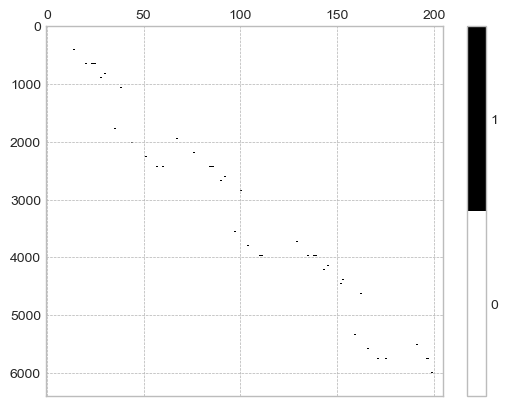

In [ ]:
# numd = len(sp_graph)
# sp_graph.c = 0
# dsigdL = np.zeros((numd**2,numd**2))
# idx = np.arange(sp_graph.n_observed_nodes**2).reshape(-1,sp_graph.n_observed_nodes).T[np.tril_indices(sp_graph.n_observed_nodes,k=-1)]   
# for I in idx:
#     i = I//sp_graph.n_observed_nodes; j = I%sp_graph.n_observed_nodes
#     dsigdL[I,sp_graph.n_observed_nodes*i+j] = 2*obj.Linv[i,j]**2
#     dsigdL[I,sp_graph.n_observed_nodes*j+i] = 2*obj.Linv[i,j]**2

#     dsigdL[I,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2
#     dsigdL[I,sp_graph.n_observed_nodes*j+j] = -obj.Linv[j,j]**2

#     It = sp_graph.n_observed_nodes*j + i
#     dsigdL[It,sp_graph.n_observed_nodes*i+j] = 2*obj.Linv[j,i]**2
#     dsigdL[It,sp_graph.n_observed_nodes*j+i] = 2*obj.Linv[i,j]**2

#     dsigdL[It,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2
#     dsigdL[It,sp_graph.n_observed_nodes*j+j] = -obj.Linv[j,j]**2
        
# s = sp_graph.lre[0][0]; d = sp_graph.lre[0][1]
# I = sp_graph.n_observed_nodes*d + s 
# dsigdL[I,sp_graph.n_observed_nodes*s+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[s,d]**2)
# dsigdL[I,sp_graph.n_observed_nodes*d+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[d,s]**2)

# dsigdL[I,sp_graph.n_observed_nodes*s+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[s,s]**2)  
# dsigdL[I,sp_graph.n_observed_nodes*d+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[d,d]**2) 

# ## do it for transpose too
# I = sp_graph.n_observed_nodes*s + d 
# dsigdL[I,sp_graph.n_observed_nodes*s+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[s,d]**2)
# dsigdL[I,sp_graph.n_observed_nodes*d+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[d,s]**2)

# dsigdL[I,sp_graph.n_observed_nodes*s+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[s,s]**2)  
# dsigdL[I,sp_graph.n_observed_nodes*d+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[d,d]**2) 

# for i in set(range(sp_graph.n_observed_nodes))-{s,d}:
#     I = sp_graph.n_observed_nodes*d + i
#     dsigdL[I,sp_graph.n_observed_nodes*i+d] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+i] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+s] = 0.5*(sp_graph.c**2+sp_graph.c)*(-obj.Linv[s,s]**2)

#     dsigdL[I,sp_graph.n_observed_nodes*d+d] = 0.5*(sp_graph.c**2-3*sp_graph.c+2)*(-obj.Linv[d,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+d] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+s] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2

#     I = sp_graph.n_observed_nodes*i + d
#     dsigdL[I,sp_graph.n_observed_nodes*i+d] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+i] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+s] = 0.5*(sp_graph.c**2+sp_graph.c)*(-obj.Linv[s,s]**2)

#     dsigdL[I,sp_graph.n_observed_nodes*d+d] = 0.5*(sp_graph.c**2-3*sp_graph.c+2)*(-obj.Linv[d,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+d] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+s] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2

# print(np.divide(dsigdL,np.repeat((obj.Linv**2).reshape(16,1),16,axis=0).reshape(16,16,order='F')))

# dLdw = np.zeros((numd**2,len(sp_graph.edges)))
# for I in range(len(sp_graph.edges)):
#     Ii = list(sp_graph.edges)[I][0]; Ij = list(sp_graph.edges)[I][1]

#     dLdw[numd*Ii + Ij, I] = -1
#     dLdw[numd*Ij + Ii, I] = -1

# for i in range(numd):
#     for j in np.where(sp_graph.Delta_q.toarray()[:,i])[0]:
#         dLdw[numd*i + i, j] = 1

# plt.spy(dLdw,aspect='auto'); plt.colorbar()

# plt.imshow(dLdw[-500:,], aspect='auto', cmap='RdBu',norm=mpl.colors.TwoSlopeNorm(0)); plt.colorbar()
# plt.imshow(dLdw,aspect='auto',cmap='RdBu',norm=mpl.colors.TwoSlopeNorm(0)); plt.colorbar()

In [171]:
# df = obj.extract_outliers(pthresh=0.01)
# estdf['test'].iloc[np.where(estdf['tsim']==0)] = np.nan

0.010197876776240254

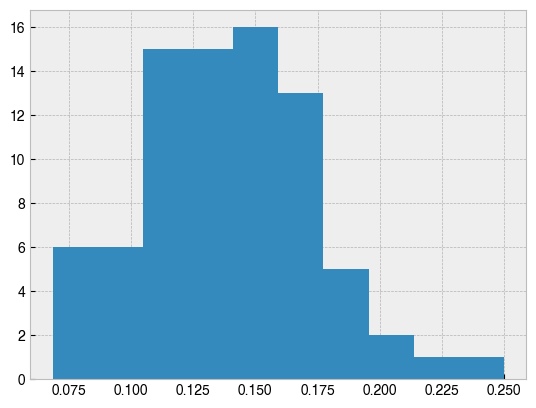

In [173]:
# estdf.boxplot(column='test',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat \tau$'); plt.xticks([1,2,3,4,5,6,7],labels=['no admix. (top)','no admix. (random)','inst.','1','10','100','200'],rotation=30); plt.show()
# estdf.boxplot(column='test',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat \tau$'); plt.xticks([1,2],labels=['no admix. (top)','no admix. (random)'],rotation=30); plt.show()
# estdf.boxplot(column='cest',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$'); plt.xticks([1,2,3,4,5,6,7],labels=['no admix. (top)','no admix. (random)','inst.','1','10','100','200'],rotation=30); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
# estdf.boxplot(column='ciest',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$'); plt.xticks([1,2],labels=['no admix. (top)','no admix. (random)'],rotation=30); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
# estdf.boxplot(column='ciest',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$ (assuming $\tau=0$)'); plt.xticks([1,2,3,4,5,6,7],labels=['no admix. (top)','no admix. (random)','inst.','1','10','100','200'],rotation=30); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
# estdf.assign(lldiff=lambda x: x.llc-x.llc0).boxplot(column='lldiff',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks([1,2,3,4,5,6,7],labels=['no admix. (top)','no admix. (random)','inst.','1','10','100','200'],rotation=30); plt.ylabel('diff. in log-lik units b/w instantaneous & null models'); plt.axhline(6.6,color='grey',ls='--'); plt.show()
# np.sum((estdf['llc']-estdf['llc0']).iloc[np.where(estdf['tsim']==-1)]<5)
# estdf['lre'].iloc[np.where((estdf['llc']-estdf['llc0']).iloc[np.where(estdf['tsim']==-1)]>0.6)[0]]
# estdf.assign(lldiff=lambda x: x.llct-x.llc).boxplot(column='lldiff',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks([1,2,3,4,5,6,7],labels=['no admix. (top)','no admix. (random)','inst.','1','10','100','200'],rotation=30); plt.ylabel('diff. in log-lik units b/w joint & instantaneous models'); plt.ylim((0,5)); plt.axhline(4,color='grey',ls='--'); plt.show()
# estdf.assign(lldiff=lambda x: x.llct-x.llc)
plt.hist(1/sp_graph.q); 

In [765]:
# from pandas_plink import read_plink
# data_path = "/Users/vivaswatshastry/src/feems/feems/data/AEA"
# (bim, fam, G) = read_plink("{}/c1global1nfd".format(data_path))
coord = np.loadtxt("{}/c1global1nfd-run1.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/c1global1nfd.outer".format(data_path))  # outer coordinates
grid_path = "/Users/vivaswatshastry/src/feems/feems/data/grid_100.shp" # path to discrete global grid

outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=False, 
                                             buffer=1,
                                             outer=outer)

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


In [1002]:
# outlier_df = obj.extract_outliers(0.001)
# outlier_df['dest.'].iloc[np.argsort(outlier_df['pval'])].tail(n=50)

,source,"source (lat., long.)","dest. (lat., long.)",pval,raw diff.,"# of samples (source, dest.)",Fst
dest.,,,,,,,
129,7,7,7,7,7,7,7
1106,1,1,1,1,1,1,1
2230,77,77,77,77,77,77,77
2312,1,1,1,1,1,1,1


/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: i

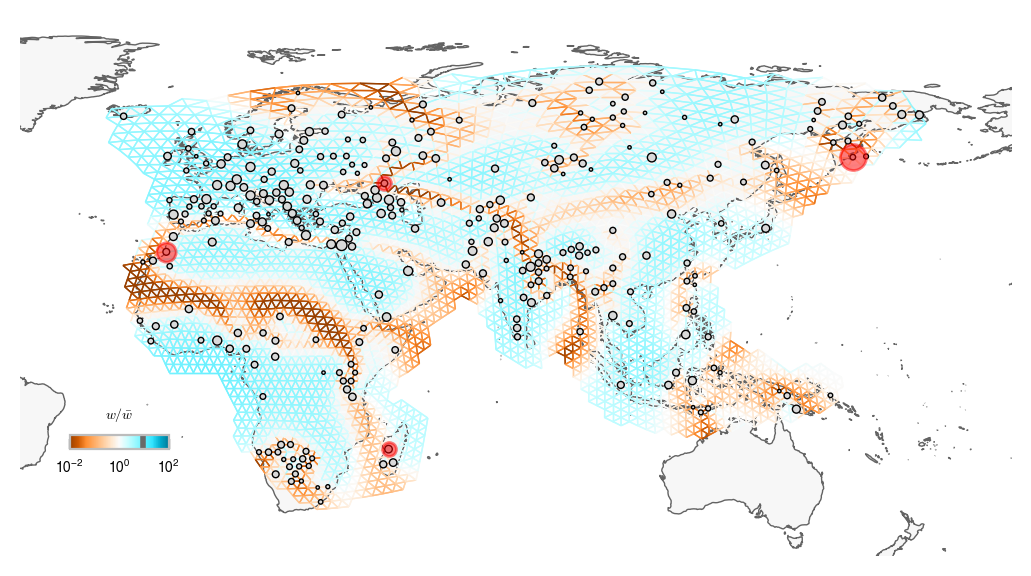

In [1003]:
# imp = SimpleImputer(missing_values=np.nan, strategy="mean")
# genotypes = imp.fit_transform((np.array(G)).T)
# sp_graph_jt = FEEMSmix_SpatialGraph(genotypes, coord, grid, edges)
# sp_graph_jt.fit(lamb=2.,optimize_q='n-dim',lamb_q=1.)
# obj = FEEMSmix_Objective(sp_graph_jt); obj.inv(); obj.grad(reg=False)
permuted_idx = query_node_attributes(sp_graph_jt, "permuted_idx")
fig = plt.figure(dpi=200)
projection = ccrs.PlateCarree(central_longitude=80.0)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph_jt, obj, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=2, obs_node_textsize=3,
        obs_node_size=1.5, sample_pt_color="black", cbar_ticklabelsize=5,
        cbar_font_size=5, cbar_width='10%',cbar_height='2.5%')
v.draw_map(latlong=False); v.draw_obs_nodes(use_ids=False); v.draw_edges(use_weights=True); v.draw_edge_colorbar()
for e in np.unique(outlier_df['dest.']):
        v.ax.plot(v.grid[e, 0], v.grid[e, 1], 'ro', markersize=np.log(np.sum(outlier_df['dest.']==e))+5, alpha=0.5)
# outlier_df = obj.extract_outliers(pthresh=0.001, verbose=False)

In [810]:
# contour_df2312 = obj.calc_contour(destid=2312, search_area='range', opts=[[70,180],[-20,90]])
# contour_df2312 = contour_df2312.drop(np.where(np.isnan(contour_df2312['scaled log-lik']))[0]+1)

# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection); 
# v = Viz(ax, sp_graph_jt, obj, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5, obs_node_size=1, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
# v.draw_map(latlong=False)
# v.draw_arrow([contour_df2312['(source, dest.)'].iloc[np.argmax(contour_df2312['scaled log-lik'])]],0.1)
# v.draw_ll_contour(contour_df2312,levels=[-20,0]); v.draw_obs_nodes(use_ids=False)

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shap

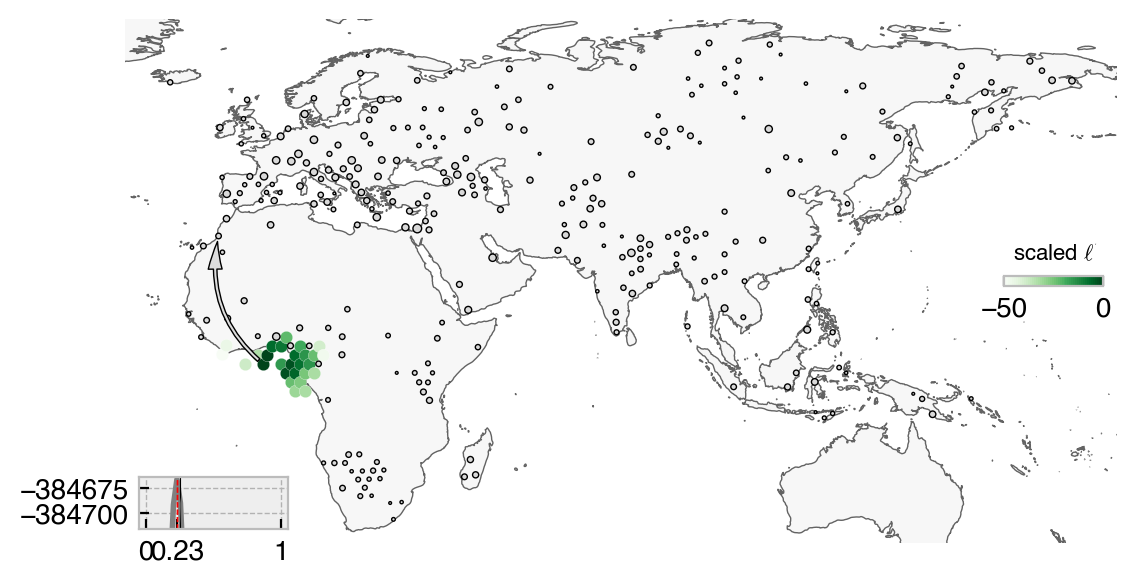

In [969]:
# contour_df129 = obj.calc_contour(destid=129, search_area='range', opts=[[-30,60],[-40,90]])

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection); 
v = Viz(ax, sp_graph_jt, obj, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5, obs_node_size=1, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
v.draw_map(latlong=False)
v.draw_arrow([contour_df129['(source, dest.)'].iloc[np.argmax(contour_df129['scaled log-lik'])]],0.23)
v.draw_ll_contour(contour_df129,levels=[-50,0]); v.draw_obs_nodes(use_ids=False)

In [976]:
# contour_df2230 = obj.calc_contour(destid=2230, search_area='range', opts=[[-30,180],[30,90]])
# contour_df1106 = obj.calc_contour(destid=1106, search_area='range', opts=[[60,180],[0,90]])
# contour_df1312 = obj.calc_contour(destid=1312, search_area='all')

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection); 
v = Viz(ax, sp_graph_jt, obj, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5, obs_node_size=1, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
v.draw_map(latlong=False); v.draw_obs_nodes(use_ids=False); #v.draw_edges(use_weights=True); v.draw_edge_colorbar(); v.draw_c_colorbar()
# v.draw_arrow([contour_df1312['(source, dest.)'].iloc[np.argmax(contour_df1312['scaled log-lik'])]],0.25)
# v.draw_ll_contour(contour_df1312,levels=[-20,0]); v.draw_obs_nodes(use_ids=False)
for e in [2230, 1312, 1106, 129, 2312]:
    pe = eval("contour_df{:d}".format(e))['(source, dest.)'].iloc[np.argmax(eval("contour_df{:d}".format(e))['scaled log-lik'])]
    # v.draw_arrow([(pe[0],pe[1])],eval("contour_df{:d}".format(e))['admix. prop.'].iloc[np.argmax(eval("contour_df{:d}".format(e))['scaled log-lik'])]*0.82)
# location_data = pd.read_csv("{}/c1global1nfd.pop_geo".format(data_path))
# sample_data = pd.read_csv("{}/c1global1nfd.indiv_meta".format(data_path))
# order = pd.read_table("{}/c1global1nfd.order".format(data_path), header=None, sep=" ")

# meta_data = sample_data.merge(location_data)
# obs_perm_ids = permuted_idx[: sp_graph_jt.n_observed_nodes]

## code for mapping nodes back to populations (since multiple pops can be assigned to the same nodes)
# node_to_pop = pd.DataFrame(index = np.arange(sp_graph_jt.n_observed_nodes), columns = ['nodes', 'pops'])
# node_to_pop['nodes'] = obs_perm_ids
# node_to_pop['pops'] = [np.unique(sample_data['popId'][nx.get_node_attributes(sp_graph_jt,"sample_idx")[x]]) for x in obs_perm_ids]
# node_to_pop
# popdict = {}
# for i in np.arange(297):
#     for l in node_to_pop.iloc[i,1]:
#         popdict[l] = i
# popdict[217], np.where(permuted_idx==2323)[0]
# list(popdict.keys())[list(popdict.values()).index(np.where(permuted_idx==1320)[0])]

153

Text(0.5, 0, 'simulated $\\tau$ (in gens)')

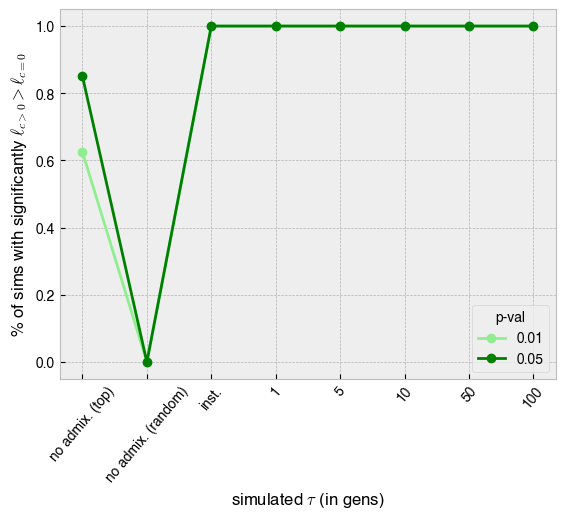

In [170]:
## how many sims have a log-lik > 4 or p-val
# sp.stats.chi2.sf(6.6,1)
# pd.concat([estdf,ctest]).assign(lldiff=lambda x: x.llct-x.llc)[pd.concat([estdf,ctest]).assign(lldiff=lambda x: x.llct-x.llc)['lldiff']>3.3].groupby('tsim')['lldiff'].count()/16
# ctest['test'].loc[ctest['tsim']==10]
# plt.hist(ctest['test'].loc[ctest['tsim']==20]/np.mean(1/sp_graph.q),color='grey'); plt.hist(estdf['test'].loc[estdf['tsim']==0]/np.mean(1/sp_graph.q),color='blue'); plt.hist(ctest['test'].loc[ctest['tsim']==1]/np.mean(1/sp_graph.q),color='yellow')
# plt.plot(range(1,9),[0,0,1,0.95,1,1,1,0.6],'-o',color='lightgreen',label='0.01'); plt.xticks([1,2,3,4,5,6,7,8],labels=['no admix. (top)','no admix. (random)','inst.','1','5','10','50','100'],rotation=50); plt.ylabel(r'% of sims with $\tau \geq 0$ for a certain threshold'); plt.plot(range(1,9),[0,0,1,0.97,1,1,1,0.9375],'-o',color='green',label='0.05'); plt.legend(title='p-val'); plt.xlabel(r'simulated $\tau$ (in gens)')
# plt.plot(range(1,9),[0.625,0,1,1,1,1,1,1],'-o',color='lightgreen',label='0.01'); plt.xticks([1,2,3,4,5,6,7,8],labels=['no admix. (top)','no admix. (random)','inst.','1','5','10','50','100'],rotation=50); plt.ylabel(r'% of sims with significantly $\ell_{c>0} > \ell_{c=0}$'); plt.plot(range(1,9),[0.85,0,1,1,1,1,1,1],'-o',color='green',label='0.05'); plt.legend(title='p-val'); plt.xlabel(r'simulated $\tau$ (in gens)')
## TPR & FPR
# plt.plot(range(1,9),[0.5625,0,1,1,1,1,1,1],'-o',color=plt.get_cmap('Blues',4)(3),label='0.01'); plt.plot(range(1,9),[0.625,0,1,1,1,1,1,1],'-o',color=plt.get_cmap('Blues',4)(2),label='0.1'); plt.plot(range(1,9),[0.875,0,1,1,1,1,0,0],'-o',color=plt.get_cmap('Blues',4)(1),label='1'); plt.legend(title=r'$Nm$'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks([1,2,3,4,5,6,7,8],labels=['no admix. (top)','no admix. (random)','inst.','1','5','10','50','100'],rotation=50); plt.ylabel('% of sims with significantly $\ell_{c>0} > \ell_{c=0}$')
# plt.plot(range(1,9),[0,0,1,1,1,1,1,0.6],'-o',color=plt.get_cmap('Blues',4)(3),label='0.01'); plt.plot(range(1,9),[0,0,0.85,1,0.8,0.7,0,0],'-o',color=plt.get_cmap('Blues',4)(2),label='0.1'); plt.plot(range(1,9),[0,0,0,0,0,0,0,0],'-o',color=plt.get_cmap('Blues',4)(1),label='1'); plt.legend(title=r'$Nm$'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks([1,2,3,4,5,6,7,8],labels=['no admix. (top)','no admix. (random)','inst.','1','5','10','50','100'],rotation=50); plt.ylabel('% of sims with significantly $\ell_{{\\tau}>0} > \ell_{{\\tau}=0}$')

In [242]:
# n_rows, n_columns = 8, 10
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=0.0001, barrier_w=0.0001, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=15)
# foo = lambda t: simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=900, long_range_nodes=[(22,57)], admixture_props=[0.5], n_e=100, time_of_adm=[t], dump=False)
# for it, t in enumerate([100,50,10,5,1,1e-8,0]):
#     gen_test_2 = Parallel(n_jobs=16)(delayed(foo)(t) for _ in range(16))
#     for rep in range(16):
#         np.savetxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c0.5_t{}_Nm0.01_sim{}.csv".format(t,rep),gen_test_2[rep],delimiter=',',fmt='%f')
# pd.concat([estdf,ctest]).boxplot(column='test',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat \tau$'); plt.xticks([1,2,3,4,5,6,7,8,9,10],labels=['no admix. (top)','no admix. (random)','inst.','1','2','5','10','20','50','100'],rotation=50); plt.show()
# pd.concat([estdf,ctest]).boxplot(column='ciest',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$'); plt.xticks([1,2,3,4,5,6,7,8,9,10],labels=['no admix. (top)','no admix. (random)','inst.','1','2','5','10','20','50','100'],rotation=50); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
# pd.concat([estdf,ctest]).boxplot(column='cest',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$ (assuming $\tau=0$)'); plt.xticks([1,2,3,4,5,6,7,8],labels=['no admix. (top)','no admix. (random)','inst.','1','5','10','50','100'],rotation=50); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
# pd.concat([estdf,ctest]).assign(lldiff=lambda x: x.llct-x.llc).boxplot(column='lldiff',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)');plt.xticks([1,2,3,4,5,6,7,8,9,10],labels=['no admix. (top)','no admix. (random)','inst.','1','2','5','10','20','50','100'],rotation=50);plt.ylabel('diff. in log-lik units b/w joint & instantaneous models'); plt.axhline(4,color='grey',ls='--'); plt.show()
# pd.concat([estdf,ctest]).assign(lldiff=lambda x: x.llc-x.llc0).boxplot(column='lldiff',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks([1,2,3,4,5,6,7,8],labels=['no admix. (top)','no admix. (random)','inst.','1','5','10','50','100'],rotation=50); plt.ylabel('diff. in log-lik units b/w instantaneous & null models'); plt.axhline(6,color='grey',ls='--'); plt.show() 

# estw100 = np.zeros(205); estq100 = np.zeros(80)
# # for rep in range(1,11):
# for rep in [1,2,3,5,6,7,8,9,10,11,12]:
#     gen_test_2 = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c0.5_t0_Nm0.01_sim{}.csv".format(rep),delimiter=',')
#     sp_graph = FEEMSmix_SpatialGraph(gen_test_2, coord_def, grid_def, edge_def)
#     sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=1., verbose=False); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
#     estw100 += sp_graph.w; estq100 += 1/sp_graph.q
# plt.boxplot([np.log10(estw100/10/np.mean(estw100/10)),np.log10(estw10/10/np.mean(estw10/10)),np.log10(estw/10/np.mean(estw/10))]); plt.xlabel(r'$Nm$'); plt.xticks([1,2,3],labels=['0.01','0.1','1']); plt.ylabel(r'$\log_{10}(\hat w/\bar w)$')
# plt.boxplot([estq100/10,estq10/10,estq/10]); plt.xlabel(r'$Nm$'); plt.xticks([1,2,3],labels=['0.01','0.1','1']); plt.ylabel(r'$\hat q$')
# plt.hist(1/sp_graph.q)
# gen_test_2 = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c0.5_t1e-08_Nm0.01_sim14.csv",delimiter=',')
# sp_graph = FEEMSmix_SpatialGraph(gen_test_2, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=4., optimize_q='n-dim', lamb_q=1., verbose=False); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
# sp.optimize.minimize(obj.neg_log_lik_c,x0=[0.5],args={'lre':[(22,57)],'mode':'sampled'},bounds=[(0,1)],method='L-BFGS-B')
# lamb_grid = np.geomspace(1e-2,100,10,endpoint=True)[::-1]
cv_err = run_cv(sp_graph, lamb_grid, n_folds=10, factr=1e10)
lamb_grid[np.argmin(np.mean(cv_err, axis=0))]


 fold= 0
iteration lambda=10/10 alpha=1/1
 fold= 1
iteration lambda=10/10 alpha=1/1
 fold= 2
iteration lambda=10/10 alpha=1/1
 fold= 3
iteration lambda=10/10 alpha=1/1
 fold= 4
iteration lambda=10/10 alpha=1/1
 fold= 5
iteration lambda=10/10 alpha=1/1
 fold= 6
iteration lambda=10/10 alpha=1/1
 fold= 7
iteration lambda=10/10 alpha=1/1
 fold= 8
iteration lambda=10/10 alpha=1/1
 fold= 9
iteration lambda=10/10 alpha=1/1

4.6415888336127775

In [131]:
# estdf = pd.DataFrame(columns=['ciest','cest','test','tsim','rep','rank','llnull','llc0','llc','llct','lre'], index=range(2*16))
# idx = 0 
for rep in [0]:
    for it, t in enumerate([0,-1]):
        ## filling in the data frame
        estdf['rep'].iloc[idx] = rep
        estdf['tsim'].iloc[idx] = t 
        if t == -1:
            try:
                sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=1., verbose=False); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
                estdf['rank'].iloc[idx] = 0
                obj.lamb = 3.; obj.alpha = 1/sp_graph.w0.mean(); obj.lamb_q = 1.; obj.alpha_q = 1/sp_graph.s2.mean()
            except:
                continue
            estdf['llnull'].iloc[idx] = -obj.neg_log_lik()
            estdf['lre'].iloc[idx] = [(df.sort_values(by='pval').iloc[0]['source'],df.sort_values(by='pval').iloc[0]['dest.'])]
            obj.lamb = 3.; obj.alpha = 1/sp_graph.w0.mean(); obj.lamb_q = 1.; obj.alpha_q = 1/sp_graph.s2.mean()
            # newres = sp.optimize.fmin_l_bfgs_b(obj.joint_neg_log_lik_c,x0=np.r_[np.log(obj.sp_graph.w),np.log(obj.sp_graph.s2),0.5],approx_grad=True,args=[{'lre':estdf['lre'].iloc[idx]}],factr=1e10,maxiter=1000,maxls=20,bounds=[(-np.inf,np.inf) for _ in range(len(sp_graph.w)+len(sp_graph.s2))]+[(0,1)])
            # estdf['ciest'].iloc[idx] = newres[0][-1]
            estdf['ciest'].iloc[idx] = sp.optimize.minimize(obj.neg_log_lik_c,x0=[0.5],args={'lre':estdf['lre'].iloc[idx]}],'mode':'sampled'},bounds=[(0,1)],method='L-BFGS-B')
            estdf['llc'].iloc[idx] = -obj.neg_log_lik_c(newres[0][-1], {'lre':estdf['lre'].iloc[idx],'mode':'sampled'})
            estdf['llc0'].iloc[idx] = -obj.neg_log_lik_c(0, {'lre':estdf['lre'].iloc[idx],'mode':'sampled'})
            try:
                res = sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.01],args={'lre':estdf['lre'].iloc[idx]},bounds=[(0,1),(0,0.3)],method='L-BFGS-B')
            except:
                res = sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':estdf['lre'].iloc[idx]},bounds=[(0,1),(0,0.05)],method='L-BFGS-B')
            estdf['test'].iloc[idx] = res.x[1]; estdf['cest'].iloc[idx] = res.x[0]
            estdf['llct'].iloc[idx] = -res.fun
        else:
            gen_test_2 = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c0.5_t{}_Nm2_sim{}.csv".format(t,rep),delimiter=',')
            sp_graph = FEEMSmix_SpatialGraph(gen_test_2, coord_def, grid_def, edge_def)
            try:
                sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=1., verbose=False); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
            except:
                continue
            obj.lamb = 3.; obj.alpha = 1/sp_graph.w0.mean(); obj.lamb_q = 1.; obj.alpha_q = 1/sp_graph.s2.mean()
            df = obj.extract_outliers(pthresh=0.001,verbose=False)
            estdf['lre'].iloc[idx] = [(df.sort_values(by='pval').iloc[0]['source'],df.sort_values(by='pval').iloc[0]['dest.'])]
            try:
                # estdf['rank'].iloc[idx] = np.min(np.where(df.sort_values(by='pval')['dest.']==57))
                estdf['rank'].iloc[idx] = np.where(df['source'].iloc[np.where(df['dest.']==57)]==22)[0][0]
            except:
                estdf['rank'].iloc[idx] = np.nan
            estdf['llnull'].iloc[idx] = -obj.neg_log_lik()

            ## doing an initial fit
            # newres = sp.optimize.fmin_l_bfgs_b(obj.joint_neg_log_lik_c,x0=np.r_[np.log(obj.sp_graph.w),np.log(obj.sp_graph.s2),0.5],approx_grad=True,args=[{'lre':[(22,57)]}],factr=1e10,maxiter=1000,maxls=20,bounds=[(-np.inf,np.inf) for _ in range(len(sp_graph.w)+len(sp_graph.s2))]+[(0,1)])
            # estdf['ciest'].iloc[idx] = newres[0][-1]
            estdf['ciest'].iloc[idx] = sp.optimize.minimize(obj.neg_log_lik_c,x0=[0.5],args={'lre':[(22,57)],'mode':'sampled'},bounds=[(0,1)],method='L-BFGS-B')
            estdf['llc'].iloc[idx] = -obj.neg_log_lik_c(newres[0][-1], {'lre':[(22,57)],'mode':'sampled'})
            estdf['llc0'].iloc[idx] = -obj.neg_log_lik_c(0, {'lre':[(22,57)],'mode':'sampled'})

            try:
                res = sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.01],args={'lre':[(22,57)]},bounds=[(0,1),(0,0.3)],method='L-BFGS-B')
            except:
                res = sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[(22,57)]},bounds=[(0,1),(0,0.05)],method='L-BFGS-B')
            estdf['test'].iloc[idx] = res.x[1]; estdf['cest'].iloc[idx] = res.x[0]
            estdf['llct'].iloc[idx] = -res.fun

        # print(estdf.iloc[idx])
        idx += 1

Using a significance threhsold of 0.001:

17 outlier deme pairs found
 source  dest.     source (lat., long.)       dest. (lat., long.)     pval
     78     32  (6.06217782649107, 8.5)  (2.598076211353316, 2.5) 0.000008
     58     21 (4.330127018922193, 8.5) (1.7320508075688772, 1.0) 0.000012
     69     32 (5.196152422706632, 9.0)  (2.598076211353316, 2.5) 0.000015
     58     32 (4.330127018922193, 8.5)  (2.598076211353316, 2.5) 0.000019
     70     69  (6.06217782649107, 0.5)  (5.196152422706632, 9.0) 0.000060
     42     58 (4.330127018922193, 8.5) (3.4641016151377544, 2.0) 0.000112

Putative destination demes (and # of times the deme appears as an outlier) experiencing admixture:
32    4
58    3
21    2
25    2
69    2
Name: dest., dtype: int64


In [241]:
# plt.plot(-np.diag(obj.Linv)-0.5/sp_graph.q,np.diag(coaltimets10),'ko')
# sp.stats.linregress(-np.diag(obj.Linv)-0.5/sp_graph.q,np.diag(coaltimets10)) #6870, 25000; 6450, 24500; 6400, 24308;  
# np.mean(ctest['test'].loc[ctest['tsim']==10])/np.mean(np.diag(obj.Linv)), 10/np.mean(np.diag(coaltimets10))
# sp.stats.ttest_ind(ctest['test'].loc[ctest['tsim']==1e-6].to_numpy(dtype='float'),ctest['test'].loc[ctest['tsim']==10].to_numpy(dtype='float'))

0.5812682616779029

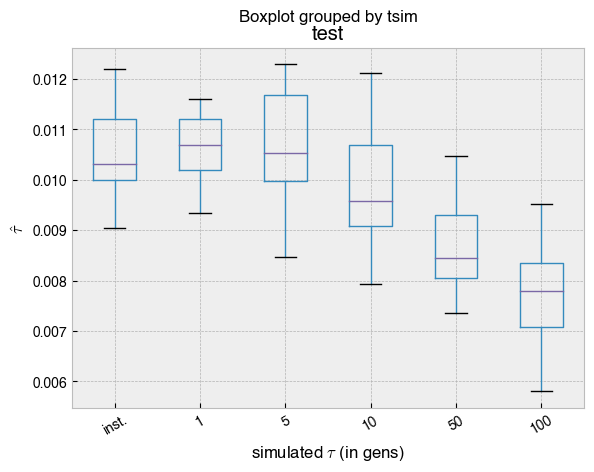

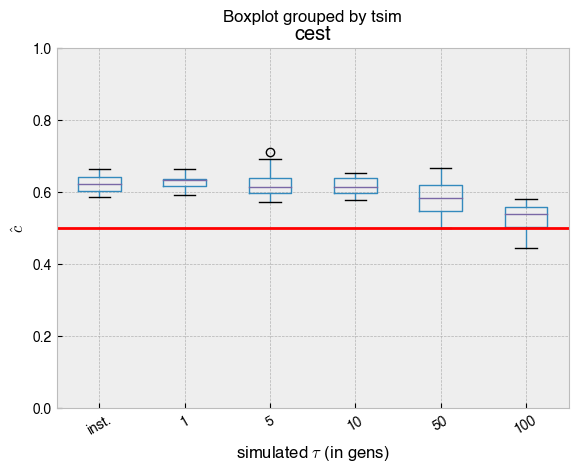

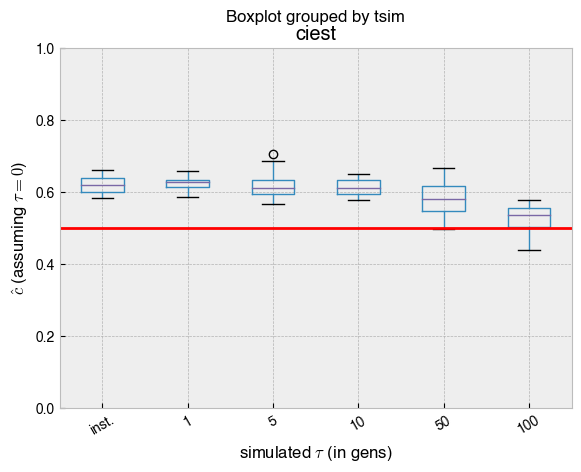

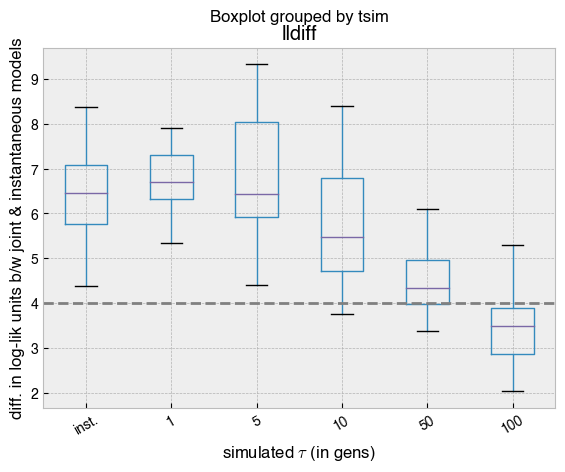

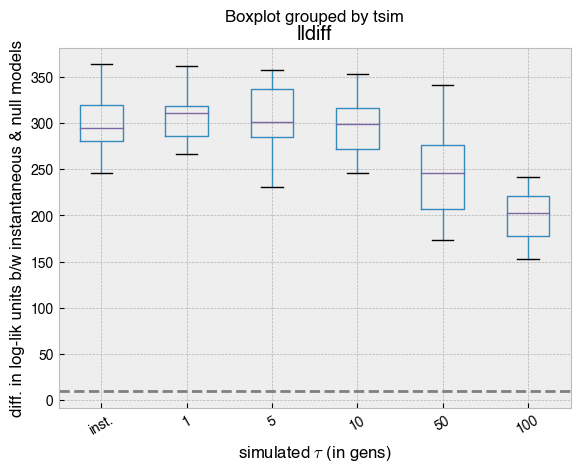

In [65]:
# ctest.assign(test_tr=lambda x: x.test/np.mean(np.diag(obj.Linv)+0.5/sp_graph.q)).boxplot(column='test_tr',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat \tau$'); plt.xticks([1,2,3,4,5,6,7,8],labels=['inst.','1','2','5','10','20','50','100'],rotation=30); plt.show()
# ctest.assign(test_tr=lambda x: 40*x.test).boxplot(column='test_tr',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat \tau$ (scaled)'); plt.xticks([1,2,3,4,5,6,7,8],labels=['inst.','1','2','5','10','20','50','100'],rotation=30); 
ctest.boxplot(column='test',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat \tau$'); plt.xticks([1,2,3,4,5,6],labels=['inst.','1','5','10','50','100'],rotation=30); plt.show()
ctest.boxplot(column='cest',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$'); plt.xticks([1,2,3,4,5,6],labels=['inst.','1','5','10','50','100'],rotation=30); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
ctest.boxplot(column='ciest',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$ (assuming $\tau=0$)'); plt.xticks([1,2,3,4,5,6],labels=['inst.','1','5','10','50','100'],rotation=30); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
# ctest.boxplot(column='cest',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$'); plt.xticks([1,2,3,4],labels=['inst.','1','10','100'],rotation=30); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
# ctest.boxplot(column='test',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.ylabel(r'$\hat c$ (assuming $\tau=0$)'); plt.xticks([1,2,3,4,5,6,7,8],labels=['inst.','1','2','5','10','20','50','100'],rotation=30); plt.axhline(0.5,color='red'); plt.ylim((0,1)); plt.show()
ctest.assign(lldiff=lambda x: x.llct-x.llc).boxplot(column='lldiff',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)');plt.xticks([1,2,3,4,5,6],labels=['inst.','1','5','10','50','100'],rotation=30); plt.ylabel('diff. in log-lik units b/w joint & instantaneous models'); plt.axhline(4,color='grey',ls='--'); plt.show()
ctest.assign(lldiff=lambda x: x.llc-x.llc0).boxplot(column='lldiff',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks([1,2,3,4,5,6],labels=['inst.','1','5','10','50','100'],rotation=30); plt.ylabel('diff. in log-lik units b/w instantaneous & null models'); plt.axhline(9.2,color='grey',ls='--'); plt.show() 
# ctest.assign(lldiff=lambda x: x.llct-x.llc).boxplot(column='lldiff',by='tsim'); plt.xlabel(r'simulated $\tau$ (in gens)'); plt.xticks([1,2,3,4],labels=['inst.','1','10','100'],rotation=30); plt.ylabel('diff. in log-lik units b/w instantaneous & null models'); plt.axhline(9.2,color='grey',ls='--'); plt.show()
# sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.00],args={'lre':[(22,57)]},bounds=[(0,1),(0,0.05)],method='Nelder-Mead')
# obj.neg_log_lik_c_t([0.5,0.05],{'lre':[(22,57)]}), obj.neg_log_lik_c(0.5,{'lre':[(22,57)],'mode':'sampled'}) #get_FEEMS_demes_nll_w_c(0.4,sp_graph,obj,[(22,57)])
# plt.plot(np.linspace(0,1,12),[-obj.neg_log_lik_c_t([c,0.0],{'lre':[(22,57)]}) for c in np.linspace(0,1,12)]); plt.plot(np.linspace(0,1,12),[-obj.neg_log_lik_c(c,{'lre':[(22,57)],'mode':'sampled'}) for c in np.linspace(0,1,12)]); plt.plot(np.linspace(0,1,12),[-get_FEEMS_demes_nll_w_c(c, sp_graph, obj, [(22,57)]) for c in np.linspace(0,1,12)])
# sp.optimize.minimize_scalar(get_FEEMS_demes_nll_w_c, args=(sp_graph, obj, [(22,57)]), method='bounded', bounds=[0,1])

In [64]:
ctest = pd.DataFrame(columns=['ciest','cest','test','tsim','rep','llc0','llc','llct'], index=range(6*16))
idx = 0
for t in [1e-8,1,5,10,50,100]:
    for rep in range(16):
            
        ctest.at[idx,'tsim'] = t
        ctest.at[idx,'rep'] = rep

        gen_test_2 = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c0.5_t{}_Nm0.01_sim{}.csv".format(t,rep),delimiter=',')
        # if t==1e-6:
        #     gen_test_2 = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c0.5_t{}_sim{}.csv".format(0,rep),delimiter=',')
        #     if rep<10:
        #         gen_test_2[57*15:(57*15+7),:] = gen_test_2[22*15:(22*15+7),:]
        #     else:
        #         gen_test_2[57*15:(57*15+8),:] = gen_test_2[22*15:(22*15+8),:]
        #     gen_test_2 = np.delete(gen_test_2,np.where(gen_test_2.sum(axis=0)==0)[0],1)
        #     gen_test_2 = np.delete(gen_test_2,np.where(gen_test_2.sum(axis=0)==2*gen_test_2.shape[0])[0],1)

        sp_graph = FEEMSmix_SpatialGraph(gen_test_2, coord_def, grid_def, edge_def)
        try:
            sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=1.); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
            res = sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.01],args={'lre':[(22,57)]},bounds=[(0,1),(0,0.05)],method='Nelder-Mead')
            ctest.at[idx,'cest'] = res.x[0]; ctest.at[idx,'test'] = res.x[1]; ctest.at[idx,'llct'] = -res.fun
            res = sp.optimize.minimize(obj.neg_log_lik_c,x0=0.5,args={'lre':[(22,57)],'mode':'sampled'},bounds=[(0,1)],method='L-BFGS-B')
            ctest.at[idx,'ciest'] = res.x[0]; ctest.at[idx,'llc'] = -res.fun
            ctest.at[idx,'llc0'] = -obj.neg_log_lik_c(0,{'lre':[(22,57)],'mode':'sampled'})
        except:
            continue
        print(ctest.at[idx,'cest'], ctest.at[idx,'test'])

        # print(ctest.loc[idx])
        idx += 1

constant-w/variance fit, converged in 142 iterations, train_loss=150784.970
lambda=3.000, alpha=6.1850, converged in 30 iterations, train_loss=148531.875
0.6316123645621701 0.011499763220694143
constant-w/variance fit, converged in 155 iterations, train_loss=152466.001
lambda=3.000, alpha=5.9817, converged in 26 iterations, train_loss=150733.328
0.6382277322159209 0.009963486791674768
constant-w/variance fit, converged in 150 iterations, train_loss=149019.796
lambda=3.000, alpha=6.3371, converged in 33 iterations, train_loss=147283.981
0.5989809869177417 0.010180087266722683
constant-w/variance fit, converged in 155 iterations, train_loss=148558.042
lambda=3.000, alpha=6.1956, converged in 30 iterations, train_loss=147123.765
0.618244756013155 0.011150245212018486
constant-w/variance fit, converged in 142 iterations, train_loss=150613.908
lambda=3.000, alpha=6.1367, converged in 24 iterations, train_loss=149381.803
0.6276082389056689 0.010283163525164122
constant-w/variance fit, conver

In [62]:
# obj.lamb = 3.; obj.alpha = 1/sp_graph.w0.mean(); obj.lamb_q = 1.; obj.alpha_q = 1/sp_graph.s2.mean()
# obj.neg_log_lik_c(0,{'lre':[(9,0)],'mode':'sampled'}), obj.joint_neg_log_lik_c(np.r_[np.log(sp_graph.w),np.log(sp_graph.q),sp_graph.c,sp_graph.t],{'lre':[(9,0)]})
# obj.neg_log_lik(), obj.neg_log_lik_c_t([0.55,0.00],{'lre':[(22,57)]}), obj.neg_log_lik_c(0.55,{'lre':[(22,57)],'mode':'sampled'}),
# sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[(22,57)]},bounds=[(0,1),(0,0.05)],method='Nelder-Mead') #14891
# plt.imshow(obj.Linv-obj_nomu.Linv,cmap='RdBu'); plt.colorbar()
# plt.plot(1/sp_graph.q, 1/sp_graph_nomu.q, 'ko'); plt.axline((0,0),slope=1)
# plt.plot(sp_graph.w, sp_graph_nomu.w, 'ko'); plt.axline((0,0),slope=1)
# obj_nomu.extract_outliers(pthresh=0.01)
# plt.plot(sp_graph.w, np.exp(newres[0][:sp_graph.size()]),'ko')
# newres[1], obj.neg_log_lik_c_t([0.5,0.0],{'lre':[(22,57)]}), obj.neg_log_lik_c(0.5,{'lre':[(22,57)],'mode':'sampled'})
# plt.plot(np.linspace(0,0.05,30),[-obj.neg_log_lik_c_t([0.3,t],{'lre':[(22,57)]}) for t in np.linspace(0,0.05,30)])
# plt.plot(np.linspace(0,0.05,30),[-obj.neg_log_lik_c_t([0.5,t],{'lre':[(22,57)]}) for t in np.linspace(0,0.05,30)])
# plt.plot(np.linspace(0,0.05,30),[-obj.neg_log_lik_c_t([0.7,t],{'lre':[(22,57)]}) for t in np.linspace(0,0.05,30)]); 

AssertionError: did not converge

In [471]:
# plt.hist(1/sp_graph.q,bins=10); plt.show(); plt.hist(sp_graph.w,bins=20); plt.show()
# sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=1., option='bothct', long_range_edges=[(23,56)])
# newres = sp.optimize.fmin_l_bfgs_b(obj.joint_neg_log_lik_c,x0=np.r_[np.log(obj.sp_graph.w),np.log(obj.sp_graph.s2),obj.sp_graph.c],approx_grad=True,args=[{'lre':[(22,57)]}],factr=1e10,maxiter=1000,maxls=20,bounds=[(-np.inf,np.inf) for _ in range(len(sp_graph.w)+len(sp_graph.s2))]+[(0,1)])
# print(np.exp(newres[0][:sp_graph.size()]), np.exp(newres[0][sp_graph.size():-1]), newres[0][-1])
# newres = sp.optimize.fmin_l_bfgs_b(obj.joint_neg_log_lik_c_t,x0=np.r_[np.log(obj.sp_graph.w),np.log(obj.sp_graph.s2),0.5,1e-2],approx_grad=True,args=[{'lre':[(22,57)]}],factr=1e7,maxiter=1000,maxls=20,bounds=[(-np.inf,np.inf) for _ in range(len(sp_graph.w)+len(sp_graph.s2))]+[(0,1)]+[(0,0.2)])
# print(np.exp(newres[0][:sp_graph.size()]), np.exp(newres[0][sp_graph.size():-2]), newres[0][-2:])
# sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.26,0.00],args=({'lre':[(22,57)]}),method='Nelder-Mead',bounds=[(0,1),(0,0.03)]), sp.optimize.minimize(obj.neg_log_lik_c,x0=0.2,args=({'lre':[(22,57)],'mode':'sampled'}),method='L-BFGS-B',bounds=[(0,1)]), newres[1], obj.neg_log_lik_c_t([0.5,0.001],{'lre':[(22,57)]}),obj.neg_log_lik_c(0.09,{'lre':[(22,57)],'mode':'sampled'}) # 13401
# sp.optimize.minimize(obj.neg_log_lik_c,x0=0.2,args=({'lre':[(22,57)],'mode':'sampled'})), sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.22,1e-4],args=({'lre':[(22,57)]}),method='L-BFGS-B',bounds=[(0,1),(0,0.2)])
# obj.joint_neg_log_lik_c(np.r_[np.log(sp_graph.w),np.log(sp_graph.s2),0.29],{'lre':[(22,57)]})
# obj.joint_neg_log_lik_c_t(np.r_[np.log(sp_graph.w),np.log(sp_graph.s2),0.6,0.01],{'lre':[(22,57)]}) #
# -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T), -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat_hao @ C.T)
# sp_graph.c, sp_graph.t
# ?sp.optimize.fmin_l_bfgs_b
# plt.hist(1/sp_graph.q); plt.axvline(1/sp_graph.q[56],color='red')
# plt.hist(1/sp_graph.q,bins=10); plt.show(); plt.hist(sp_graph.w,bins=20)

(19185.890670274996, 19185.890670274996)

In [811]:
# n_rows, n_columns = 8, 10
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1e-3, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=4, barrier_endpt=6, n_samples_per_node=15)
# gen_test_2 = simulate_genotypes_w_admixture(graph_def, target_n_snps=800, n_print=700, long_range_nodes=[(22,57)], admixture_props=[0.5], time_of_adm=[100], n_e=100, dump=False)
# sp_graph = FEEMSmix_SpatialGraph(gen_test_2, coord_def, grid_def, edge_def)
# %time sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=1.); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False); #oldw = sp_graph.w; olds2 = sp_graph.s2
# df = obj.extract_outliers(0.01,verbose=False)
# plt.plot(oldw,np.exp(newres[0][:sp_graph.size()]),'ko',alpha=0.5); plt.axline((1,1),slope=1,color='grey'); plt.xlabel(r'$\hat w$ before joint optimization'); plt.ylabel(r'$\hat w$ after')
# plt.plot(olds2,np.exp(newres[0][sp_graph.size():-2]),'ko',alpha=0.5); plt.axline((1,1),slope=1,color='grey'); plt.plot(olds2[57],np.exp(newres[0][sp_graph.size():-2])[57],'r*'); plt.xlabel(r'$\hat \sigma^2$ before joint optimization'); plt.ylabel(r'$\hat \sigma^2$ after')
# np.exp(newres[0][sp_graph.size():-1])
# fig = plt.figure(dpi=110)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, abs_max=0.25,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# sp_graph.fit(lamb=3., optimize_q=None, option='onlyc', long_range_edges=[(23,56)]); sp_graph.c
# sp_graph.q
# fit_cov, _, emp_cov = comp_mats(obj)
# fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
# emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
# X = sm.add_constant(fit_dist)
# mod = sm.OLS(emp_dist, X)
# res = mod.fit()
# muhat, betahat = res.params
# plt.plot(fit_dist, emp_dist, 'o', color='grey', alpha=0.5, markersize=4); plt.axline((0,muhat), slope=betahat, color='orange', ls='--', lw=3)
# plt.text(1, 0.5, r'$R^2 \approx {}$'.format(np.around(res.rsquared_adj,2)), fontsize=15); plt.xlabel('fit distance'); plt.ylabel('empirical distance')

# lle, te = get_best_lre(sp_graph, gen_test_2, coord_def, grid_def, edge_def, k=2, top=5, nchoose=100, option='hard')
# defw = sp_graph.w; defq = sp_graph.q
# obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# gr = obj.grad_obj 
# sp_graph = Joint_SpatialGraph(gen_test_80, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3., optimize_q='n-dim', option='joint', long_range_edges=[(23,56)], c=0.2); #sp_graph.fit(lamb=3., optimize_q='n-dim', option='onlyc', long_range_edges=[(23,56)], c=0.2) 
# jtw = sp_graph.w; jtq = sp_graph.q
# obj = Joint_Objective(sp_graph, option= 'joint'); obj.inv(); obj.grad(reg=False)
# grjt = obj.grad_obj
# plt.plot(defw, jtw, 'ko'); plt.plot(defw,defw,ls='-',color='grey'); plt.xlabel('default weights'); plt.ylabel('weights with $c=0$'); plt.show()
# plt.plot(defq, jtq, 'ko'); plt.plot(defq,defq,ls='-',color='grey'); plt.xlabel('default $q$'); plt.ylabel('$q$ with $c=0$')
# plt.plot(gr, grjt, 'ko'); plt.plot(gr,gr,ls='-',color='grey'); plt.xlabel('gradient of obj (default)'); plt.ylabel('gradient of obj (with $c=0$)')

In [77]:
# sp_graph.fit(lamb=1., optimize_q='n-dim', lamb_q=1.); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# sp.optimize.minimize(get_FEEMS_hao_nll_w_c_t, x0=[0.5,0.01], args=(sp_graph, obj, [(23,56)]), method='Nelder-Mead', bounds=[(0,1),(0,0.05)])
# 1/sp_graph.q[12], 1/sp_graph_null.q[12], np.mean(1/sp_graph.q), np.mean(1/sp_graph_null.q)
# plt.plot(sp_graph_null.w, sp_graph.w,'ko',alpha=0.6); plt.show()
# plt.plot(range(80),1/sp_graph.q,'k*',alpha=0.6); plt.plot(range(80),1/sp_graph_null.q,'ro',alpha=0.6)
# plt.imshow(obj.comp_A-obj.comp_B); plt.colorbar()
# sp.optimize.minimize(get_FEEMS_demes_nll_w_c, x0=[0.5], args=(sp_graph, obj, [(23,56)]), method='L-BFGS-B', bounds=[(0,1)])
# get_FEEMS_hao_nll_w_c_t([0.55,0.002],sp_graph,obj,[(23,56)])#, np.min(ll2d)

18654.99439135936

In [283]:
# tausim = [10, 20, 50, 100, 200]
est2 = np.zeros((100,4)); cnt = 0
for t in tausim:
    for i in range(20):
        est2[cnt,0] = t
        gen_test_2 = simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=700, long_range_nodes=[(23,56)], admixture_props=[0.6], time_of_adm=[t], Ne=1000)
        sp_graph = FEEMSmix_SpatialGraph(gen_test_2, coord_def, grid_def, edge_def)
        sp_graph.fit(lamb=3., optimize_q=None, lamb_q=3., verbose=False); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

        res = sp.optimize.minimize(get_FEEMS_demes_nll_w_c_t, x0=[0.5,0.5], args=(sp_graph, obj, [(23,56)]), method='L-BFGS-B', bounds=[(0,1),(0,3)])
        est2[cnt,1] = res.x[1]
        est2[cnt,2] = res.x[0]
        est2[cnt,3] = res.fun - get_FEEMS_demes_nll_w_c_t([0.6,t/100], sp_graph, obj, [(23,56)])
        print(est2[cnt,])
        cnt += 1

Simulating ~SNP 0
Simulating ~SNP 700
[10.          0.01294518  0.59155628 -0.42367831]
Simulating ~SNP 0
Simulating ~SNP 700
[10.          0.13173797  0.59615973 -0.11956021]
Simulating ~SNP 0
Simulating ~SNP 700
[10.          0.30056323  0.71687457 -2.6947816 ]
Simulating ~SNP 0
Simulating ~SNP 700
[10.          0.20247848  0.71423177 -4.24773873]
Simulating ~SNP 0
Simulating ~SNP 700
[10.          0.          0.55747785 -1.3907718 ]
Simulating ~SNP 0
Simulating ~SNP 700
[10.          0.          0.64360984 -6.75060105]
Simulating ~SNP 0
Simulating ~SNP 700
[10.          0.          0.61800196 -5.17557503]
Simulating ~SNP 0
Simulating ~SNP 700
[10.          0.          0.66152048 -6.964038  ]
Simulating ~SNP 0
Simulating ~SNP 700
[10.          0.          0.57514631 -0.58394202]
Simulating ~SNP 0
Simulating ~SNP 700
[10.          0.          0.66489969 -7.68611978]
Simulating ~SNP 0
Simulating ~SNP 700
[10.          0.          0.58903585 -0.89271541]
Simulating ~SNP 0
Simulating ~SN

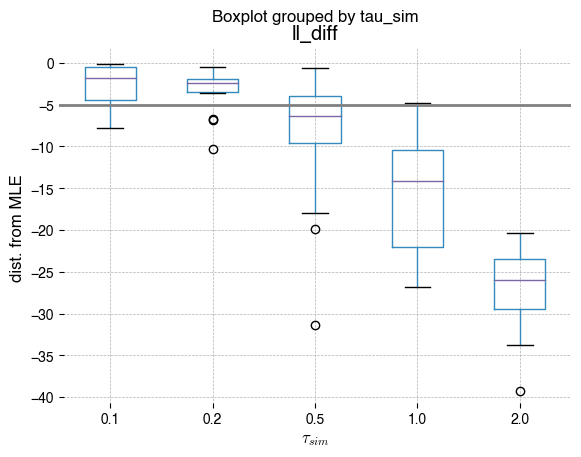

In [331]:
# plt.plot(est2[:,0]/100,est2[:,1],'ko',alpha=0.5,label=r'$\hat t$'); plt.xlabel(r'$\tau_{sim}$'); plt.axline((0,0),slope=1,color='grey'); plt.plot(est2[:,0]/100,est2[:,2],'r*',alpha=0.5,label=r'$\hat c$'); plt.axhline(0.6,color='r'); plt.legend();
# pd.DataFrame(data=est2,columns=['t_sim','tau_est','c_est','ll_diff']).assign(tau_sim=lambda x: x.t_sim/100).boxplot(column='tau_est',by='tau_sim'); [plt.axhline(t,color='grey',linestyle='--') for t in [0.1,0.2,0.5]]; plt.plot(np.repeat(range(1,6),20),est2[:,2],'r*',alpha=0.5,label=r'$\hat c$'); plt.axhline(0.6,color='red'); plt.legend()
# pd.DataFrame(est2,columns=['tau_sim','t_est','c_est','ll_diff']).assign(tau_est=lambda x: x.t_est*100).boxplot(column='tau_est',by='tau_sim'); plt.xlabel(r'$\tau_{sim}$'); plt.ylabel(r'$\hat \tau$'); plt.box(False); plt.axline((1,10),slope=20,color='grey')
pd.DataFrame(data=est2,columns=['t_sim','tau_est','c_est','ll_diff']).assign(tau_sim=lambda x: x.t_sim/100).boxplot(column='ll_diff',by='tau_sim'); plt.xlabel(r'$\tau_{sim}$'); plt.ylabel('dist. from MLE'); plt.box(False); plt.axhline(-5,color='grey')
# plt.hist(np.hstack((dcoaltime/ninds**2, np.diag(coaltimemat))),bins=15); plt.xlabel('within deme coalescence times')
# np.sum(est2[:20,1]==0), np.sum(est2[20:40,1]==0), np.sum(est2[40:60,1]==0), np.sum(est2[60:80,1]==0), np.sum(est2[80:,1]==0)

array([0.65637417])

In [1874]:
# plt.hist(dcoaltime/ninds**2); plt.axvline(50,color='r')
# 10**-1.17664578/np.mean(1/sp_graph.q), 0.18/1.169, 0.42
# plt.hist(np.ravel(1/sp_graph.q)); plt.axvline(0.18,color='r')

array([0.01421034, 0.15229986, 0.09454647, 0.05152626, 0.02738697])

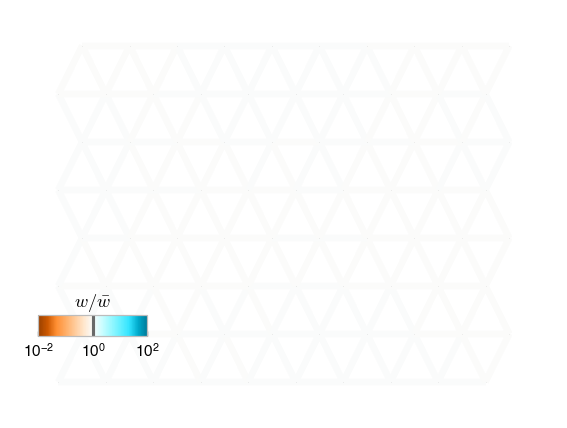

In [1171]:
fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, obj, projection=ccrs.Mercator(), edge_width=4, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=12, cbar_ticklabelsize=10)
v.draw_edges(use_weights=True); v.draw_edge_colorbar(); 
# ax.scatter(v.grid[53,0],v.grid[53,1],marker='x',color='b'); ax.scatter(v.grid[56,0],v.grid[56,1],marker='x',color='b');
for i in range(sp_graph.n_observed_nodes):
        ax.scatter(v.grid[i,0],v.grid[i,1],marker='o',color='grey',s=15/sp_graph.q[i])

# plt.plot(defq, jtq, 'ko'); plt.plot(defq,defq,ls='-',color='grey');
# plt.plot(jtw0, jtw, 'ko'); plt.plot(defq,defq,ls='-',color='grey');

LinAlgError: 24-th leading minor of the array is not positive definite

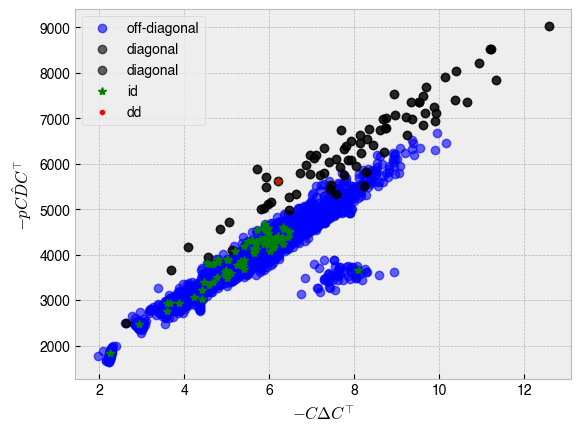

In [13]:
# sp_graph = FEEMSmix_SpatialGraph(gen_test_2, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=0.)
# obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
c = 0.5; tau = 0.2; lrn = [(23,56)]

C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T

resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag

migmat = deepcopy(sp_graph.W.todense()); np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(sp_graph.n_observed_nodes).reshape(-1,1)))
probmat = sp.linalg.expm(migmat*tau)

s = lrn[0][0]; d = lrn[0][1]

onehot = np.zeros(sp_graph.n_observed_nodes); onehot[s] = 1
ps = np.ravel(onehot @ probmat)

onehot[s] = 0; onehot[d] = 1
pd = np.ravel(onehot @ probmat)

# for i in range(0,sp_graph.n_observed_nodes):
#     for j in range(i+1,sp_graph.n_observed_nodes):
#         resmat[i,j] = Rmat[i,s] * (ps[j] - ps[i]*ps[j] - pd[i]*ps[j] - c*ps[i]*pd[j] - c*pd[i]*pd[j] + c*pd[j] \
#                                 - 0.5*c*pd[i] - 0.5*ps[i] + 0.5*c*pd[i]**2 + 0.5*ps[i]**2 + 0.5*pd[i]*ps[i] + 0.5*c*pd[i]*ps[i]) + \
#                     Rmat[j,s] * (ps[i] + c*pd[i] - c*pd[i]*pd[j] - ps[i]*pd[j] - c*pd[i]*ps[j] - ps[i]*ps[j] \
#                                 - 0.5*c*pd[j] - 0.5*ps[j] + 0.5*c*pd[j]**2 + 0.5*ps[j]**2 + 0.5*pd[j]*ps[j] + 0.5*c*pd[j]*ps[j]) + \
#                     Rmat[s,d] * (pd[i]*ps[j] - c*pd[i]*ps[j] + ps[i]*pd[j] - c*ps[i]*pd[j] + 2*c*pd[i]*pd[j] - 2*c**2*pd[i]*pd[j] \
#                                 - 0.5*pd[i]*ps[i] + 0.5*s*pd[i]*ps[i] - 0.5*c*pd[i]**2 + 0.5*c**2*pd[i]**2 - 0.5*pd[j]*ps[j] \
#                                 + 0.5*c*pd[j]*ps[j] - 0.5*c*pd[j]**2 + 0.5*c**2*pd[j]**2) + \
#                     Rmat[i,d] * (c*ps[i]*pd[j] - ps[i]*pd[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[j] - c*pd[j] \
#                                 - 0.5*c*pd[i]*ps[i] + 0.5*pd[i]*ps[i] - 0.5*c*pd[i]**2 + 0.5*pd[i]**2 - 0.5*pd[i] + 0.5*c*pd[i]) + \
#                     Rmat[j,d] * (c*pd[i]*ps[j] - pd[i]*ps[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[i] - c*pd[i] \
#                                 - 0.5*c*pd[j]*ps[j] + 0.5*pd[j]*ps[j] - 0.5*c*pd[j]**2 + 0.5*pd[j]**2 - 0.5*pd[j] + 0.5*c*pd[j]) + \
#                     Rmat[i,j] * (ps[i]*ps[j] + pd[i]*ps[j] - ps[j] + ps[i]*pd[j] + pd[i]*pd[j] - pd[j] - ps[i] - pd[i] + 1) + \
#                     (ps[i] + ps[j] + c*pd[i] + c*pd[j] - 4*c*pd[i]*ps[j])/sp_graph.q[s] + \
#                     ((1-c)*pd[i] + (1-c)*pd[j])/sp_graph.q[d] + \
#                     (1 - ps[i] - pd[i])/sp_graph.q[i] + (1 - ps[j] - pd[j])/sp_graph.q[j] + 4*tau
#         resmat[j,i] = resmat[i,j]

for i in range(0,sp_graph.n_observed_nodes):
        for j in range(i,sp_graph.n_observed_nodes):
            pid = pd[i]; pjd = pd[j]
            pis = ps[i]; pjs = ps[j]
            resmat[i,j] = (1.*pid - 1.*c*pid + 1.*pjd - 1.*c*pjd)/sp_graph.q[d] + (1. - 1.*pid - 1.*pis)/sp_graph.q[i] + \
                (1. + pid - 2.*pis**2 - 2.*pjd - pid*pjd + 1.*pjd**2 - 1.*pjs - pid*pjs + 2.*pis*pjs + 1.*pjd*pjs)/sp_graph.q[j] + \
                (1.*c*pid + 1.*pis - 2.*pis**2 + 1.*c*pjd + 1.*pjs + 2.*pis*pjs)/sp_graph.q[s] + \
                (-0.5*pid + 0.5*c*pid + 0.5*pid**2 - 0.5*c*pid**2 + 0.5*pid*pis - 0.5*c*pid*pis + 1.*pjd - 1.*c*pjd - 1.*pid*pjd + 1.*c*pid*pjd - 1.*pis*pjd + 1.*c*pis*pjd)*Rmat[i,d] + \
                (1. - 1.*pid - 1.*pis - 1.*pjd + 1.*pid*pjd + 1.*pis*pjd - 1.*pjs + 1.*pid*pjs + 1.*pis*pjs)*Rmat[i,j] + \
                (-0.5*c*pid + 0.5*c*pid**2 - 0.5*pis + 0.5*pid*pis + 0.5*c*pid*pis + 0.5*pis**2 + 1.*c*pjd - 1.*c*pid*pjd - 1.*c*pis*pjd + 1.*pjs - 1.*pid*pjs - 1.*pis*pjs)*Rmat[i,s] + \
                (1.*pid - 1.*c*pid - 0.5*pjd + 0.5*c*pjd - 1.*pid*pjd + 1.*c*pid*pjd + 0.5*pjd**2 - 0.5*c*pjd**2 - 1.*pid*pjs + 1.*c*pid*pjs + 0.5*pjd*pjs - 0.5*c*pjd*pjs)*Rmat[j,d] + \
                (1.*c*pid + 1.*pis - 1.*pis**2 - 0.5*c*pjd - 1.*c*pid*pjd - 1.*pis*pjd + 0.5*c*pjd**2 - 0.5*pjs - 1.*c*pid*pjs + 0.5*pjd*pjs + 0.5*c*pjd*pjs + 0.5*pjs**2)*Rmat[j,s] + \
                (-0.5*c*pid**2 + 0.5*c**2*pid**2 - 0.5*pid*pis + 0.5*c*pid*pis + 2.*c*pid*pjd - 2.*c**2*pid*pjd + 1.*pis*pjd - 1.*c*pis*pjd - 0.5*c*pjd**2 + 0.5*c**2*pjd**2 + 1.*pid*pjs - 1.*c*pid*pjs - 0.5*pjd*pjs + 0.5*c*pjd*pjs)*Rmat[s,d] + \
                4*tau + 2*pid*tau - 8*pis**2*tau - 2*pjd*tau - 2*pid*pjd*tau + 2*pjd**2*tau - 2*pid*pjs*tau + 8*pis*pjs*tau + 2*pjd*pjs*tau
            resmat[j,i] = resmat[i,j]

# resmat -= np.diag(np.repeat(2,sp_graph.n_observed_nodes))

# D = squareform(pdist(sp_graph.frequencies*np.sqrt(sp_graph.mu*(1-sp_graph.mu)),"sqeuclidean"))/1000
D = np.ones(sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(sp_graph.S).reshape(1,-1) + np.diag(sp_graph.S).reshape(-1,1) @ np.ones(sp_graph.n_observed_nodes).reshape(1,-1) - 2*sp_graph.S
plt.plot((-C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)].T,(-sp_graph.n_snps*C@D@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.ylabel(r'$-pC\hat D C^\top$'); plt.xlabel(r'$-C\Delta C^\top$'); 
plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot((-C@resmat@C.T)[:,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[:,lrn[0][1]-1],'g*',label='id'); 
plt.plot((-C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[lrn[0][1]-1,lrn[0][1]-1],'r.',label='dd'); plt.legend(); 
plt.title(r'$c=${}, $\tau=${}, $\ell=${}, $R^2=${}'.format(c,tau,round(-sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -C @ resmat @ C.T),2),round(sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2],5))); plt.box(False)

# plt.plot((-C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)].T,(2*sp_graph.n_snps*C@sp_graph.S@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.ylabel(r'$2pC\hat \Sigma C**\top$'); plt.xlabel(r'$-C\Delta C**\top$'); 
# plt.plot(np.diag(-C@resmat@C.T),np.diag(2*sp_graph.n_snps*C@sp_graph.S@C.T),'ko',label='diagonal',alpha=0.6); 
# plt.plot((-C@resmat@C.T)[:,lrn[0][1]-1],(2*sp_graph.n_snps*C@sp_graph.S@C.T)[:,lrn[0][1]-1],'g+',label='id'); 
# plt.plot((-C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],(2*sp_graph.n_snps*C@sp_graph.S@C.T)[lrn[0][1]-1,lrn[0][1]-1],'rx',label='dd'); plt.legend(); 
# plt.title(r'$c=${}, $\tau=${}, $\ell=${}, $R**2=${}'.format(c,tau,round(-sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T),2),round(sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)],2*sp_graph.n_snps*(C @ sp_graph.S @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2],5))); plt.box(False)
# plt.title(r'$c=${}, $\tau=${}, $R**2=${}'.format(c,tau,round(sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],2*sp_graph.n_snps*(C @ sp_graph.S @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)])[2],5))); plt.box(False)

### EEMS formulation in eqn S15 (but with FEEMS parameters) -> fit is not great...abandoning it

$-LDL^\top \sim \mathcal{W_{n-1}}(-\frac{\sigma^2}{p}L \Delta L^\top, p)$

where $\Delta = JBJ^\top + \frac{1}{2}Jq1_n^\top + \frac{1}{2}1_n q^\top J^\top- \text{diag}(Jq)$ and $B = R = 1h^\top + h1^\top-2H$, and $H = L^\dagger + 11^\top/c$

In [1911]:
# plt.scatter(-2*np.diag(obj.Linv)+sp_graph.s2,np.diag(coaltimemat)); plt.axline((0,80),slope=8,color='grey')
# sp.stats.linregress(-2*np.diag(obj.Linv)+sp_graph.s2,np.diag(coaltimemat))
# plt.imshow(resmat-resmat2,cmap='RdBu_r'); plt.colorbar()
# sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=0.)
# cmesh = np.linspace(0,1,25); tmesh = np.append((np.linspace(1e-4, .6, num=20)**np.exp(1)),(np.linspace(1,1.2,5,endpoint=False)[::-1]))
cmesh = np.linspace(0,1,20); tmesh = np.linspace(2,20,20)
ll2d = np.zeros((len(cmesh),len(tmesh))); r2d = np.zeros((len(cmesh),len(tmesh))); r2dnd = np.zeros((len(cmesh),len(tmesh)))
for ic in range(len(cmesh)):
    for it in range(len(tmesh)):
        ll2d[ic,it], r2d[ic,it], r2dnd[ic,it] = get_FEEMS_demes_nll_w_c_t([cmesh[ic],tmesh[it]],sp_graph,obj,[(23,56)])
        # ll2d[ic,it] = get_FEEMS_demes_nll_w_c_t([cmesh[ic],tmesh[it]],sp_graph,obj,lrn)

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:195: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:198: RuntimeWarning: invalid value encountered in sqrt
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [31]:
# from matplotlib import colormaps
# llprof = np.array([[  0.        ,   0.81120107,   2.13851571,   3.92905458,6.13491268,   8.71262467,  11.62269394,  14.82918337,18.29935788,  22.00337068,  25.91398673,  30.00633797,34.25770588,  38.64732752,  43.15622215,  47.76703557,52.4639001 ,  57.23230832,  62.05899887,  66.93185292, 71.83980032,  76.77273404,  81.72143239,  86.67748788, 91.63324237,  96.58172754, 101.51661053, 106.43214394,111.32311997, 116.18482831], [  0.        ,   0.9434912 ,   2.32813827,   4.10981385, 6.24857706,   8.70820167,  11.4557698 ,  14.46132037, 17.69754336,  21.13951288,  24.76445304,  28.55153173,32.48167837,  36.53742226,  40.70274862,  44.96297009, 49.30461166,  53.71530727,  58.18370672,  62.69939167,67.25279957,  71.83515473,  76.43840565,  81.05516801,85.67867266,  90.30271806,  94.92162684,  99.53020597,104.12371018, 108.6978084 ], [ 0.        ,  0.30035353,  0.90531391,  1.78858599,  2.925883  ,4.29476475,  5.87449037,  7.64588409,  9.59121265, 11.69407331,13.93929131, 16.31282593, 18.8016843 , 21.39384234, 24.07817202,26.84437454, 29.68291882, 32.58498484, 35.54241149, 38.54764839,41.5937115 , 44.67414215, 47.78296919, 50.91467398, 54.06415808,57.22671335, 60.3979942 , 63.57399205, 66.75101156, 69.92564859], [ 0.        ,  0.45950805,  1.0754388 ,  1.83620506,  2.73095183,3.74951068,  4.88235708,  6.12057032,  7.45579605,  8.88021108,10.38649044, 11.96777644, 13.61764971, 15.33010199, 17.09951065,18.92061477, 20.78849269, 22.69854101, 24.64645481, 26.62820913, 28.64004164, 30.67843634, 32.74010822, 34.82198902, 36.92121368, 39.03510779, 41.16117574, 43.29708962, 45.44067877, 47.58992008], [ 0.        ,  0.24798346,  0.63844338,  1.16185256,  1.80923149,2.57211664,  3.44253071,  4.41295468,  5.47630147,  6.62589132,7.85542847,  9.15897933, 10.53095188, 11.96607634, 13.45938688,15.00620449, 16.6021208 , 18.24298283, 19.92487863, 21.64412378,23.39724862, 25.18098623, 26.99226112, 28.82817853, 30.68601436,32.56320569, 34.45734179, 36.36615568, 38.28751615, 40.21942027],[ 0.        ,  0.09267444,  0.32959968,  0.69888674,  1.18945486,1.79097991,  2.4938458 ,  3.28909896,  4.16840551,  5.12401104,6.14870298,  7.23577516,  8.3789947 ,  9.5725709 , 10.81112612,12.08966851, 13.4035664 , 14.74852447, 16.12056127, 17.51598831,18.93139041, 20.36360744, 21.80971708, 23.26701883, 24.73301902, 26.20541679, 27.68209096, 29.16108786, 30.64060984, 32.1190046 ] ])
# cols = colormaps.get_cmap('autumn').resampled(6)
# plt.figure(dpi=120)
# for i in range(6):
#     plt.plot(tmesh*100, -llprof[i,:], '-o', color=cols(i), alpha=0.8, label=r'{:d}, $\hat c=${:.2f}'.format([0,1,2,5,10,50][i],[0.80,0.80,0.72,0.62,0.62,0.50][i])); 
# plt.ylabel('log-lik units'); plt.xlabel(r'$\tau$'); plt.legend(title=r'$\tau_{sim}$'); 

# coords = pd.read_csv("/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/warblers/data/arctic.coords", header=None)
# outer = np.array([[-65.00, 72.00],[55.00, 72.00],[155.00, 58.00],[-147.00, 58.00],[-65.00, 72.00]])
# outer, edges, grid, ipmap = prepare_graph_inputs(coord=np.array(coords), 
#                                              ggrid="/Users/vivaswatshastry/src/feems/feems/data/grid_100.shp",
#                                              translated=False, 
#                                              buffer=10,
#                                              outer=None)
# arc_graph = FEEMSmix_SpatialGraph(gen_test_2[np.random.randint(0,1200,41),][:,np.random.randint(0,1000,100)], np.array(coords), grid, edges); arc_obj = FEEMSmix_Objective(arc_graph);
# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.AzimuthalEquidistant())  
# v = Viz(ax, arc_graph, arc_obj, projection=ccrs.AzimuthalEquidistant(), edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5, obs_node_size=1.5, sample_pt_color="black", cbar_ticklabelsize=10, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8, abs_max=2)
# v.draw_edges(use_weights=False); v.draw_map(latlong=False); v.draw_obs_nodes(); v.draw_samples()

In [3698]:
# np.where(ll2d==np.min(ll2d)), np.where(r2d==np.min(r2d)), np.where(r2dnd==np.min(r2dnd)), np.argmin(np.abs(tmesh-10)), np.argmin(np.abs(cmesh-0.6))  

# (-ll2d[(-ll2d+np.min(ll2d))>-5]+np.min(ll2d))
# cmesh[np.where((-ll2d+np.min(ll2d))>-5)[1]]*(-ll2d[(-ll2d+np.min(ll2d))>-5]+np.min(ll2d))
# np.mean(50/np.diag(coaltimemat))

# cmesh = np.linspace(0,0.9,30); tmesh = np.linspace(0,0.8,30)
# ll2d = np.zeros((len(cmesh),len(tmesh)))

# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=10, corridor_w=1e-2, barrier_w=1e-2, barrier_prob=1., corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=3, barrier_endpt=7, n_samples_per_node=15)
# gen_test_2 = simulate_genotypes_w_admixture(graph_def, target_n_snps=800, n_print=700, long_range_nodes=[(23,56)], admixture_props=[0.5], time_of_adm=[10], n_e=100, dump=False)
# sp_graph = FEEMSmix_SpatialGraph(gen_test_2, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3., optimize_q=None, lamb_q=1., verbose=False); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

# plt.figure(dpi=120)
# for i, t in enumerate([0.0000001, 1, 5, 10, 50]):
#     gen_test_2 = simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=700, long_range_nodes=[(23,56)], admixture_props=[0.6], time_of_adm=[t], Ne=1000)
#     sp_graph = FEEMSmix_SpatialGraph(gen_test_2, coord_def, grid_def, edge_def)
#     sp_graph.fit(lamb=3., optimize_q=None, lamb_q=3., verbose=False); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

#     for ic in range(len(cmesh)):
#         for it in range(len(tmesh)):
#             ll2d[ic,it], _, _ = get_FEEMS_demes_nll_w_c_t([cmesh[ic],tmesh[it]],sp_graph,obj,[(23,56)]) 
#     plt.imshow(-ll2d+np.min(ll2d),cmap='Blues',vmin=-20); plt.colorbar(); plt.yticks(ticks=range(0,len(cmesh),3),labels=np.round(cmesh[::3],2)); plt.xticks(ticks=range(0,len(tmesh),3),labels=np.round(tmesh[::3],2)); plt.axhline(20,color='k'); plt.axvline(np.argmin(np.abs(tmesh-t/100)),color='k'); plt.ylabel(r'$c$'); plt.xlabel(r'$\tau$'); plt.show()
    # print("results:")
    # print(t, np.where(ll2d==np.min(ll2d)), [ll2d[np.where(ll2d==np.min(ll2d))[0],:]-np.min(ll2d)])

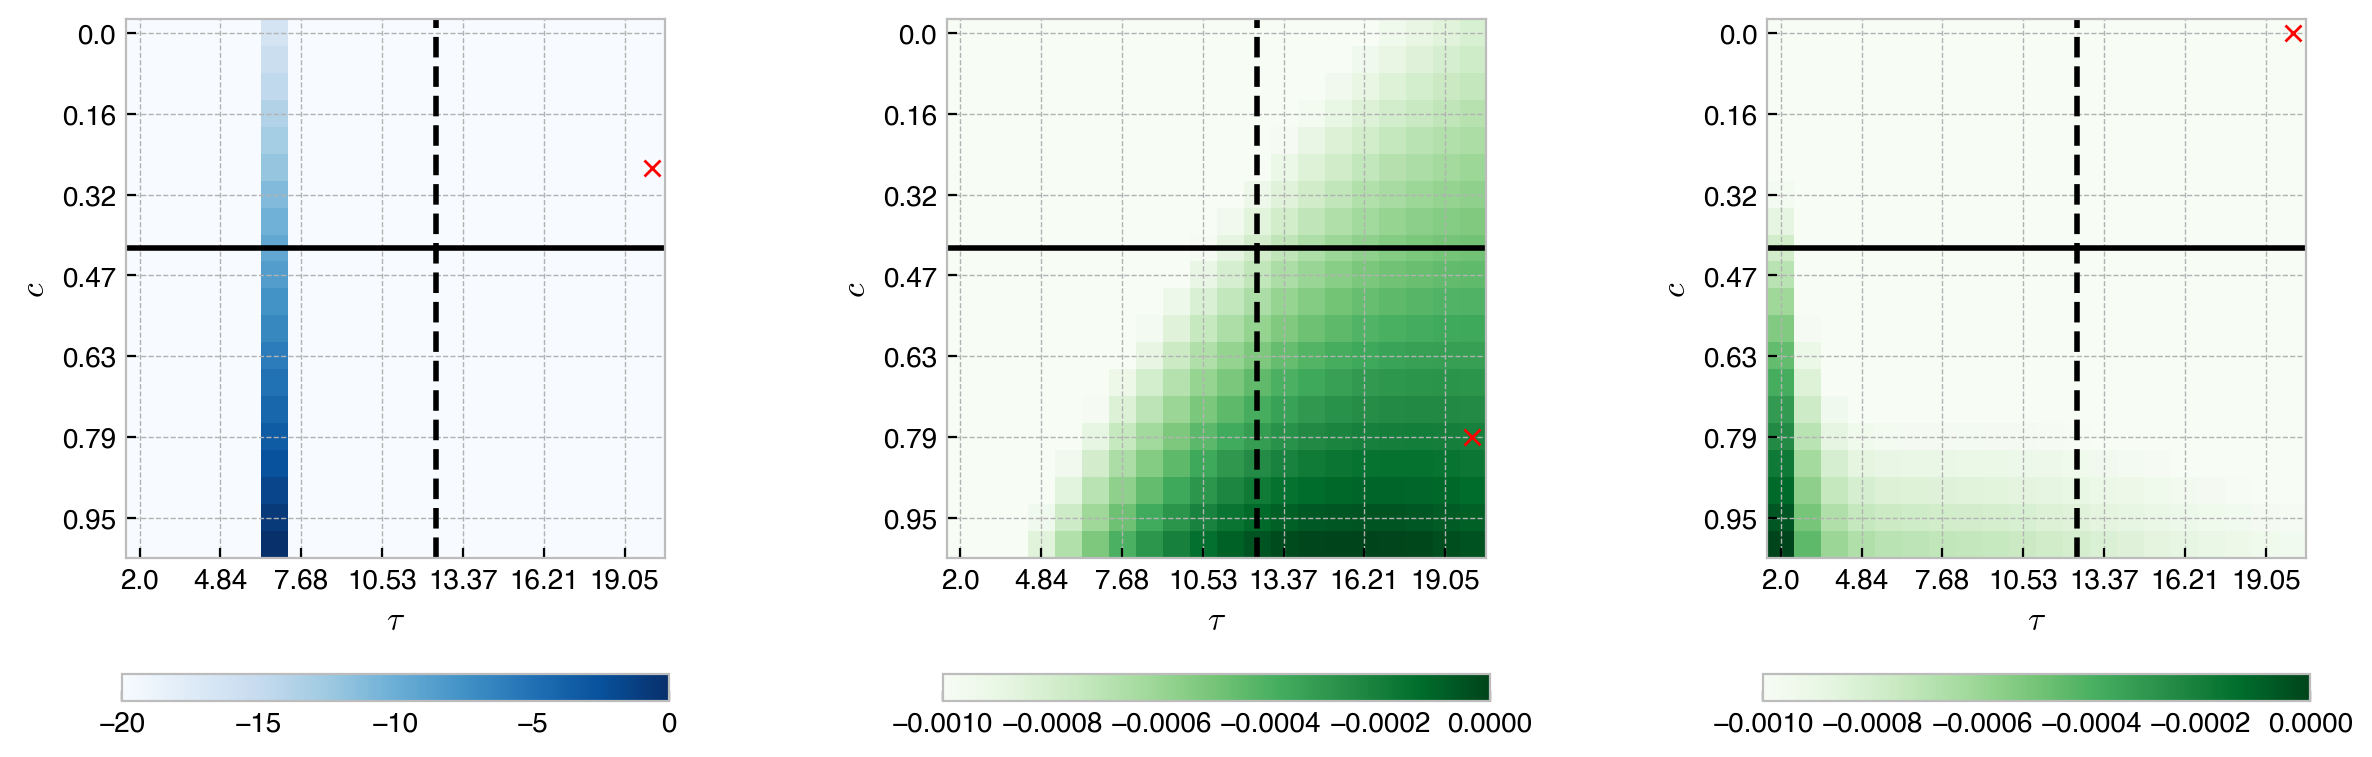

In [1913]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5),dpi=200)
im = ax1.imshow(-ll2d+np.min(ll2d),cmap='Blues',vmin=-20); plt.colorbar(im, ax=ax1, orientation='horizontal', shrink=0.8); ax1.set_xlabel(r'$\tau$'); ax1.set_ylabel(r'$c$'); ax1.set_yticks(ticks=range(0,len(cmesh),3),labels=np.round(cmesh[::3],2)); ax1.set_xticks(ticks=range(0,len(tmesh),3),labels=np.round(tmesh[::3],2)); ax1.plot(19,5,'rx'); ax1.axhline(8,color='k'); ax1.axvline(11,color='k',ls='--'); #plt.show()
im = ax2.imshow(-r2d+np.min(r2d),cmap='Greens',vmin=-0.001); plt.colorbar(im, ax=ax2, orientation='horizontal', shrink=0.8); ax2.set_xlabel(r'$\tau$'); ax2.set_ylabel(r'$c$'); ax2.set_yticks(ticks=range(0,len(cmesh),3),labels=np.round(cmesh[::3],2)); ax2.set_xticks(ticks=range(0,len(tmesh),3),labels=np.round(tmesh[::3],2)); ax2.plot(19,15,'rx'); ax2.axhline(8,color='k'); ax2.axvline(11,color='k',ls='--'); #plt.show()
im = ax3.imshow(-r2dnd+np.min(r2dnd),cmap='Greens',vmin=-0.001); plt.colorbar(im, ax=ax3, orientation='horizontal', shrink=0.8); plt.xlabel(r'$\tau$'); plt.ylabel(r'$c$'); plt.yticks(ticks=range(0,len(cmesh),3),labels=np.round(cmesh[::3],2)); plt.xticks(ticks=range(0,len(tmesh),3),labels=np.round(tmesh[::3],2)); plt.plot(19,0,'rx'); plt.axhline(8,color='k'); plt.axvline(11,color='k',ls='--'); #plt.show()

#### Compute coalescent times under different $\tau$ to see if there is signal in the data

Text(0.5, 0, '$\\log_{10}(T_{ss})$')

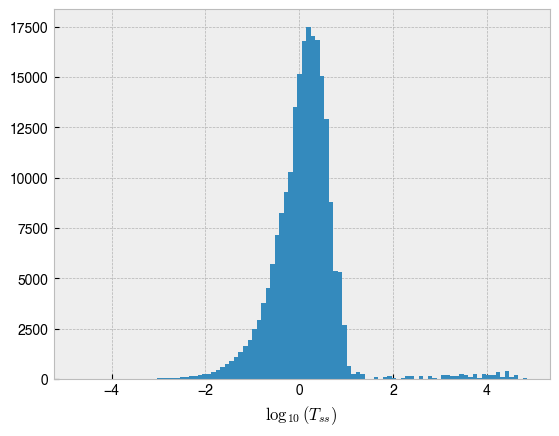

In [1609]:
# mytree = []
# for j in np.arange(1000):
#     mytree.append(tskit.load("/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/trees/tree{:d}_8x10_c0.6_t10.tree".format(j)))
# ct5656 = np.zeros((30,30)) # 56: 1680, 1710
ct5656 = []
for snp in range(1000):
    tt = mytree[snp].first()
    for i in range(1680,1710):
        for j in range(i+1,1710):
            # ct5656[i-1680,j-1680] += tt.tmrca(i,j)
            ct5656.append(tt.tmrca(i,j))
# ct5656 += ct5656.T; ct5656 /= 1000
# plt.hist(ct5656[np.tril_indices(30,-1)],bins=20)
plt.hist(np.log10(np.array(ct5656)[:len(ct5656):2]),bins=100); plt.xlabel(r'$\log_{10}(T_{ss})$')
# np.where(np.array(ct5656)>1e4)
# np.sum((ct5656<10) & (ct5656>0))
# 1-np.sum(np.array(ct5656)<10)/len(ct5656)

In [416]:
1080/36

30.0

In [423]:
# population_configurations = [
#             msprime.PopulationConfiguration(sample_size=30, initial_size=1) for i in range(36)]
# demography = msprime.Demography.from_old_style(population_configurations=population_configurations,
#                                                    migration_matrix=np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist()),
#                                                    ignore_sample_size=True, 
#                                                    Ne=1)
# demography.add_mass_migration(time=0.00001, source=27, dest=8, proportion=0.5)
ts = msprime.sim_ancestry(
        samples=[msprime.SampleSet(15,i,ploidy=2) for i in range(36)],
        demography=demography,
        sequence_length=700,
        recombination_rate=0.01,  # No recombination
        record_migrations=False, record_full_arg=False,
        # model=[msprime.DiscreteTimeWrightFisher(duration=time_of_adm[0]+1), msprime.StandardCoalescent()],
)

# print('done')
coaltimetsnull = np.zeros((36,36))
for i in range(36):
    print(i,end=', ')
    for j in range(i,36):
        coaltimetsnull[i,j] = ts.divergence([ts.samples(population=i),ts.samples(population=j)],mode='branch')/2
        coaltimetsnull[j,i] = coaltimetsnull[i,j]

# coaltimets3 = np.zeros((80,80))
# for i in range(80):
#     print(i,end=', ')
#     for j in range(i,80):
#         coaltimets3[i,j] = ts.divergence([ts.samples(population=i),ts.samples(population=j)],mode='branch')/2
#         coaltimets3[j,i] = coaltimets3[i,j]

# demography = msprime.Demography.from_old_style(population_configurations=population_configurations,
#                                                    migration_matrix=np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist())*0.1,
#                                                    ignore_sample_size=True, 
#                                                    Ne=100)
# demography.add_mass_migration(time=10, source=56, dest=23, proportion=0.5)
# ts = msprime.sim_ancestry(
#         samples=[msprime.SampleSet(15,i,ploidy=2) for i in range(80)],
#         demography=demography,
#         sequence_length=700,
#         recombination_rate=0.01,  # No recombination
#         record_migrations=False, record_full_arg=False,
#         num_replicates=2
#         # model=[msprime.DiscreteTimeWrightFisher(duration=time_of_adm[0]+1), msprime.StandardCoalescent()],
# )
# print('done')

# coaltimets10 = np.zeros((80,80))
# for i in range(80):
#     print(i,end=', ')
#     for j in range(i,80):
#         coaltimets10[i,j] = ts.divergence([ts.samples(population=i),ts.samples(population=j)],mode='branch')/2
#         coaltimets10[j,i] = coaltimets10[i,j]

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 

In [337]:
coaltimetsnull

NameError: name 'coaltimetsnull' is not defined

In [341]:
def plot_two_matrices(x, y, d, labs):
    o = x.shape[0]
    plt.plot((C@x@C.T)[np.tril_indices(o-1,-1)],(C@y@C.T)[np.tril_indices(o-1,-1)].T,'ko',alpha=0.3); plt.plot(np.diag(C@x@C.T),np.diag(C@y@C.T),'b*',alpha=0.8,label='diag.'); plt.plot((C@x@C.T)[:,d-1],(C@y@C.T)[:,d-1],'g*',label='id'); plt.axline((-1,-1),slope=1,color='grey'); 
    # plt.title(sp.stats.wishart.logpdf(-C@x@C.T,800,-C@y@C.T))
    plt.xlabel(labs[0]); plt.ylabel(labs[1])
    plt.plot((C@x@C.T)[d-1,d-1],(C@y@C.T)[d-1,d-1],'ro',label='dd'); plt.legend(loc='upper left'); plt.box(False); plt.show()

    plt.plot(x[np.tril_indices(o,-1)].T,y[np.tril_indices(o,-1)].T,'ko',alpha=0.6); plt.plot(x[d,d],y[d,d],'ro',label='dd',alpha=0.6)
    plt.plot(x[:,d],y[d,:],'g*',alpha=0.8,label=r'id'); #plt.axline((1,1),slope=1,color='grey')
    plt.plot(np.diag(x),np.diag(y),'bo',alpha=0.8,label=r'diag.'); plt.legend(loc='upper left'); 
    plt.xlabel(labs[0]); plt.ylabel(labs[1])

In [340]:
D = np.ones(sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(sp_graph.S).reshape(1,-1) + np.diag(sp_graph.S).reshape(-1,1) @ np.ones(sp_graph.n_observed_nodes).reshape(1,-1) - 2*sp_graph.S

Rmat = -2*obj_null.Linv + np.reshape(np.diag(obj_null.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj_null.Linv),(1,-1))
Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph_null.q,(1,-1))).T

resmat = Rmat + (Q1mat + Q1mat.T) -np.diag(np.diag(Q1mat + Q1mat.T))

c = 0.0; tau = 0.0

resmat[s,d] = (0.5*c**2-1.5*c+1)*Rmat[s,d] + (1+c)/sp_graph_null.q[s] + (1-c)/sp_graph_null.q[d]
resmat[d,s] = resmat[s,d]

## id
for i in set(range(sp_graph.n_observed_nodes))-set([s,d]):
    resmat[i,d] = (1-c)*(Rmat[i,d]) + c*Rmat[i,s] + 0.5*(c**2-c)*Rmat[s,d] + 1/sp_graph_null.q[i] + (1-c)/sp_graph_null.q[d] + c/sp_graph_null.q[s]
    resmat[d,i] = resmat[i,d]

Tstar = Rmat + (Q1mat + Q1mat.T) - np.diag(np.diag(Q1mat + Q1mat.T))

dT0 = np.zeros_like(Tstar)
# dT0[s,d] = c*Tstar[s,s] - c*Tstar[s,d] + 0.5*(c**2-c)*Rmat[s,d] + 2*c/sp_graph.q[s]; dT0[d,s] = dT0[s,d]
for i in list(set(range(dT0.shape[0]))-set([s,d])):
    # dT0[i,d] = c*Tstar[i,s] - c*Tstar[i,d] + 0.5*(c**2-c)*Rmat[s,d]; dT0[d,i] = dT0[i,d]
    dT0[i,d] = c*Tstar[i,s] - c*Tstar[i,d]; dT0[d,i] = dT0[i,d]
dT0[d,d] = c*Tstar[s,s] - c*Tstar[d,d]
# dT0[d,d] = c**2*Tstar[s,s] + 2*c*(1-c)*Tstar[s,d] + (c**2-2*c)*Tstar[d,d]

dTt = -tau*(np.diag(1/sp_graph.q)@np.diag(np.diag(dT0)) + obj_null.Linv@dT0 + dT0@obj_null.Linv) + dT0
resmat_hao = Tstar+dTt#4*(Tstar+dTt)-np.diag(Tstar+dTt).reshape(-1,1)@np.ones(80).reshape(1,-1)-np.ones(80).reshape(-1,1)@np.diag(Tstar+dTt).reshape(1,-1)
resmat_hao[np.diag_indices_from(resmat_hao)] = 0

plot_two_matrices(D,resmat_hao,56,['',''])

NameError: name 'obj_null' is not defined

4.533234628132536

In [458]:
# H = msprime.sim_mutations(ts, rate=1e-3, model=msprime.BinaryMutationModel()).genotype_matrix()
# Hnew = H[:, ::2] + H[:, 1::2]
# sp_graph = FEEMSmix_SpatialGraph(Hnew.T, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=.3, optimize_q='n-dim', lamb_q=.1, verbose=False)
# obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

s = 22; d = 57; c = 0.213

# D = np.ones(sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(sp_graph.S).reshape(1,-1) + np.diag(sp_graph.S).reshape(-1,1) @ np.ones(sp_graph.n_observed_nodes).reshape(1,-1) - 2*sp_graph.S

Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T

resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag
# resmat[s,d] = (0.5*c**2-1.5*c+1)*Rmat[s,d] + (1+c)/sp_graph.q[s] + (1-c)/sp_graph.q[d]
resmat[s,d] = (0.5*c**2-1.5*c+1)*Rmat[s,d] + (1+c)*(1/sp_graph.q[s] + obj.Linv[s,s]) + (1-c)*(1/sp_graph.q[d] + obj.Linv[d,d])
resmat[d,s] = resmat[s,d]

## id
for i in set(range(sp_graph.n_observed_nodes))-set([s,d]):
    # resmat[i,d] = (1-c)*(Rmat[i,d]) + c*Rmat[i,s] + 0.5*(c**2-c)*Rmat[s,d] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[d] + c/sp_graph.q[s]
    resmat[i,d] = (1-c)*(Rmat[i,d]) + c*Rmat[i,s] + 0.5*(c**2-c)*Rmat[s,d] + (1/sp_graph.q[i] + obj.Linv[i,i]) + (1-c)*(1/sp_graph.q[d] + obj.Linv[d,d]) + c*(1/sp_graph.q[s] + obj.Linv[s,s])
    resmat[d,i] = resmat[i,d]

Tstar = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag

# c = 0.5; tau = 0.
dT0 = np.zeros_like(Tstar)
# dT0[s,d] = c*Tstar[s,s] - c*Tstar[s,d] + 0.5*(c**2-c)*Rmat[s,d] + 2*c/sp_graph.q[s]; dT0[d,s] = dT0[s,d]
dT0[s,d] = (0.5*c**2-1.5*c)*Rmat[s,d] + (1+c)*obj.Linv[s,s] + c/sp_graph.q[s] + (1-c)*obj.Linv[d,d] - c/sp_graph.q[d];  dT0[d,s] = dT0[s,d]
for i in list(set(range(dT0.shape[0]))-set([s,d])):
    # dT0[i,d] = c*Tstar[i,s] - c*Tstar[i,d] + 0.5*(c**2-c)*Rmat[s,d]; dT0[d,i] = dT0[i,d]
    dT0[i,d] = -c*Rmat[i,d] + c*Rmat[i,s] + 0.5*(c**2-c)*Rmat[s,d] + obj.Linv[i,i] + (-c/sp_graph.q[d] + (1-c)*obj.Linv[d,d]) + c*(1/sp_graph.q[s] + obj.Linv[s,s]); dT0[d,i] = dT0[i,d]
# dT0[d,d] = c*Tstar[s,s] - c*Tstar[d,d]
# dT0[d,d] = c**2*Tstar[s,s] + 2*c*(1-c)*Tstar[s,d] + (c**2-2*c)*Tstar[d,d]

dTt = -tau*(np.diag(1/sp_graph.q)@np.diag(np.diag(dT0)) + obj.Linv@dT0 + dT0@obj.Linv) + dT0
resmat_hao = Tstar+dTt#4*(Tstar+dTt)-np.diag(Tstar+dTt).reshape(-1,1)@np.ones(80).reshape(1,-1)-np.ones(80).reshape(-1,1)@np.diag(Tstar+dTt).reshape(1,-1)
resmat_hao[np.diag_indices_from(resmat_hao)] = 0

# -np.diag(coaltimets30).reshape(-1,1)@np.ones(80).reshape(1,-1)-np.ones(80).reshape(-1,1)@np.diag(coaltimets30).reshape(1,-1)
# plot_two_matrices(D,-0.5*obj.Linv + 0.25*(np.diag(obj.Linv).reshape(-1,1) @ np.ones(80).reshape(1,-1) + np.ones(80).reshape(-1,1) @ np.diag(obj.Linv).reshape(1,-1)) + 0.25*((1/sp_graph.q).reshape(-1,1)@np.ones(80).reshape(1,-1) + np.ones(80).reshape(-1,1)@(1/sp_graph.q).reshape(1,-1)),56,[r'$CTC^\top$ (simulated)',r'$C(\frac{1}{4}R+\frac{1}{2}(diag(q)1^\top+1diag(q)^\top))C^\top$ (estimated)'])
# plot_two_matrices(D,resmat_hao,56,[r'$C\hat D C^\top$',r'$C \hat \Delta C^\top$'])
# plot_two_matrices(np.array(resmat),coaltimetsnull,27,[r'$T$ (simulated)',r'$-L^\dagger-\frac{1}{2}diag(q)$'])
# plot_two_matrices(np.array(resmat),np.array(resmat_hao),56,[r'$CTC^\top$ (simulated)',r'$C(R+q1^\top+1q^\top-2diag(q))C^\top$ (estimated)'])

# 4*(Tstar+dTt)-np.diag(Tstar+dTt).reshape(-1,1)@np.ones(80).reshape(1,-1)-np.ones(80).reshape(-1,1)@np.diag(Tstar+dTt).reshape(1,-1)

# plt.plot((C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)].T,(C@D@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.ylabel(r'$-pC\hat D C^\top$'); plt.xlabel(r'$-C\Delta C^\top$'); plt.plot(np.diag(C@resmat@C.T),np.diag(C@D@C.T),'ko',alpha=0.6); plt.plot((C@resmat@C.T)[:,lrn[0][1]-1],(C@D@C.T)[:,lrn[0][1]-1],'g*',label='id'); 
# plt.plot((C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],(C@D@C.T)[lrn[0][1]-1,lrn[0][1]-1],'r.',label='dd'); plt.legend(loc='upper left'); plt.box(False)

# plt.plot((coaltimets30)[np.tril_indices(80,-1)],(obj.Linv)[np.tril_indices(80,-1)],'ko',alpha=0.3); plt.plot((coaltimets30)[56],(obj.Linv)[56],'b*',alpha=0.8,label=r'$T_{id}$'); plt.plot(np.diag(coaltimets30),np.diag(obj.Linv)+1/sp_graph.q,'ro',alpha=0.8,label=r'diag.'); plt.axline((0,1),slope=-3e-5,color='grey',ls='--')
# plt.xlabel('simulated'); plt.ylabel('estimated w/ FEEMS'); plt.title(r"$T'_{\tau=3}$"); plt.legend(loc='upper left'); 

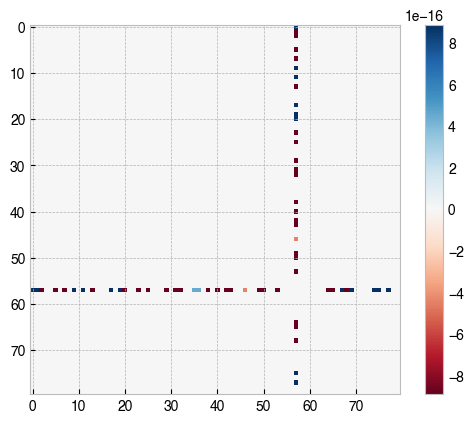

In [459]:
# resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag
# plt.imshow(resmat-resmat_hao,cmap='RdBu'); plt.colorbar()
# plt.plot(resmat[:,d]-resmat_hao[:,d],-(c**2-c)*Rmat[s,d]+((1+c)*obj.Linv[s,s]-(1-c)*obj.Linv[d,d]+np.diag(obj.Linv)),'ko'); plt.axline((2,2),slope=1,color='grey')
# resmat[s,d]-resmat_hao[s,d], (0.5*c**2-1.5*c)*Rmat[s,d] + (1+c)*obj.Linv[s,s] + c/sp_graph.q[s] + (1-c)*obj.Linv[d,d] - c/sp_graph.q[d]
# resmat[:,d] - resmat_hao[:,d]
# sp_graph.q_inv_diag[1,1]

(80, 80)

Finished SNP0...
Finished SNP50...
Finished SNP100...
Finished SNP150...
Finished SNP200...
Finished SNP250...
Finished SNP300...
Finished SNP350...
Finished SNP400...
Finished SNP450...
Finished SNP500...
Finished SNP550...


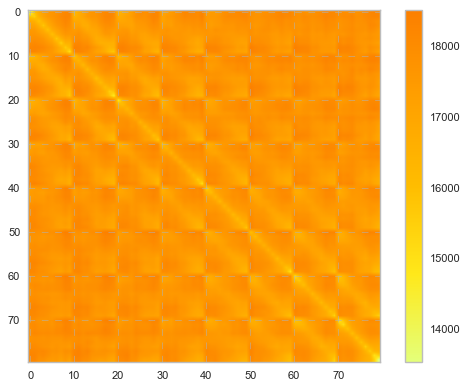

In [1601]:
# import tskit
# import pickle
# with open('/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/trees/coaltimemat_dict.pkl', 'wb') as fp:
#     pickle.dump(coaltimemat, fp)
#     print('dictionary saved successfully to file')
# with open('/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/trees/coaltimemat_dict.pkl', 'rb') as pickle_file:
#     coaltimemat = pickle.load(pickle_file)
# coaltimemat = {}
ndemes = 80; ninds = 2*15; nsnps = 600
def get_coaltimemat(t):
    mytree = []
    for j in np.arange(nsnps):
        mytree.append(tskit.load("/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/trees/tree{:d}_Ne100_8x10_c0.0_t{:d}.tree".format(j,t)))
    coaltimemat = np.zeros((ndemes,ndemes))
    for snp in range(nsnps):
        if snp % 50 == 0:
            print(f'Finished SNP{snp}...')
        tt = mytree[snp].first()
        for i in range(ninds*ndemes):
            for j in range(i+1,ninds*ndemes):
                coaltimemat[int(i/ninds),int(j/ninds)] += tt.tmrca(i,j)

    coaltimemat[np.diag_indices_from(coaltimemat)] /= np.sum(range(ninds))
    coaltimemat[np.triu_indices_from(coaltimemat,1)] /= ninds*ninds

    coaltimemat = coaltimemat + coaltimemat.T
    coaltimemat[np.diag_indices_from(coaltimemat)] *= 0.5
    coaltimemat /= nsnps
    plt.imshow(coaltimemat, cmap='Wistia'); plt.colorbar(); 
    return coaltimemat

coaltimenullhud = get_coaltimemat(0)

# plt.imshow(coaltimemat['null']-coaltimenull,cmap='RdBu'); plt.colorbar()
# plt.plot(np.diag(coaltimenull),np.diag(coaltimemat['null']),'o'); 

# coaltime1, coaltime2, coaltime5, coaltime10, coaltime50 = Parallel(n_jobs=5)(delayed(get_coaltimemat)(t) for t in [1,2,5,10,50])
# coaltime0, coaltime1, coaltime2, coaltime5, coaltime10, coaltime50 = Parallel(n_jobs=6)(delayed(get_coaltimemat)(t) for t in [0,1,2,5,10,50])
# coaltimemat[0] = coaltime0; coaltimemat[1] = coaltime1; coaltimemat[2] = coaltime2; coaltimemat[5] = coaltime5; coaltimemat[10] = coaltime10; coaltimemat[50] = coaltime50

9 19
29 39
49 59


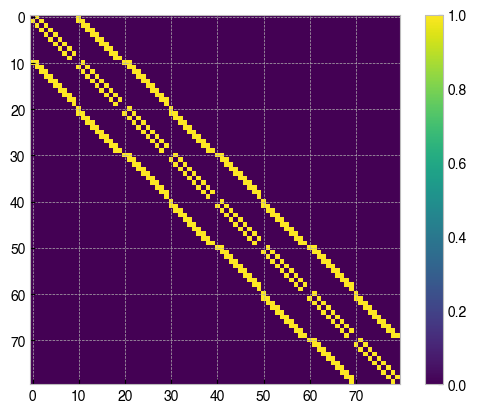

In [1037]:
rows = 8
cols = 10

# Initialize the adjacency matrix with zeros
adj_matrix = np.zeros((rows * cols, rows * cols), dtype=int)

# Iterate over each node in the grid
for i in range(rows):
    for j in range(cols):
        node_index = i * cols + j

        if i%2 == 0:
            # Connect to the right neighbor (if exists)
            if j < cols - 1:
                adj_matrix[node_index, node_index + 1] = 1
                adj_matrix[node_index + 1, node_index] = 1 

            # Connect to the bottom neighbor (if exists)
            if i < rows - 1:
                adj_matrix[node_index, node_index + cols] = 1
                adj_matrix[node_index + cols, node_index] = 1

                adj_matrix[node_index, node_index + cols - 1] = 1
                adj_matrix[node_index + cols - 1, node_index] = 1    
                
        else:
            # Connect to the right neighbor (if exists)
            if j < cols - 1:
                adj_matrix[node_index, node_index + 1] = 1
                adj_matrix[node_index + 1, node_index] = 1   

            # Connect to the bottom-right neighbor (if exists)
            if i < rows - 1 and j < cols - 1:
                adj_matrix[node_index, node_index + cols + 1] = 1
                adj_matrix[node_index + cols + 1, node_index] = 1   

                adj_matrix[node_index, node_index + cols] = 1
                adj_matrix[node_index + cols, node_index] = 1   

        if node_index%(2*cols) == 0:
            adj_matrix[node_index, node_index + cols - 1] = 0
            adj_matrix[node_index + cols - 1, node_index] = 0   

            if node_index > 0:
                adj_matrix[node_index - 1, node_index + cols - 1] = 1
                adj_matrix[node_index + cols - 1, node_index - 1] = 1
                print(node_index - cols - 1, node_index - 1)

plt.imshow(adj_matrix); plt.colorbar()

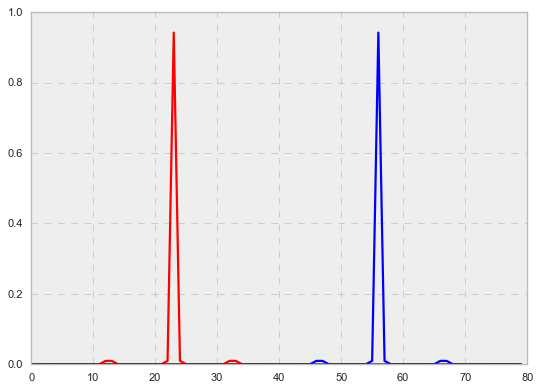

In [1323]:
migmat = np.zeros_like(coaltimenull); migmat[np.where(sp_graph.W.todense()>0)] = 1e-2
np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(sp_graph.n_observed_nodes).reshape(-1,1)))
# # migmat = np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist()); np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(80).reshape(-1,1)))
probmat = sp.linalg.expm(migmat); c = 0.6
# plt.imshow(np.log10(probmat),cmap='Blues',vmin=-3); plt.colorbar()
pd = probmat[56,:]#/probmat[56,:].sum(); 
ps = probmat[23,:]#/probmat[23,:].sum()
plt.plot(probmat[s],color='r'); plt.plot(probmat[d],'b')
# plt.plot(ps,'-.b'); plt.plot(pd,'-.r')
# eigvalue, eigvectors = np.linalg.eig(migmat*50)
# np.allclose(eigvectors @ np.eye(80)*(np.exp(eigvalue)) @ eigvectors.T,sp.linalg.expm(migmat*50))
# i, j = 56, 56
# problist = [ps[i]*ps[j] + c*ps[i]*pd[j] + c*pd[i]*ps[j] + c**2*pd[i]*pd[j], ps[j] - ps[i]*ps[j] - pd[i]*ps[j] - c*ps[i]*pd[j] - c*pd[j]*pd[i] + c*pd[j], ps[i] + c*pd[i] - c*pd[i]*pd[j] - ps[i]*pd[j] - c*pd[i]*ps[j] - ps[i]*ps[j], pd[i]*ps[j] - c*pd[i]*ps[j] + ps[i]*pd[j] - c*ps[i]*pd[j] + 2*c*pd[i]*pd[j] - 2*c**2*pd[i]*pd[j], c*ps[i]*pd[j] - ps[i]*pd[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[j] - c*pd[j], c*pd[i]*ps[j] - pd[i]*ps[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[i] - c*pd[i], pd[i]*pd[j] - 2*c*pd[i]*pd[j] + c**2*pd[i]*pd[j], ps[j]*ps[i] + pd[i]*ps[j] - ps[j] + ps[i]*pd[j] + pd[i]*pd[j] - pd[j] - ps[i] - pd[i] + 1]
# print('Tss,  Tis,  Tjs,  Tsd,  Tid,  Tjd,  Tdd,  Tij'); print(np.round(problist,3))
# problist = [ps[i]*ps[j], pd[i]*ps[j], (1-ps[i]-pd[i])*ps[j], ps[i]*pd[j], pd[i]*pd[j], (1-ps[i]-pd[i])*pd[j], ps[i]*(1-ps[j]-pd[j]), pd[i]*(1-ps[j]-pd[j]), (1-ps[i]-pd[i])*(1-ps[j]-pd[j])]
# plt.imshow(np.reshape(problist,(3,3)),cmap='RdBu',vmin=0,vmax=1); plt.colorbar()
# Q = np.diag(np.repeat(1/2000,80))
# fTij = np.zeros_like(coaltimenull)
# fTdd = []
# for t in np.linspace(0,50,1000):
#     # fTij += sp.linalg.expm(migmat*t) @ Q @ sp.linalg.expm(migmat*t)
#     fTdd.append((sp.linalg.expm(migmat*t) @ Q @ sp.linalg.expm(migmat*t))[23,56])
# # plt.imshow(fTij*50/50, vmin=0, cmap='Blues'); plt.colorbar(); plt.title(r'$\log F_{T_{i,j}}(T_{i,j} \leq 50)$')
# plt.plot(fTij[56,]/fTij[56].sum(),color=cols(5)); 
# np.dot(pd[list(set(range(coaltimenull.shape[0]))-set([s,d]))],coaltimenull[d][list(set(range(coaltimenull.shape[0]))-set([s,d]))]), coaltimenull[i,d]

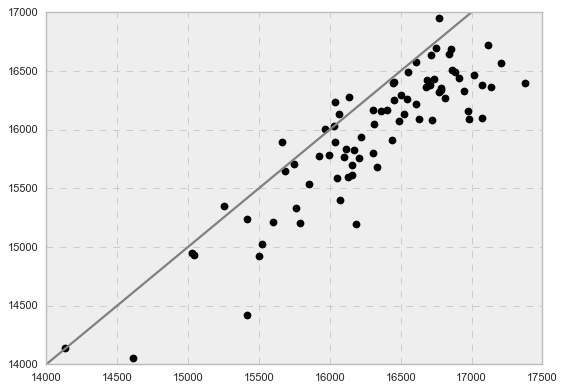

In [1144]:
# Ft = [(np.exp(2*migmat[22,22]*t)-1)*Q[56,56]/(2*migmat[22,22]) for t in range(0,200)]
# ft = [np.exp(2*migmat[22,22]*t)*Q[56,56] for t in range(0,200)]
# for t in range(1,10)[::-1]:
#     cumsum += t*ft[t-1] + (1-Ft[t-1])*cumsum
# print(cumsum, coaltimemat[10][56,56])
# plt.plot(range(0,200),[(np.exp(2*migmat[22,22]*t)-1)*Q[56,56]/(2*migmat[22,22]) for t in range(0,200)],'-',linewidth=2); plt.xlabel(r'$\tau$ (# of gens)'); plt.ylabel(r'$F_{T_{dd}}(T_{dd}\leq \tau)$ (CDF)')
# plt.plot(np.diag(coaltime10), np.diag(coaltimenull), 'ko'); plt.axline((1.6e4,1.6e4),slope=1,color='grey')
# plt.plot(range(0,200),[np.exp(2*migmat[22,22]*t)*Q[56,56] for t in range(0,200)],'-',linewidth=2); plt.xlabel(r'$t$ (# of gens)'); plt.ylabel(r'$f_{T_{dd}}(t)$ (PDF)')

In [2065]:
def get_coaltime_w_c_t(coaltimenull, c, tau, s, d):
    migmat = np.zeros_like(coaltimenull); migmat[np.where(sp_graph.W.todense()>0)] = 1e-3
    np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(sp_graph.n_observed_nodes).reshape(-1,1)))
    # migmat = np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist()); np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(80).reshape(-1,1)))
    probmat = sp.linalg.expm(migmat*tau)

    ps = probmat[s,:]
    
    pd = probmat[d,:]

    # Q = np.diag(np.repeat(1/2000,coaltimenull.shape[0]))
    # ft = []; Ft = []
    # for t in range(1,tau+1):
    #     Ft.append((np.exp(2*migmat[56,56]*t)-1)*Q[56,56]/(2*migmat[56,56]))
    #     ft.append(np.exp(2*migmat[56,56]*t)*Q[56,56])

    coaltimect = deepcopy(coaltimenull)
    cumsum = 0

    for i in range(coaltimenull.shape[0]):
        pi = probmat[i,:]
        Tis = np.dot(pi[list(set(range(coaltimenull.shape[0]))-set([s,d]))],coaltimenull[s][list(set(range(coaltimenull.shape[0]))-set([s,d]))])
        Tid = np.dot(pi[list(set(range(coaltimenull.shape[0]))-set([s,d]))],coaltimenull[d][list(set(range(coaltimenull.shape[0]))-set([s,d]))])
        for j in range(i,coaltimenull.shape[0]):
            pj = probmat[j,:]
            Tjs = np.dot(pj[list(set(range(coaltimenull.shape[0]))-set([s,d]))],coaltimenull[s][list(set(range(coaltimenull.shape[0]))-set([s,d]))])
            Tjd = np.dot(pj[list(set(range(coaltimenull.shape[0]))-set([s,d]))],coaltimenull[d][list(set(range(coaltimenull.shape[0]))-set([s,d]))])
            coaltimect[i,j] = coaltimenull[s,s] * (ps[i]*ps[j] + c*ps[i]*pd[j] + c*pd[i]*ps[j] + c**2*pd[i]*pd[j]) + \
                            Tis * (ps[j] - ps[i]*ps[j] - pd[i]*ps[j] - c*ps[i]*pd[j] - c*pd[i]*pd[j] + c*pd[j]) + \
                            Tjs * (ps[i] + c*pd[i] - c*pd[i]*pd[j] - ps[i]*pd[j] - c*pd[i]*ps[j] - ps[i]*ps[j]) + \
                            coaltimenull[s,d] * (pd[i]*ps[j] - c*pd[i]*ps[j] + ps[i]*pd[j] - c*ps[i]*pd[j] + 2*c*pd[i]*pd[j] - 2*c**2*pd[i]*pd[j]) + \
                            Tid * (c*ps[i]*pd[j] - ps[i]*pd[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[j] - c*pd[j]) + \
                            Tjd * (c*pd[i]*ps[j] - pd[i]*ps[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[i] - c*pd[i]) + \
                            coaltimenull[d,d] * (pd[i]*pd[j] - 2*c*pd[i]*pd[j] + c**2*pd[i]*pd[j]) + \
                            coaltimenull[i,j] * (ps[j]*ps[i] + pd[i]*ps[j] - ps[j] + ps[i]*pd[j] + pd[i]*pd[j] - pd[j] - ps[i] - pd[i] + 1) #+ 2*tau*(1 - ps[i]**2 + ps[i]*ps[j]) 
            # coaltimect[i,j] = coaltimenull[s,s] * (ps[i]*ps[j] + c*ps[i]*pd[j] + c*pd[i]*ps[j] + c**2*pd[i]*pd[j]) + \
            #                 Tis * (ps[j] - ps[i]*ps[j] - pd[i]*ps[j] - c*ps[i]*pd[j] - c*pd[i]*pd[j] + c*pd[j]) + \
            #                 Tjs * (ps[i] + c*pd[i] - c*pd[i]*pd[j] - ps[i]*pd[j] - c*pd[i]*ps[j] - ps[i]*ps[j]) + \
            #                 coaltimenull[s,d] * (pd[i]*ps[j] - c*pd[i]*ps[j] + ps[i]*pd[j] - c*ps[i]*pd[j] + 2*c*pd[i]*pd[j] - 2*c**2*pd[i]*pd[j]) + \
            #                 Tid * (c*ps[i]*pd[j] - ps[i]*pd[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[j] - c*pd[j]) + \
            #                 Tjd * (c*pd[i]*ps[j] - pd[i]*ps[j] + c*pd[i]*pd[j] - pd[i]*pd[j] + pd[i] - c*pd[i]) + \
            #                 coaltimenull[d,d] * (pd[i]*pd[j] - 2*c*pd[i]*pd[j] + c**2*pd[i]*pd[j]) + \
            #                 coaltimenull[i,j] * (ps[j]*ps[i] + pd[i]*ps[j] - ps[j] + ps[i]*pd[j] + pd[i]*pd[j] - pd[j] - ps[i] - pd[i] + 1) + 2*tau*(pd[i] + ps[i] - ps[i]**2 + pd[j] - pd[i]*pd[j] - ps[i]*pd[j] + ps[j] - pd[i]*ps[j]) 
            # if i==j:
            #     coaltimect[i,j] = coaltimenull[i,j]**2/(coaltimenull[i,j]-40*coaltimect[i,j]+40*coaltimenull[i,j])
            #     if i==d:
            #         print(coaltimenull[i,j],coaltimemat[tau][i,j],coaltimect[i,j])
            #     if tau>0:
            #         coaltimect[i,j] = tau * ft[tau-1] + (1-Ft[tau-1])*coaltimenull[i,j]
            #         for t in range(1,tau)[::-1]:
            #             coaltimect[i,j] = t * ft[t-1] + (1-Ft[t-1])*coaltimect[i,j]
            coaltimect[j,i] = coaltimect[i,j]

    return coaltimect

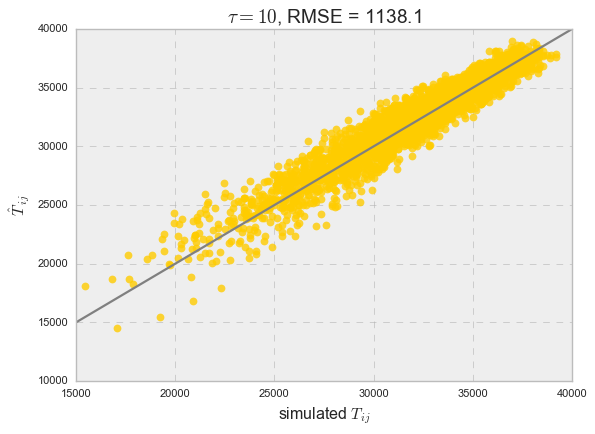

In [3859]:
## ONE outstanding question: 1) why is T_dd so high (other diag elements line up fine)??
# coaltimec0 = get_coaltime_w_c_t(coaltimetsnull, 0.5, 7, 23, 56)
# plt.plot(coaltimets10[np.tril_indices(80,-1)],coaltimec0[np.tril_indices(80,-1)],'o',color=cols(4),alpha=0.8); plt.axline((1.5e4,1.5e4),slope=1,color='grey'); plt.xlabel(r'simulated $T_{ij}$'); plt.ylabel(r'$\hat T_{ij}$'); plt.title(r'$\tau = 10$, RMSE = {:.1f}'.format(np.sqrt(np.mean((coaltimets10[np.tril_indices(80,-1)]-coaltimec0[np.tril_indices(80,-1)])**2)))); plt.show() #plt.ylim((0,20000))
# plt.plot(np.diag(coaltimec0),np.diag(coaltime10),'ko'); plt.axline((1.5e4,1.5e4),slope=1,color='grey')
# np.argpartition(np.abs(np.diag(coaltime10)-np.diag(coaltimenull)),-3)[-3:]
# plt.imshow(coaltimemat[1]-coaltimec0,cmap='RdBu'); plt.colorbar()
# coaltimenull[56,56], coaltimenull[23,23], coaltimenull[23,56]
# plt.plot(coaltimemat[10][43],coaltimec0[43],'o',color=cols(4),alpha=0.8); plt.axline((1e4,1e4),slope=1,color='grey')
# plt.plot(range(80),coaltimemat[10][56],'-b+',alpha=0.8,label=r'simulated, $\tau=10$'); plt.plot(range(80),coaltimec0[56],'-o',color=cols(4),alpha=0.6,label=r'computed, $\tau=10$'); plt.xlabel('deme ID'); plt.ylabel(r'pairwise coalescent time $T_{id}$'); plt.legend(); #plt.semilogy()
# [coaltimemat[t][56,56] for t in [0,1,2,5,10,50]]
# plt.imshow(np.abs(coaltimemat[5]-coaltimec0),cmap='Greens'); plt.colorbar(); plt.title(r'absolute error $|T_{ij}-\hat T_{ij}|, \tau=10$')
# # plt.plot([0,1,2,5,10,50],[coaltimemat[t][56,56] for t in [0,1,2,5,10,50]],'-ko'); plt.axhline(coaltimenull[56,56],color='r',ls='--'); plt.xlabel(r'simulated $\tau$'); plt.ylabel(r'$T_{dd}$'); 
# plt.figure(dpi=150); plt.axline((100,100),slope=1,color='grey'); 
# for it, t in enumerate([0,1,2,5,10,50]):
#     coaltimec0 = get_coaltime_w_c_t(coaltimemat['null'], 0.6, t, 23, 56)
#     plt.plot(np.diag(coaltimemat[t]),np.diag(coaltimec0),'o',color=cols(it),alpha=0.6,label=t);  
# plt.legend(title=r'$\tau$'); plt.xlabel(r'simulated $T_{ii}$'); plt.ylabel(r'$\hat T_{ii}$'); plt.loglog();
# plt.plot(np.diag(coaltimemat[2]),np.diag(coaltimec0),'o',color=cols(it),alpha=0.7,label=t); plt.plot(np.diag(coaltimemat[10])[[56, 47, 57, 67, 55, 46, 66, 24, 13, 33, 12, 32, 22]],np.diag(coaltimec0)[[56, 47, 57, 67, 55, 46, 66, 24, 13, 33, 12, 32, 22]],'gx',); plt.axline((100,100),slope=1,color='grey'); plt.loglog()

In [1234]:
# population_configurations = [
#     msprime.PopulationConfiguration(sample_size=30, initial_size=100) for i in range(80)]

# demography = msprime.Demography.from_old_style(population_configurations=population_configurations,
#                                                    migration_matrix=np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist()),
#                                                    ignore_sample_size=True, 
#                                                    Ne=1)
# demography.add_mass_migration(time=10, source=56, dest=23, proportion=0.6)
# demography

In [1053]:
for it, t in enumerate([0,1,2,5,10,50]):
    plt.plot(coaltimemat[t][23,:],'-o',color=cols(it),label=t,alpha=0.8)
    # plt.plot(np.diag(coaltimemat[t]),'-o',color=cols(it),label=t,alpha=0.8)
plt.plot(coaltimenull[23,:],'+-',color='k',label='no admix.',alpha=0.4)
# plt.plot(coaltime10[23,:],'-x',color=cols(4),label=r'$m=0.01$',alpha=0.8)
plt.legend(title=r'$\tau$'); plt.xlabel('deme ID'); plt.ylabel(r'pairwise coalescence time'); #plt.semilogy()
# np.diag(coaltimemat[10])[20:60], coaltimemat[10][56,56]
# obj.extract_outliers(pthresh=0.001,verbose=True)
# for t in [0,1,2,5,10,50]:
    ## print(np.max(coaltimemat[t]), np.min(coaltimemat[t]), np.median(coaltimemat[t]), np.mean(coaltimemat[t]), np.std(coaltimemat[t]))
    # plt.imshow(coaltimemat[t], cmap='Wistia'); plt.colorbar(); plt.title(r'$\tau=${:d}'.format(t)); plt.show()

TypeError: 'int' object is not callable

### using Hao's method for evolving forward the lineages

$$\text{diag}\{q\}\text{diag}\{T\} - MT - TM = 11^\top$$

If we have an admixture event at time $0$, then $T'_0 = T^* + \Delta T_0$, where $T^*$ is the equilibrium pairwise coalescent time matrix. Then, if we evolve forward under this equilibrium scenario for $\tau$ generations, we can get the difference, 

$$\Delta T_\tau = \tau \left(- \text{diag}\{q\}\text{diag}\{\Delta T_0\} + M\Delta T_0 + \Delta T_0M \right) + \Delta T_0$$

In [3502]:
# np.fill_diagonal(demography.migration_matrix, -np.ravel(demography.migration_matrix @ np.ones(80).reshape(-1,1)))Q

array([[0.0005, 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.0005, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.0005, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 0.0005, 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.0005, 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.0005]])

In [3599]:
def get_haotime_w_c_t(coaltimenull, c, tau, s, d):
    migmat = demography.migration_matrix
    # np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(80).reshape(-1,1)))
    dT0 = np.zeros_like(coaltimenull)

    ## this formulation gives unbiased estimates of c & t based on RMSE of 10 sims for pairwise coalescent times
    # for i in list(set(range(dT0.shape[0]))-set([d])):
    #     dT0[i,d] = c*coaltimenull[i,s] - c*coaltimenull[i,d]; dT0[d,i] = dT0[i,d]
    # dT0[d,d] = c**2*coaltimenull[s,s] + 2*c*(1-c)*coaltimenull[s,d] + (c**2-2*c)*coaltimenull[d,d]

    for i in list(set(range(dT0.shape[0]))-set([d])):
        dT0[i,d] = c*coaltimenull[i,s] - c*coaltimenull[i,d]; dT0[d,i] = dT0[i,d]
    dT0[d,d] = c**2*coaltimenull[s,s] + 2*c*(1-c)*coaltimenull[s,d] + (c**2-2*c)*coaltimenull[d,d]

    dTt = -tau*(Q*10@np.diag(np.diag(dT0)) - migmat@dT0 - dT0@migmat) + dT0

    return coaltimenull+dTt

In [3598]:
def get_haotime_w_c_t2(coaltimenull, c, tau, s, d):
    migmat = demography.migration_matrix
    # np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(80).reshape(-1,1)))
    dT0 = np.zeros_like(coaltimenull)

    ## this formulation gives the same values as instantaneous case when tau=0 (but biased if using the formulation above)
    dT0[s,d] = c*coaltimenull[s,s] - c*coaltimenull[s,d] + 0.5*(c**2-c)*coaltimenull[s,d] + 2*c*coaltimenull[s,s]; dT0[d,s] = dT0[s,d]
    for i in list(set(range(dT0.shape[0]))-set([s,d])):
        dT0[i,d] = c*coaltimenull[i,s] - c*coaltimenull[i,d] + 0.5*(c**2-c)*coaltimenull[s,d]; dT0[d,i] = dT0[i,d]
    dT0[d,d] = c**2*coaltimenull[s,s] + 2*c*(1-c)*coaltimenull[s,d] + (c**2-2*c)*coaltimenull[d,d]

    dTt = -tau*(Q*10@np.diag(np.diag(dT0)) - migmat@dT0 - dT0@migmat) + dT0

    return coaltimenull+dTt

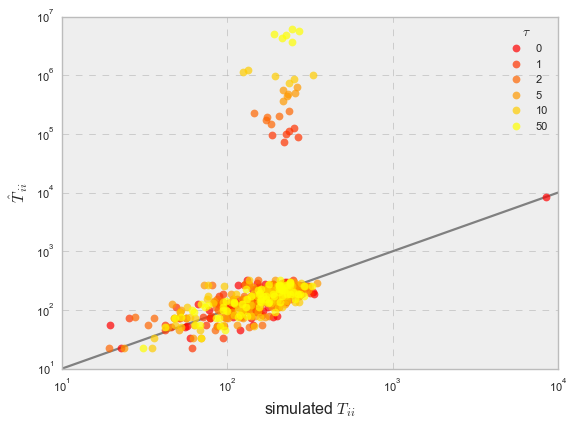

In [1485]:
plt.axline((100,100),slope=1,color='grey'); 
for it, t in enumerate([0,1,2,5,10,50]):
    coaltimec0 = get_haotime_w_c_t(coaltimemat['null'], 0.6, t*1000, 23, 56)
    plt.plot(np.diag(coaltimemat[t]),np.diag(coaltimec0),'o',color=cols(it),alpha=0.7,label=t); 
plt.legend(title=r'$\tau$'); plt.xlabel(r'simulated $T_{ii}$'); plt.ylabel(r'$\hat T_{ii}$'); #plt.loglog(); 
# coaltimec0 = get_haotime_w_c_t(coaltimenull,0.5,10,23,56)
# plt.plot(np.diag(coaltime10),np.diag(coaltimec0),'o',color=cols(4),alpha=0.7); plt.loglog()

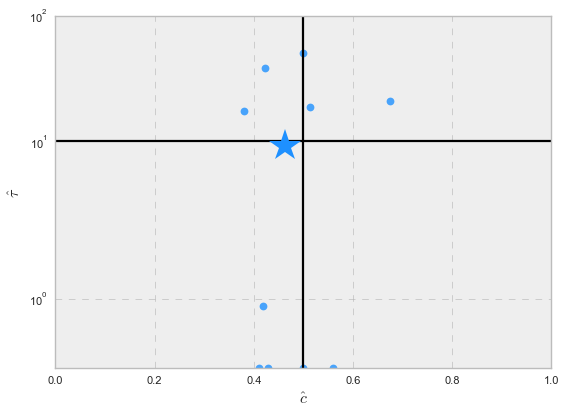

In [4352]:
# estsim = np.array([[4.10431916e-01, 7.92919862e-09],[ 0.42364001, 38.3736428 ],[5.60497931e-01, 1.93766894e-08],[0.49836902, 0.00139828],[ 0.512832  , 18.90176335],[ 0.50029511, 50.57321875],[ 0.67375107, 21.2205668 ],[0.41902669, 0.89104364],[0.42891996, 0.0015734 ],[ 0.38136416, 17.50254238]])
# est2 = np.array([[0.0334998 , 0.13675313],[5.59964908e-02, 4.99995511e+02],[0.06728984, 0.23588045],[0.04128836, 0.01456832],[0.06031066, 0.20734986],[ 0.8837989 , 11.31182538],[ 0.08061366, 51.05648748],[ 0.05596262, 40.1611428 ],[ 0.05552025, 20.33612972],[0.94979378, 0.00482244]])

plt.plot(estsim[:,0],estsim[:,1],'o',color='dodgerblue',alpha=0.8,label='est'); 
# plt.plot(est2[:,0],est2[:,1],'o',color='green',alpha=0.8,label=r'est2'); 
plt.xlabel(r'$\hat c$'); plt.ylabel(r'$\hat \tau$'); plt.axhline(10,color='k'); plt.axvline(0.5,color='k'); plt.xlim((0,1)); plt.yscale('symlog')
plt.plot(np.median(estsim[:,0]),np.median(estsim[:,1]),'*',markersize=30,color='dodgerblue'); 
# plt.plot(np.median(est2[:,0]),np.median(est2[:,1]),'*',markersize=30,color='green'); plt.ylim((-0.1,50)); plt.legend()

In [3749]:
# demography = msprime.Demography.from_old_style(population_configurations=population_configurations,
#                                                    migration_matrix=np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist())*0.1,
#                                                    ignore_sample_size=True, 
#                                                    Ne=100)
# demography.add_mass_migration(time=10, source=56, dest=23, proportion=0.5)
# for rep in range(10):
#     print(r"Rep {:d}: ".format(rep))
#     ts = msprime.sim_ancestry(
#             samples=[msprime.SampleSet(15,i,ploidy=2) for i in range(80)],
#             demography=demography,
#             sequence_length=700,
#             recombination_rate=0.001,  # No recombination
#             record_migrations=False, record_full_arg=False,
#             # model=[msprime.DiscreteTimeWrightFisher(duration=time_of_adm[0]+1), msprime.StandardCoalescent()],
#     )
#     print('done')

#     coaltimets10 = np.zeros((80,80))
#     for i in range(80):
#         for j in range(i,80):
#             coaltimets10[i,j] = ts.divergence([ts.samples(population=i),ts.samples(population=j)],mode='branch')/2
#             coaltimets10[j,i] = coaltimets10[i,j]

#     foo = lambda x: np.sqrt(np.mean((get_haotime_w_c_t(coaltimetsnull, x[0], x[1], 23, 56)[np.tril_indices(80,0)]-coaltimets10[np.tril_indices(80,0)])**2))
#     print(sp.optimize.minimize(foo, [0.3, 50], method='Powell', bounds=[[0,1],[0,500]]))

#     foo = lambda x: np.sqrt(np.mean((get_haotime_w_c_t2(coaltimetsnull, x[0], x[1], 23, 56)[np.tril_indices(80,0)]-coaltimets10[np.tril_indices(80,0)])**2))
#     print(sp.optimize.minimize(foo, [0.3, 50], method='Powell', bounds=[[0,1],[0,500]]))

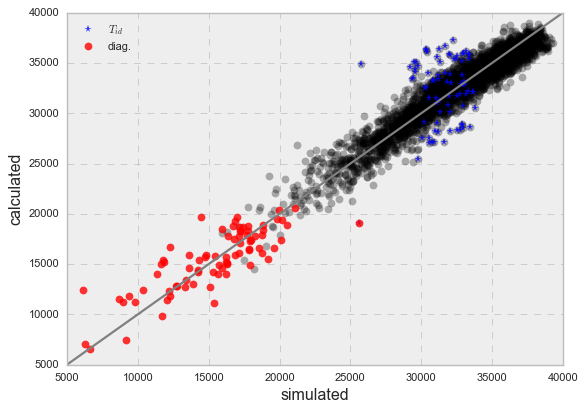

In [4346]:
# M = migmat - np.diag(np.diag(migmat))
coaltimec0 = get_haotime_w_c_t(coaltimetsnull, 0.0, 3., 23, 56)
# plt.plot(range(20),[get_coaltime_w_c_t(coaltimenull, 0.5, t, 23, 56)[56,56] for t in range(20)],'ko')
# coaltimec0[56,56], coaltimenull[56,56], coaltime3[56,56], coaltime10[56,56]
# foo = lambda x: np.sqrt(np.mean((get_haotime_w_c_t(coaltimetsnull, x[0], x[1], 23, 56)[np.tril_indices(80,0)]-coaltimets10[np.tril_indices(80,0)])**2))
# sp.optimize.minimize(foo, [0.1, 1], method='Nelder-Mead', bounds=[[0,1],[0,500]]) # 1177.483480619133
# np.sqrt(np.mean((coaltimec0[np.tril_indices(80,0)]-coaltime10[np.tril_indices(80,0)])**2))
# plt.imshow(coaltimec0-coaltime10,cmap='RdBu'); plt.title(r'$\Delta T_{\tau=1}$'); plt.colorbar()
plt.plot((coaltimets30)[np.tril_indices(80,-1)],(coaltimec0)[np.tril_indices(80,-1)],'ko',alpha=0.3); plt.plot((coaltimets30)[56],(coaltimec0)[56],'b*',alpha=0.8,label=r'$T_{id}$'); plt.plot(np.diag(coaltimets30),np.diag(coaltimec0),'ro',alpha=0.8,label=r'diag.'); plt.axline((1.7e4,1.7e4),slope=1,color='grey'); plt.xlabel('simulated'); plt.ylabel('calculated'); plt.legend(loc='upper left'); 

# plt.plot((coaltimetsnull)[np.tril_indices(80,-1)],(coaltimec0)[np.tril_indices(80,-1)],'ko',alpha=0.3); plt.plot((coaltimetsnull)[56],(coaltimec0)[56],'b*',alpha=0.8,label=r'$T_{id}$'); plt.plot(np.diag(coaltimetsnull),np.diag(coaltimec0),'ro',alpha=0.8,label=r'diag.'); plt.axline((1.7e4,1.7e4),slope=1,color='grey'); plt.xlabel('simulated'); plt.ylabel('calculated'); plt.title(r"$T'_{\tau=0}$"); plt.legend(loc='upper left'); 
# plt.imshow(-50*(Q@np.diag(np.diag(dT0)) - migmat@dT0 - dT0@migmat),vmin=-4000,vmax=4000,cmap='RdBu'); plt.colorbar(); plt.title(r'$\Delta T_{\tau=50}$')

In [861]:
np.where(rmse==np.nanmin(rmse))
# np.min(rmse)

(array([4]), array([2]))

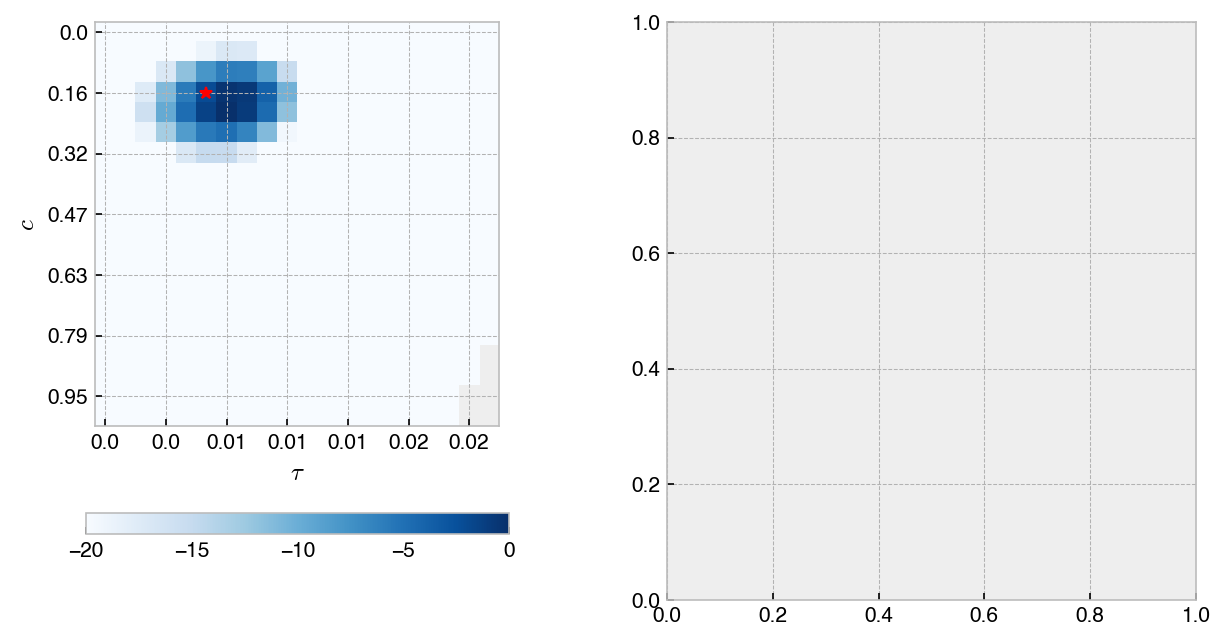

In [862]:
cmesh = np.linspace(0,1,20); tmesh = np.linspace(0,0.02,20)
# # # foo = lambda x: np.sqrt(np.mean((get_haotime_w_c_t(coaltimetsnull, x[0], x[1], 23, 56)[np.tril_indices(80,0)]-coaltimets10[np.tril_indices(80,0)])**2))
# # # foo2 = lambda x: np.sqrt(np.mean((get_haotime_w_c_t2(coaltimetsnull, x[0], x[1], 23, 56)[np.tril_indices(80,0)]-coaltimets10[np.tril_indices(80,0)])**2))
# rmse = np.zeros((len(cmesh),len(tmesh))); rmse2 = np.zeros_like(rmse)
for ic, c in enumerate(cmesh):
    for it, t in enumerate(tmesh):
        # rmse[ic,it] = obj.neg_log_lik_c_t([0.99*c,t],{'lre':[(23,56)]}) #-foo([c,t])
        try:
            rmse[ic,it] = obj.neg_log_lik_c_t([c,t],{'lre':[(22,57)]})
        except:
            rmse[ic,it] = np.nan

# np.where(rmse==np.nanmin(rmse))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),dpi=150); 
im = ax1.imshow(np.nanmin(rmse)-rmse,vmin=-20,cmap='Blues'); plt.colorbar(im, ax=ax1, orientation='horizontal', shrink=0.8); ax1.set_xlabel(r'$\tau$'); ax1.set_ylabel(r'$c$'); ax1.set_yticks(ticks=range(0,len(cmesh),3),labels=np.round(cmesh[::3],2)); ax1.set_xticks(ticks=range(0,len(tmesh),3),labels=np.round(tmesh[::3],2)); ax1.plot(5,3,'r*'); #ax1.axhline(9,color='k'); ax1.axvline(16,color='k'); #plt.show()
# im = ax2.imshow(rmse2-np.max(rmse2),vmin=-20,cmap='Greens'); plt.colorbar(im, ax=ax2, orientation='horizontal', shrink=0.8); ax2.set_xlabel(r'$\tau$'); ax2.set_ylabel(r'$c$'); ax2.set_yticks(ticks=range(0,len(cmesh),3),labels=np.round(cmesh[::3],2)); ax2.set_xticks(ticks=range(0,len(tmesh),3),labels=np.round(tmesh[::3],2)); ax2.plot(19,1,'r*'); ax2.axhline(9.5,color='k'); ax2.axvline(4,color='k'); #plt.show()

In [4129]:
# plt.plot([0,1,2,5,10,50],[-92,-2998,-5298,-7228,-7642,-5967],'o',color='coral',label='equilibrium eq.'); plt.plot([0,1,2,5,10,50],[-92,-2943,-5192,-6989,-7237,-5901],'*',color='deepskyblue',markersize=8,label='diffusion prob.'); plt.xlabel(r'$\tau$'); plt.ylabel(r'error in $T_{dd}$'); plt.axhline(0,color='grey'); plt.legend(); 

# plt.plot([0,1,2,5,10,50],[-17,-290,-117,139,290,-1289],'o',color='coral',label='equilibrium eq.'); plt.plot([0,1,2,5,10,50],[-17,-117,222,958,1827,3704],'*',color='deepskyblue',markersize=8,label='diffusion prob.'); plt.xlabel(r'$\tau$'); plt.ylabel(r'error in $T_{sd}$'); plt.axhline(0,color='grey'); plt.legend(); 

# plt.plot((coaltimenull+dTt)[np.tril_indices(80,-1)],coaltimec0[np.tril_indices(80,-1)],'o',color=cols(4),alpha=0.8); plt.axline((1e4,1e4),slope=1,color='grey'); plt.xlabel(r'equilibrium eq. estimates'); plt.ylabel(r'diffusion prob. estimates'); plt.title(r'$T_{ij}$ for $\tau=10$')
# plt.plot(np.diag(coaltimenull+dTt),np.diag(coaltimec0),'o',color=cols(4),alpha=0.8); plt.axline((1e3,1e3),slope=1,color='grey'); plt.xlabel(r'equilibrium eq. estimates'); plt.ylabel(r'diffusion prob. estimates'); plt.title(r'$T_{ij}$ for $\tau=10$')

In [129]:
# list(sp_graph.neighbors(23))
# list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[75]))
# neighs = [22,11,14,23] 
# [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]
# nx.get_node_attributes(sp_graph,'permuted_idx')[74]
# get_best_lre(sp_graph,k=1, lamb_cv=3., top=10, nboot=20, nchoose=100, option='base')
# MLEloc60
# MLEdist60 = [2, 0, 2, 1, 2, 2, 2, 2, 2, 0]; MLEdist = [3, 4, 0, 2, 1, 2, 3, 4, 0, 2]
# plt.scatter(range(1,11),np.sort(MLEdist)[::-1],color='lightblue',marker='D',s=75,label=r'$c=0.3$'); plt.yticks(range(5)); plt.ylabel('dist. from true deme'); plt.xlabel('replicate'); plt.scatter(range(1,11),np.sort(MLEdist60),color='dodgerblue',marker='o',label=r'$c=0.6$'); plt.legend()
# plt.scatter([3,5,9],np.array(MLEdist60)[np.array([2,4,8])],color='lightblue',marker='D'); 
# plt.scatter([2,4,10],np.array(MLEdist60)[np.array([1,3,9])],color='dodgerblue',marker='D',s=55);

# res60 = np.polyfit(np.abs(MLEc60-0.6),truell60,1); res = np.polyfit(np.abs(MLEc-0.3),truell,1)
# plt.scatter(np.abs(MLEc60-0.6),truell60,color='dodgerblue',alpha=0.8,label=r'$c=0.6$, mean dist.≈1.5',s=(np.array(MLEdist60)+1)*70); plt.xlabel(r'$|c-\hat c|$'); plt.ylabel('log-lik difference b/w MLE & true deme'); plt.scatter(np.abs(MLEc-0.3),truell,color='lightblue',label=r'$c=0.3$, mean dist.≈2.1',s=(np.array(MLEdist)+1)*70); plt.legend()
# plt.plot(np.abs(MLEc60-0.6),np.abs(MLEc60-0.6)*res60[0]+res60[1],color='dodgerblue'); plt.plot(np.abs(MLEc-0.3),np.abs(MLEc-0.3)*res[0]+res[1],color='lightblue'); 

# plt.boxplot(np.vstack((MLEc,MLEc60)).T,labels=['0.3','0.6']); plt.ylabel(r'$\hat c$'); plt.title('MLE deme'); plt.axhline(0.3,color='grey',linestyle='--'); plt.axhline(0.6,color='grey',linestyle='--'); plt.ylim(0,1); plt.show();
# plt.boxplot(np.vstack((truec,truec60)).T,labels=['0.3','0.6']); plt.ylabel(r'$\hat c$'); plt.title('true deme'); plt.axhline(0.3,color='grey',linestyle='--'); plt.axhline(0.6,color='grey',linestyle='--'); plt.ylim(0,1)
# plt.scatter(range(1,11),MLEdist,color='k',marker='x',s=np.abs(MLEc60-0.6)*400,label='sampled demes'); plt.yticks(range(5)); plt.plot([2,4,10],np.array(MLEdist)[np.array([1,3,9])],'ko',label='unsampled demes'); plt.legend(); plt.ylabel('dist. from true deme'); plt.xlabel('replicate')
# plt.scatter(range(1,11),truell60,color='dodgerblue',marker='o',s=np.abs(truec60-0.6)*400); plt.xlabel('replicate'); plt.ylabel('log-lik difference b/w MLE & true deme'); plt.scatter(range(1,11),truell,color='lightblue',marker='o',s=np.abs(truec-0.3)*400); plt.xlabel('replicate'); plt.ylabel('log-lik difference b/w MLE & true deme')
# np.sum(np.abs(MLEc60-0.6)), np.sum(np.abs(truec60-0.6))
# plt.boxplot(np.vstack((MLEc60, truec60)).T); plt.ylim(0,1); plt.axhline(0.6)
# sampnodes = [2,14,18,25,31,44,46,57,62,66,74]
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=10, corridor_w=1., barrier_w=1., barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=3, barrier_endpt=6, option=2, ss=[20 if i in sampnodes else 0 for i in range(80)])
# gen_test_80_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=900, mu=10, long_range_nodes=[(44,18)], admixture_props=[0.5], time_of_adm=[0.000001])
# coord = coord_def[list(range(50))+list(range(60,100)),:]
# gen_test = gen_test_80_adm[list(range(50))+list(range(60,100)),:]
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)
sp_graph = FEEMSmix_SpatialGraph(gen_test_80[10], coord_def, grid_def, edge_def)
sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=30.); 
obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
obj.extract_outliers(0.0001); obj.inv(); obj.Lpinv = np.linalg.pinv(sp_graph.L.todense()); obj.grad(reg=False)
# df = obj.calc_contour(destid=18,search_area='all',exclude_boundary=True)
# df.shape
# sampnodes = list(np.arange(1,81)[::2])+[44]
# sampnodes = [2,18,25,31,44,46,57,62,74]
# sampnodes = [2,14,18,25,31,44,46,57,62,66]
# ss = [np.random.randint(1,11)*2 if i in sampnodes else 0 for i in range(80)]
# np.array(ss)[np.array(sampnodes)]
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=10, corridor_w=.01, barrier_w=.01, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=3, barrier_endpt=6, option=2, ss=[20 if i in sampnodes else 0 for i in range(80)])
# foo = lambda c: simulate_genotypes_w_admixture(graph_def, target_n_snps=2000, n_print=900, long_range_nodes=[(44,18)], admixture_props=[0.5], n_e=np.concatenate((np.repeat(1,20), np.repeat(3,20), np.repeat(10,20), np.repeat(30,20))), time_of_adm=[0.000001])
# gen_test_80 = Parallel(n_jobs=16)(delayed(foo)(0.5) for _ in range(16))

constant-w/variance fit, converged in 148 iterations, train_loss=25748.211
lambda=3.000, alpha=2.7465, converged in 61 iterations, train_loss=25479.636
Using a significance threhsold of 0.0001:

1 outlier deme pairs found
 source  dest. source (lat., long.) dest. (lat., long.)         pval
     44     18           (0.0, 5.0)          (0.0, 2.0) 1.738539e-08

Putative destination demes (and # of times the deme appears as an outlier) experiencing admixture:
18    1
Name: dest., dtype: int64


In [137]:
# MLEloc60 = np.zeros(10); MLEc60 = np.zeros(10); truell60 = np.zeros(10); truec60 = np.zeros(10)
MLEloc = []; MLEdiff = []; MLEdf = pd.DataFrame(0, index=range(1,80), columns=['(source, dest.)','admix. prop.','log-lik','scaled log-lik']); MLEc = []
# sampnodes = [2,14,18,25,31,44,46,57,62,66,74] #-> sparse sampling with only 10 nodes
# sampnodes = np.arange(80)[::2]
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=10, corridor_w=1., barrier_w=1., barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=3, barrier_endpt=6, option=2, ss=[20 if i in sampnodes else 0 for i in range(80)])
# foo = lambda c: simulate_genotypes_w_admixture(graph_def, target_n_snps=2000, n_print=900, long_range_nodes=[(44,18)], admixture_props=[0.5], n_e=1, time_of_adm=[0.000001])
# gen_test_80 = Parallel(n_jobs=10)(delayed(foo)(0.5) for _ in range(10))
cnt = 0
for i in range(16):
    # coord = coord_def[list(range(220))+list(range(230,400)),:] #-> sparse sampling with only 10 nodes
    # coord = coord[list(range(19))+list(range(20,36)),:]
    coord = coord_def[list(range(50))+list(range(60,100)),:]
    gen_test = gen_test_80[i][list(range(50))+list(range(60,100)),:]
    # gen_test = gen_test[list(range(19))+list(range(20,36)),:]
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

    sp_graph = FEEMSmix_SpatialGraph(gen_test, coord, grid_def, edge_def)
    sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=0., verbose=False); 
    obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

    top = obj.extract_outliers(0.001,verbose=False)
    df = obj.calc_contour(destid=18,search_area='all',exclude_boundary=False)

    # MLEloc.append(df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])])
    MLEloc.append(sp_graph.nodes[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]]['pos'])
    MLEc.append(df['admix. prop.'].iloc[np.argmax(df['scaled log-lik'])])
    MLEdiff.append(df['scaled log-lik'].iloc[np.where(df['(source, dest.)']==(44,18))[0]].values[0])
    
    MLEdf['(source, dest.)'] = df['(source, dest.)']
    MLEdf['admix. prop.'] += df['admix. prop.']
    MLEdf['scaled log-lik'] += df['scaled log-lik']
    MLEdf['log-lik'] += df['log-lik']
    if df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])]==(44,18):
        cnt += 1 

    # isc2 = np.zeros(len(randedge)); llc2 = np.zeros(len(randedge))
    # for ie, e in enumerate(randedge):
    #     if e[0]<39:
    #         res = sp.optimize.minimize_scalar(get_FEEMS_demes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
    #         isc2[ie] = res.x; llc2[ie] = res.fun
    #     else:
    #         res = sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
    #         isc2[ie] = res.x; llc2[ie] = res.fun

    # MLEloc60[i] = np.argmin(llc2); MLEc60[i] = isc2[np.argmin(llc2)]
    # truell60[i] = np.min(llc2)-llc2[50]; truec60[i] = isc2[50]
    # print(MLEloc60[i], truell60[i], MLEc60[i], truec60[i])
    
    # fig = plt.figure(dpi=110)
    # ax = fig.add_subplot(1, 1, 1)
    # v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, obs_node_zorder=2,
    #         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=4, sample_pt_color="black", cbar_font_size=10)
    # ax.scatter(v.grid[23,0],v.grid[23,1],marker='x',color='b'); ax.scatter(v.grid[56,0],v.grid[56,1],marker='x',color='b');
    # ax.tricontourf([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],isc2,cmap='Greys',vmax=1,vmin=0,alpha=0.8,levels=5); 
    # CS = ax.tricontour([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],isc2,cmap='Greys',vmax=1,vmin=0,alpha=0.8,levels=5); ax.clabel(CS, inline=1, fontsize=8, colors='k')
    # fig = plt.figure(dpi=110)
    # ax = fig.add_subplot(1, 1, 1)
    # v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, obs_node_zorder=2,
    #         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=4, sample_pt_color="black", cbar_font_size=10)
    # ax.tricontourf([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=[-100,-20,-10,-2,0],extend='max',cmap='Greens',alpha=0.7); CS = ax.tricontour([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=[-100,-20,-10,-2,0],cmap='Greens',alpha=0.7); ax.clabel(CS, inline=1, fontsize=8, colors='k')
    # ax.scatter(v.grid[23,0],v.grid[23,1],marker='x',color='b'); ax.scatter(v.grid[56,0],v.grid[56,1],marker='x',color='b');
MLEdf['admix. prop.'] /= 16
MLEdf['scaled log-lik'] /= 16
MLEdf['log-lik'] /= 16
print('True source is MLE: {:d} times'.format(cnt))

Using a significance threhsold of 0.001:

1 outlier deme pairs found
 source  dest. source (lat., long.) dest. (lat., long.)     pval
     62     18           (0.0, 7.0)          (0.0, 2.0) 0.000684

Putative destination demes (and # of times the deme appears as an outlier) experiencing admixture:
18    1
Name: dest., dtype: int64
Optimizing likelihood over 79 demes in the graph...
0%...25%...50%...75%...Using a significance threhsold of 0.001:

No outliers found.
Consider raising the significance threshold slightly.
Optimizing likelihood over 79 demes in the graph...
0%...25%...50%...75%...Using a significance threhsold of 0.001:

1 outlier deme pairs found
 source  dest. source (lat., long.) dest. (lat., long.)     pval
     62     18           (0.0, 7.0)          (0.0, 2.0) 0.000491

Putative destination demes (and # of times the deme appears as an outlier) experiencing admixture:
18    1
Name: dest., dtype: int64
Optimizing likelihood over 79 demes in the graph...
0%...25%...50%...

In [89]:
# plt.plot([1e-4,1e-3,1e-2,0.05,0.1,0.25,0.5,1],[0.13019761197484192,0.12902149935293244,0.1525418528222208,0.2596411144597768,0.3533682636707458,0.6133418878657412,1.0252415513544038,1.7361586277801393],'ko'); plt.axline((1,1),slope=1,color='grey',ls='--')
# plt.errorbar([1e-4,1e-3,1e-2,0.05,0.1,0.25,0.5,1],[0.13019761197484192,0.12902149935293244,0.1525418528222208,0.2596411144597768,0.3533682636707458,0.6133418878657412,1.0252415513544038,1.7361586277801393],yerr=2*np.array([0.022712280888398006,0.02512421169863045,0.027121704897425686,0.04519398722241161,0.04100375527102841,0.0613764922651444,0.09075075842841175,0.14649618822602764]),color='k'); plt.xlabel('msprime simulated weights'); plt.ylabel('FEEMS estimated weights'); plt.semilogx()
# 
# sp.optimize.minimize(obj.neg_log_lik_c, 0.5, bounds=[(0.0,1)], args={'lre':[(46,8)],'mode':'unsampled'})
# np.where(MLEdf['scaled log-lik'].isna())
# plt.hist2d(np.array(MLEloc)[:,0],np.array(MLEloc)[:,1],cmap='Greens'); plt.ylim((0,6.5)); plt.xlim((0,10)); plt.colorbar()

Text(0.5, 1.0, 'True source is MLE: 0 times')

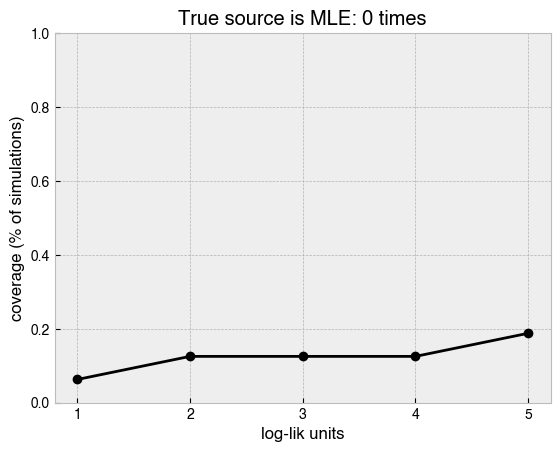

In [138]:
# n_rows, n_columns = 6, 6
# for w in [1e-2]:
#     graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=w, barrier_w=w, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=3, barrier_endpt=6, option=1, ss=20)
#     gen_test_36_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1200, n_print=900, mu=1, long_range_nodes=[(0,1)], admixture_props=[0.0], time_of_adm=[0.000001])
#     sp_graph = FEEMSmix_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def)
#     sp_graph.fit(lamb=3.,optimize_q='n-dim');   
#     print(np.mean(sp_graph.w), np.std(sp_graph.w))
# plt.plot(range(79),MLEdf['scaled log-lik'],'-o'); plt.ylim((-10,0))
plt.plot(range(1,6),[np.sum(np.array(MLEdiff)>-l)/16 for l in range(1,6)],'-ko'); plt.xlabel('log-lik units'); plt.ylabel('coverage (% of simulations)'); plt.xticks(range(1,6)); plt.ylim(0,1); plt.title('True source is MLE: {:d} times'.format(cnt))
# neighs = list(obj.sp_graph.neighbors(nx.get_node_attributes(obj.sp_graph,'permuted_idx')[47]))
# [s for s in neighs if nx.get_node_attributes(obj.sp_graph,'n_samples')[s]>0]
# np.argmin([nx.shortest_path_length(obj.sp_graph,source=7,target=d) for d in set([k for k, v in nx.get_node_attributes(obj.sp_graph,'n_samples').items() if v>0])-set([7])])
# R1 = -2*obj.Linv[48,:obj.sp_graph.n_observed_nodes] + np.diag(obj.Linv) + obj.Lpinv[48,48]
# np.argsort(R1), np.argsort([nx.shortest_path_length(obj.sp_graph,source=48,target=d) for d in set([k for k, v in nx.get_node_attributes(obj.sp_graph,'n_samples').items() if v>0])-set([48])])[:9] # {2, 14, 18, 25, 31, 46, 57, 62, 66}
# R1
# [nx.shortest_path_length(obj.sp_graph,source=44,target=d) for d in set([k for k, v in nx.get_node_attributes(obj.sp_graph,'n_samples').items() if v>0])-set([44])]

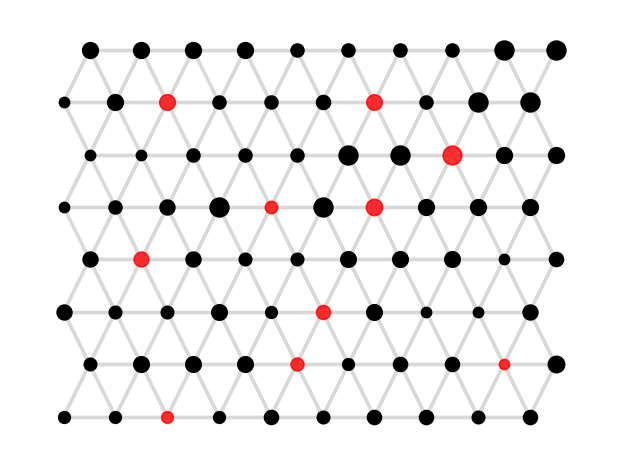

In [130]:
# np.array(MLEloc).std(axis=0)
# np.array(MLEloc).std(axis=0), np.array(MLEloc).mean(axis=0)
fig = plt.figure(dpi=120)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, obj, projection=None, edge_width=2,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=False); #v.draw_edge_colorbar()
for i in range(80):
    ip = np.where(obj.perm_idx==i)[0][0]
    if ip<sp_graph.n_observed_nodes:
        v.ax.plot(v.grid[i,0], v.grid[i,1], 'ro', alpha=0.8, markersize=20/sp_graph.q[ip])
        # v.ax.plot(v.grid[i,0], v.grid[i,1], 'ro', alpha=0.8, markersize=np.concatenate((np.repeat(1,20), np.repeat(3,20), np.repeat(10,20), np.repeat(30,20)))[i])
    else:
        R1 = np.array(-2*obj.Lpinv[:sp_graph.n_observed_nodes,ip].T + np.diag(obj.Linv) + obj.Lpinv[ip,ip])
        proxs = np.argsort([nx.shortest_path_length(sp_graph,source=ip,target=d) for d in set(obj.perm_idx[:sp_graph.n_observed_nodes])-set([ip])])[:1]
        # qprox = np.dot(1/sp_graph.q[proxs], (1/R1[0,proxs].T)/np.sum(1/R1[0,proxs]))
        qprox = np.dot(1/sp_graph.q[proxs], (R1[0,proxs]*np.exp(-2*R1[0,proxs]))/np.sum(R1[0,proxs]*np.exp(-2*R1[0,proxs])))
        v.ax.plot(v.grid[i,0], v.grid[i,1], 'ko', markersize=20*qprox)
        # v.ax.plot(v.grid[i,0], v.grid[i,1], 'ko', alpha=0.8, markersize=np.concatenate((np.repeat(1,20), np.repeat(3,20), np.repeat(10,20), np.repeat(30,20)))[i])

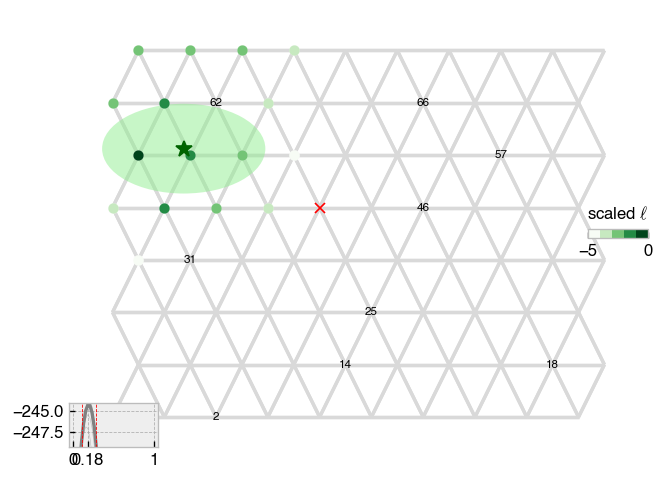

In [139]:
# n_rows, n_columns = 8, 10
# smallnodes = set(list(range(1,144)[::2]))-set([53])-set([116]) #[12, 13, 22, 24, 32, 33] #list(np.random.randint(80,size=10)) 
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1., barrier_w=1., barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=3, barrier_endpt=6, option=1, ss=20)#[0 if i in smallnodes else 20 for i in range(80)])

# lrn = [(23,56)]#[(53,116)] 
# gen_test_80_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1200, n_print=900, mu=1, long_range_nodes=lrn, admixture_props=[0.6], time_of_adm=[0.000001])

# coord = coord_def[list(range(120))+list(range(130,410)),:]
# gen_test = gen_test_80_adm[list(range(120))+list(range(130,410)),:]
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

# sp_graph = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3.,optimize_q='n-dim');   
# obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# sp_graph.fit(lamb=2.,optimize_q='n-dim',option='onlyc',long_range_edges=[(1,15)]); 

# from matplotlib.patches import Ellipse
fig = plt.figure(dpi=120)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, obj, projection=None, edge_width=2,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=False); v.draw_obs_nodes(use_ids=True); #v.draw_edge_colorbar()
v.draw_ll_contour(MLEdf,levels=[-5,0]); 
v.ax.plot(np.array(MLEloc).mean(axis=0)[0], np.array(MLEloc).mean(axis=0)[1], '*', color='darkgreen', markersize=10)
# v.ax.errorbar(np.array(MLEloc).mean(axis=0)[0], np.array(MLEloc).mean(axis=0)[1], yerr=np.array(MLEloc).std(axis=0)[1], xerr=np.array(MLEloc).mean(axis=0)[0], ecolor='darkgreen', linewidth=2)
v.ax.add_patch(Ellipse(np.array(MLEloc).mean(axis=0), width=2*np.array(MLEloc).std(axis=0)[0], height=2*np.array(MLEloc).std(axis=0)[1], alpha=0.5, facecolor='lightgreen'))
v.ax.plot(v.grid[44,0],v.grid[44,1],'rx'); #v.draw_arrow([(44,18)],0.5)
# plt.imshow(sp_graph.S,cmap='Greys'); plt.colorbar()
# sp_graph.W[8,27] = sp_graph.W[27,8] = 0
# plt.imshow(sp_graph.W.todense(),cmap='Greys');
# plt.imshow(np.diag(np.ones(36)),cmap='Greys')
# W = np.zeros((36,36)); W[10,25] = 0.1; W[25,10] = 0.1; 
# plt.imshow(W,cmap='Greys');
# get_FEEMS_demes_nll_w_c(sp_graph.c, sp_graph, obj, [(19,49)]), get_FEEMS_udemes_nll_w_c(0.544,sp_graph,obj,[(19,49,79)])
# sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(sp_graph, obj, [(19,49,79)]), bounds=(0,1), method='bounded')
# sp.optimize.minimize_scalar(get_FEEMS_demes_nll_w_c, args=(sp_graph, obj, [(19,49,79)]), bounds=(0,1), method='bounded')

In [1673]:
# randedge = [tuple(np.random.choice(range(80),size=2,replace=False)) for _ in range(100)]
# randedge = list(set(randedge)-set(sp_graph.edges))
# randedge = [(x,58) for x in list(set(range(144))-set([58]))] 
# truew = np.append(np.zeros(len(randedge)),[0.6,0,0,0,0,0,0,0,0])
# for e in [(23,56),(22,56),(24,56),(23,57),(23,55),(24,55),(12,56),(13,56),(32,56)]:
#     randedge.append(e)
# for e in [(56,23),(56,22),(56,24),(57,23),(55,23),(55,24)]:
#     randedge.append(e)
# for e in [(8,27),(7,27),(9,27),(8,26),(8,28)]:
#     randedge.append(e)
# for e in [(23,92),(22,92),(91,23),(92,24),(101,36),(102,36),(35,101),(117,36),(35,118)]:
#     randedge.append(e)
# print(randedge)

isc2 = np.zeros(len(randedge)); llc2 = np.zeros(len(randedge))
# sp_graph = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def); 
for ie, e in enumerate(randedge):
    # llc = []
    # for c in np.linspace(0,1,25): 
    #     # llc.append(get_FEEMS_demes_ll_w_c(sp_graph, obj, sp_graph.w, sp_graph.q, [e], c, df=1500, sigstar=0.5)[1])
    #     try: 
    #         llc.append(-get_FEEMS_demes_nll_w_c(c, sp_graph, obj, [e], form='matrix'))
    #     except:
    #         llc.append(-1e8)
    # logc[ie] = np.linspace(0,1,12)[np.argmin(np.abs(llc-np.max(llc)+2))] # llc[0] - llc[-1]
    # if np.argmax(llc)!=0:
    #     isc[ie] = 1
    # isc2[ie] = np.linspace(0,1,25)[np.argmax(llc)]
    if e[0]<80:
        res = sp.optimize.minimize_scalar(get_FEEMS_demes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
        # res = sp.optimize.minimize(get_FEEMS_demes_nll_w_c, x0=0.5, method='Nelder-Mead', bounds=[(0,1)], args=(sp_graph, obj, [e]))
        isc2[ie] = res.x; llc2[ie] = res.fun
    else:
        res = sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
        # res = sp.optimize.minimize(get_FEEMS_udemes_nll_w_c, x0=0.5, method='L-BFGS-B', bounds=[(0,1)], args=(sp_graph, obj, [e]))
        # sp_graph.fit(lamb=2.,optimize_q='n-dim',option='onlyc',long_range_edges=[e]); sp_graph.c
        isc2[ie] = res.x #sp_graph.c; 
        llc2[ie] = res.fun #obj.neg_log_lik_c(sp_graph.c)
    # isc2[ie] = sp.optimize.minimize(get_grad_FEEMS_demes_nll_w_c,x0=0.5,args=({'sp_graph':sp_graph,'obj':obj,'lrn':[e]}),jac=False,method='Nelder-Mead',bounds=[[0,1]]).fun
    # isc[ie] = sp.optimize.minimize(get_grad_FEEMS_demes_nll_w_c,x0=0.5,args=({'sp_graph':sp_graph,'obj':obj,'lrn':[e]}),jac=True,method='L-BFGS-B',bounds=[[0,1]]).x

lambda=2.000, alpha=0.5682, converged in 1 iterations, train_loss=4118.806


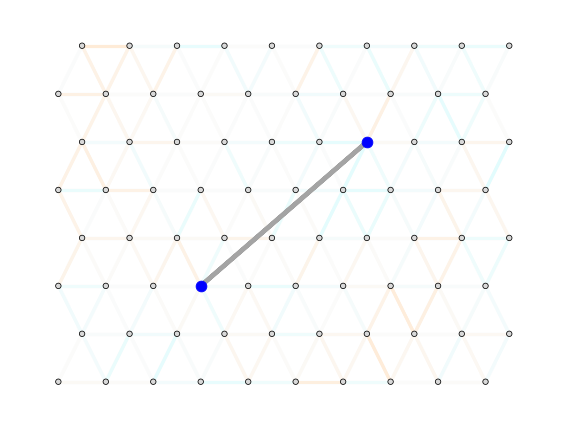

In [47]:
# sp_graph.fit(lamb=1.,optimize_q='n-dim')
sp_graph.fit(lamb=2.,optimize_q='n-dim',option='onlyc',long_range_edges=[(23,56)]); sp_graph.c
fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, obs_node_zorder=2,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=4, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=True); v.draw_obs_nodes(); 
v.draw_arrow([(23,56)],sp_graph.c-0.1,fs=8,mode='sampled',lw=3,hl=2,hw=500)
# ax.scatter(v.grid[22,0],v.grid[22,1],marker='x',color='k',zorder=2,s=50); ax.scatter(v.grid[56,0],v.grid[56,1],marker='x',color='k',zorder=2,s=50);
ax.scatter(v.grid[23,0],v.grid[23,1],marker='o',color='b',zorder=2,s=50); ax.scatter(v.grid[56,0],v.grid[56,1],marker='o',color='b',zorder=2,s=50);

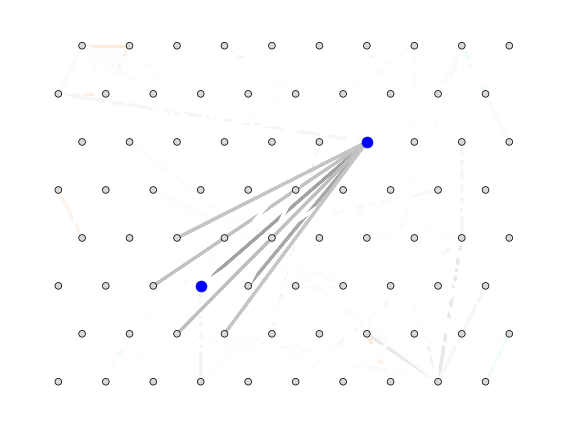

In [50]:
# plt.style.use('fivethirtyeight')
# lrn=[(23,56)]
# plt.plot(grid_def[:,0],grid_def[:,1],'o',color='grey',alpha=0.8); plt.box(False); plt.tick_params(left = False, labelleft = False, labelbottom = False, bottom = False); plt.grid()
# plt.plot(grid_def[lrn[0][0],0],grid_def[lrn[0][0],1],'bo'); plt.plot(grid_def[lrn[0][1],0],grid_def[lrn[0][1],1],'bo'); plt.box(False); plt.tick_params(left = False, labelleft = False, labelbottom = False, bottom = False); plt.grid()
# for ie, e in enumerate(randedge):
#     plt.plot((grid_def[randedge[ie][0],0],grid_def[randedge[ie][1],0]),(grid_def[randedge[ie][0],1],grid_def[randedge[ie][1],1]),color='{}'.format(1-np.abs(isc2[ie]-truew[ie])),markersize=1)
# plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=mpl.cm.Greys), orientation='vertical', label=r'$ |\hat c - c_{sim}|$')
# plt.style.use('seaborn-whitegrid')

fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, obs_node_zorder=2,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=6, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=True); v.draw_obs_nodes(); 
ax.scatter(v.grid[23,0],v.grid[23,1],marker='o',color='b',zorder=2,s=50); ax.scatter(v.grid[56,0],v.grid[56,1],marker='o',color='b',zorder=2,s=50);
for ie in range(len(randedge)):
    v.draw_arrow([randedge[ie]],0.5-np.abs(isc2[ie]-0.6),fs=8,mode='sampled')
    # v.draw_arrow([randedge[ie]],np.abs(-isc2[ie]+np.max(isc2))/1000-0.1,lw=1,hl=2,hw=5,mode='sampled')
# ax.scatter(v.grid[53,0],v.grid[53,1],marker='x',color='b'); ax.scatter(v.grid[56,0],v.grid[56,1],marker='x',color='b');
# ax.tricontourf([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],isc2,cmap='Greys',vmax=1,vmin=0,alpha=0.8,levels=5); 
# CS = ax.tricontour([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],isc2,cmap='Greys',vmax=1,vmin=0,alpha=0.8,levels=5); ax.clabel(CS, inline=1, fontsize=8, colors='k')

# fig = plt.figure(dpi=110)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, obs_node_zorder=2,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=4, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True); v.draw_obs_nodes(); 
# ax.tricontourf([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=[-100,-20,-2,0],extend='max',cmap='Greens',alpha=0.7); CS = ax.tricontour([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=[-100,-20,-2,0],cmap='Greens',alpha=0.7); ax.clabel(CS, inline=1, fontsize=8, colors='k')
# ax.scatter(v.grid[23,0],v.grid[23,1],marker='x',color='b'); ax.scatter(v.grid[56,0],v.grid[56,1],marker='x',color='b');

(0.0, 1.0)

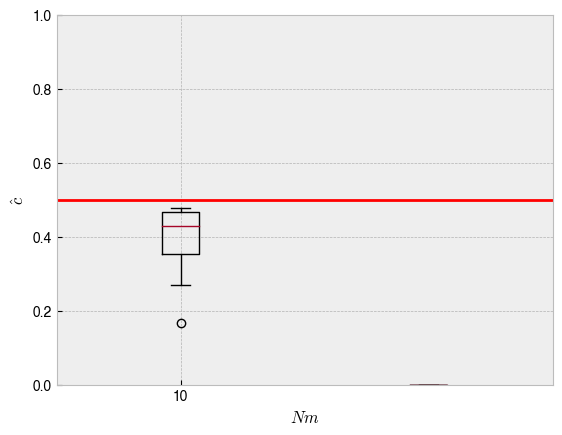

In [284]:
plt.boxplot(estchalf[:,:2]); plt.xticks(ticks=range(1,2),labels=['10']); plt.xlabel(r'$N m$'); plt.ylabel(r'$\hat c$'); plt.axhline(0.5,color='red'); plt.ylim((0,1))

In [277]:
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=0.5, barrier_w=0.5, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=30)
# foo = lambda c: simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=300, long_range_nodes=lrn, admixture_props=[c], n_e=10, time_of_adm=[0.000001])
# gen_test_80 = Parallel(n_jobs=16)(delayed(foo)(0.5) for _ in range(16))
# for n in range(16):
#     sp_graph = FEEMSmix_SpatialGraph(gen_test_80[n], coord_def, grid_def, edge_def, scale_snps=True)
#     sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', verbose=False)
#     obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
#     print(sp.optimize.minimize(obj.neg_log_lik_c,x0=[0.5],args=({'lre':[(8,27)],'mode':'sampled'}),bounds=[(0,1)],method='Nelder-Mead').x)
# np.mean([[0.48291016],[0.45771484],[0.41660156],[0.49550781],[0.51191406],[0.51865234],[0.46044922],[0.52578125],[0.60126953],[0.46572266],[0.43710937],[0.43369141],[0.52558594],[0.57353516],[0.57148438],[0.47109375]])

array([0.54453125])

In [283]:
n_rows, n_columns = 6, 6
estchalf = np.zeros((10,5))
for iNm, Nm in enumerate([(100,1e-4),(100,1e-3),(100,1e-2)]):
    # print(Nm[0], Nm[1])
    # graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=Nm[1], barrier_w=Nm[1], barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=30)
    # foo = lambda c: simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=300, long_range_nodes=lrn, admixture_props=[c], n_e=Nm[0], time_of_adm=[0.000001])
    # gen_test_80 = Parallel(n_jobs=10)(delayed(foo)(0.5) for _ in range(10))
    for n in range(10):
        # np.savetxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c{}_Ne100_sim{}.csv".format(50,n),gen_test_80[n],delimiter=',',fmt='%f')
        # gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c{}_Ne10_sim{}.csv".format(50,n),delimiter=',')
        sp_graph = FEEMSmix_SpatialGraph(gen_test_80[n], coord_def, grid_def, edge_def, scale_snps=True)
        sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', verbose=False)
        obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
        estchalf[n,iNm] = sp.optimize.minimize(obj.neg_log_lik_c,x0=[0.5],args=({'lre':[(8,27)],'mode':'sampled'}),bounds=[(0,1)],method='Nelder-Mead').x
        print(estchalf[n,iNm])

0.37783203124999987
0.45205078125
0.26943359374999987
0.34560546874999987
0.1672851562499997
0.4662109375
0.47724609374999993
0.4662109375
0.4078124999999999
0.4682617187499999


In [279]:
## starting fresh with a simple 6x6 grid to see if the computed log-lik from FEEMS is correlated with my function
# n_rows, n_columns = 6, 6
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1e-3, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=30)

lrn = [(8,27)] # lrn=[(23,92),(101,36)]
# gen_test_36_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1500, n_print=1000, mu=1, Ne=1, long_range_nodes=[(32,2)], admixture_props=[0.0], time_of_adm=[0.000001])
# gen_test_80_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1200, n_print=1000, mu=1e-3, long_range_nodes=[(23,56)], admixture_props=[0.6], time_of_adm=[10], Ne=1000) # Ne=1,100,1000,10000: 1.5mins
# gen_test_128 = simulate_genotypes(graph_def, target_n_snps=1500, n_print=1000, mu=1)
# sp_graph = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def, long_range_edges=[(23,56)])
# sp_graph.fit(lamb=3.,optimize_q='n-dim'); obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 

# estcR2mat = np.zeros((16,5)) 
estcllmat = np.zeros((16,5))
# trueid = np.zeros((16,5))
for ic, truec in enumerate([0,0.25,0.5,0.75,1.]):
    for n in range(16):
        ## gen_test_36_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=900, mu=1, long_range_nodes=lrn, admixture_props=[truec], time_of_adm=[0.000001])
        # np.savetxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c{}_sim{}.csv".format(int(truec*100),n),gen_test_36_adm,delimiter=',',fmt='%f')
        gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(int(truec*100),n),delimiter=',')
        sp_graph = FEEMSmix_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def, scale_snps=True)
        sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', verbose=False)
        obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
        # sp_graph.fit(lamb=3.,optimize_q='n-dim',option='onlyc', long_range_edges=[(8,27)],verbose=False)
        # estcllmat[n,ic] = sp_graph.c
        estcllmat[n,ic] = sp.optimize.minimize(obj.neg_log_lik_c,x0=[0.5],args=({'lre':[(8,27)],'mode':'sampled'}),bounds=[(0,1)],method='Nelder-Mead').x
        print(estcllmat[n,ic])
        # fit_cov, _, emp_cov = comp_mats(obj)
        # fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
        # emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
        # estcllmat[n,ic] = -2*(llnull+obj.neg_log_lik_c(sp_graph.c))
        # estcllmat[n,ic] = sp.stats.norm.cdf(np.min(np.log(emp_dist/fit_dist)),np.mean(np.log(emp_dist/fit_dist)),np.std(np.log(emp_dist/fit_dist)))
        # Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
        # Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
        # resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
        # llnull = sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)
        # sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3, option='joint', long_range_edges=lrn, verbose=False)
        # estcR2mat[n,ic] = sp_graph.c

        # if truec>0:
        #     lle, te = get_best_lre(sp_graph,k=1,top=20)
        #     sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', long_range_edges=lrn, verbose=False); sp_graph.fit(lamb=3.,optimize_q='n-dim',option='onlyc', long_range_edges=[te.iloc[np.argmax(lle),0]],verbose=False)
        #     obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
        #     estcllmat[n,ic] = -2*(llnull+obj.neg_log_lik_c(sp_graph.c))
        #     if te.iloc[np.argmax(lle),0]==(8,27):
        #         trueid[n,ic] = 1

LinAlgError: 27-th leading minor of the array is not positive definite

In [781]:
# estcllmat[:,0] = np.random.choice(cestsig,16)
# estcllmat[:,0] = -2*(llrand[:16,0]-llsig[:16])
# trueid.sum(axis=0)
# estcllmat[trueid[:,1]==1,1], estcllmat[trueid[:,1]==0,1]
# gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(50,13),delimiter=',')
# sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', verbose=False)
# obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
# sp_graph.fit(lamb=3.,optimize_q='n-dim',option='onlyc', long_range_edges=[(11,7)],verbose=False); sp_graph.c
# fit_cov, _, emp_cov = comp_mats(obj)
# fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
# emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
# X = sm.add_constant(np.log(fit_dist))
# mod = sm.OLS(np.log(emp_dist), X)
# res = mod.fit()
# muhat, betahat = res.params
# plt.plot(fit_dist, emp_dist, 'o', color='grey', alpha=0.5, markersize=4); plt.plot(fit_dist, betahat*fit_dist+muhat, color='orange', ls='--', lw=1)
# plt.text(1, 0.3, r'$R^2 \approx {}$'.format(np.around(res.rsquared_adj,2)), fontsize=15); plt.title(r'$c=0.25$'); plt.xlabel('fit distance'); plt.ylabel('empirical distance')

# reswt = sm.WLS(emp_dist, X, weights=fit_dist).fit()
# muw, betaw = reswt.params
# plt.plot(fit_dist, emp_dist, 'o', color='grey', alpha=0.5, markersize=4); plt.plot(fit_dist, betaw*fit_dist+muw, color='orange', ls='--', lw=1)
# plt.text(1, 0.3, r'$R^2 \approx {}$'.format(np.around(reswt.rsquared_adj,2)), fontsize=15); plt.title(r'$c=0.25$'); plt.xlabel('fit distance'); plt.ylabel('empirical distance')

# sp.stats.linregress(np.log(fit_dist), np.log(emp_dist))

array([[0.0762726 , 0.10762763, 0.07681014, ..., 0.08422624, 0.06719912,
        0.06090216],
       [0.0762726 , 0.10762763, 0.07681014, ..., 0.08422624, 0.06719912,
        0.06090216],
       [0.0762726 , 0.10762763, 0.07681014, ..., 0.08422624, 0.06719912,
        0.06090216],
       ...,
       [0.0762726 , 0.10762763, 0.07681014, ..., 0.08422624, 0.06719912,
        0.06090216],
       [0.0762726 , 0.10762763, 0.07681014, ..., 0.08422624, 0.06719912,
        0.06090216],
       [0.0762726 , 0.10762763, 0.07681014, ..., 0.08422624, 0.06719912,
        0.06090216]])

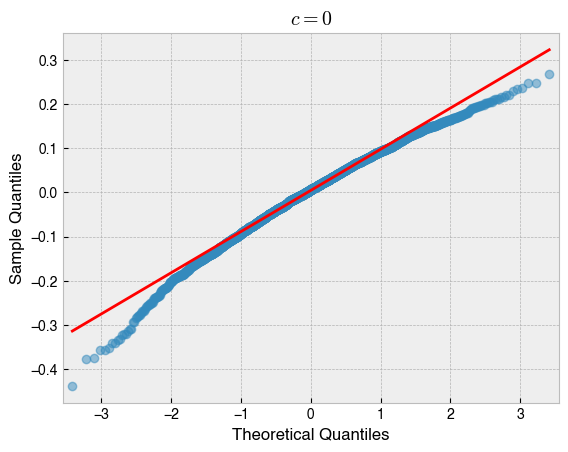

In [728]:
# from statsmodels.stats.diagnostic import het_white
# from statsmodels.stats.outliers_influence import OLSInfluence as olsi
# het_white(reswt.resid,X)
# res.get_robustcov_results(cov_type='HC0').pvalues
# studentized_residuals = olsi(reswt).resid_studentized
# leverage_pts = olsi(reswt).hat_matrix_diag
# cook_dist = olsi(reswt).cooks_distance

# sm.graphics.influence_plot(reswt, alpha  = 1e-6, criterion="cooks", plot_alpha=0.5)
# k = 61; x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1; y = int(k - 0.5*x*(x-1)); print(x, y)
# sns.residplot(x=X, y=emp_dist, lowess=True, color='grey'); 
# plt.plot(fit_dist,reswt.resid,'ko',alpha=0.3); plt.plot(fit_dist,res.resid,'bx',alpha=0.3)
# sm.OLS(emp_dist/fit_dist, fit_dist).fit().summary()
# plt.plot(emp_dist/fit_dist,fit_dist,'ko',alpha=0.3); 
# plt.plot(fit_dist,emp_dist/fit_dist-np.mean(emp_dist/fit_dist),'ko'); plt.axhline(np.mean(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),color='grey'); plt.title(r'$c=0$'); plt.axhline(-4*np.std(emp_dist/fit_dist),color='grey',ls='--'); plt.xlabel('fit dist'); plt.ylabel('emp dist/fit dist')
# plt.plot(fit_dist,emp_dist/fit_dist-np.mean(emp_dist/fit_dist),'ko'); plt.axhline(np.mean(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),color='grey'); plt.title(r'$c=0$'); plt.axhline(-3*np.std(emp_dist/fit_dist),color='grey',ls='--'); plt.xlabel('fit dist'); plt.ylabel('emp dist/fit dist')
# plt.hist(emp_dist/fit_dist-np.mean(emp_dist/fit_dist),15,color='grey'); plt.axvline(-4*np.std(emp_dist/fit_dist),color='grey',ls='--')
# np.where(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)<-3*np.std(emp_dist/fit_dist))
# sm.qqplot(np.log(emp_dist/fit_dist)-np.mean(np.log(emp_dist/fit_dist)),line='q',alpha=0.5); plt.title(r'$c=0$'); 
# sm.qqplot(np.log(emp_dist/fit_dist)-np.mean(np.log(emp_dist/fit_dist)),loc=0,scale=np.std(np.log(emp_dist/fit_dist)),line='q',alpha=0.5); plt.title(r'$c=0.5$');
# plt.hist(np.log(emp_dist/fit_dist)-np.mean(np.log(emp_dist/fit_dist)),15,color='grey'); plt.axvline(-4*np.std(np.log(emp_dist/fit_dist)),color='grey',ls='--')

# sp.stats.norm.cdf(np.min(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),np.mean(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),np.std(emp_dist/fit_dist))

In [255]:
# cestrand = np.zeros(50); cestsig = np.zeros(50); llrand = np.zeros((50,2)); llsig = np.zeros(50)
## 1. try fewer loci to see how it could effect the results (it bad...)
## 2. try a 70-30 split of the data for getting oulier edges and for estimating the admixture proportion
for n in range(50):
    gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(0,n),delimiter=',')
    print('In sim {}:'.format(n))

    idx = rng.choice(range(gen_test_36_adm.shape[1]),1000,replace=False)
    bootgenotypes = gen_test_36_adm[:,idx]
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)
    sp_graph = Joint_SpatialGraph(bootgenotypes, coord_def, grid_def, edge_def)
    sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3, verbose=False); obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
    # llrand[n,0] = sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)

    lle, te = get_best_lre(sp_graph,k=1,top=5)

    bootgenotypes = gen_test_36_adm[:,list(set(range(gen_test_36_adm.shape[1]))-set(idx))]
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)

    sp_graph = Joint_SpatialGraph(bootgenotypes, coord_def, grid_def, edge_def)
    sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3, verbose=False); obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
    llrand[n,0] = sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T) 
    sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3,option='onlyc',long_range_edges=[te.iloc[np.argmax(lle),0]],verbose=False); 
    obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
    llsig[n] = -obj.neg_log_lik_c(sp_graph.c); cestsig[n] = sp_graph.c

    sp_graph = Joint_SpatialGraph(bootgenotypes, coord_def, grid_def, edge_def)
    randedge = [tuple(np.random.choice(range(36),size=2,replace=False)) for _ in range(1)]
    randedge = list(set(randedge)-set(sp_graph.edges) - set(te.iloc[np.argmax(lle),0])); 
    if len(randedge) == 0:
        randedge = [(8,27)]
    sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3, verbose=False); 
    sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3,option='onlyc',long_range_edges=randedge,verbose=False); obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
    # print('random edge is: ',randedge)
    llrand[n,1] = -obj.neg_log_lik_c(sp_graph.c); cestrand[n] = sp_graph.c
    # print(sp_graph.c)

In sim 0:
Starting search for edge 1...
Potential deme A:
6    3
1    2
Name: A, dtype: int64
Potential deme B:
34    2
33    2
11    1
Name: B, dtype: int64
(6, 34)
(6, 11)
(1, 34)
(1, 33)
(6, 33)
(34, 6), found at index 0.
admixture proportions:
[0.083]
In sim 1:
Starting search for edge 1...
Potential deme A:
23    2
25    1
11    1
Name: A, dtype: int64
Potential deme B:
25    1
29    1
24    1
Name: B, dtype: int64
(23, 25)
(25, 29)
(11, 24)
(23, 31)
(8, 35)
(35, 8), found at index 4.
admixture proportions:
[0.081]
In sim 2:
Starting search for edge 1...
Potential deme A:
24    2
12    1
30    1
Name: A, dtype: int64
Potential deme B:
34    3
35    2
Name: B, dtype: int64
(24, 34)
(12, 34)
(24, 35)
(30, 34)
(18, 35)
(35, 18), found at index 4.
admixture proportions:
[0.084]
In sim 3:
Starting search for edge 1...
Potential deme A:
11    1
7     1
1     1
Name: A, dtype: int64
Potential deme B:
11    3
18    2
Name: B, dtype: int64
(11, 18)
(7, 11)
(1, 11)
(6, 11)
(17, 18)
(11, 7),

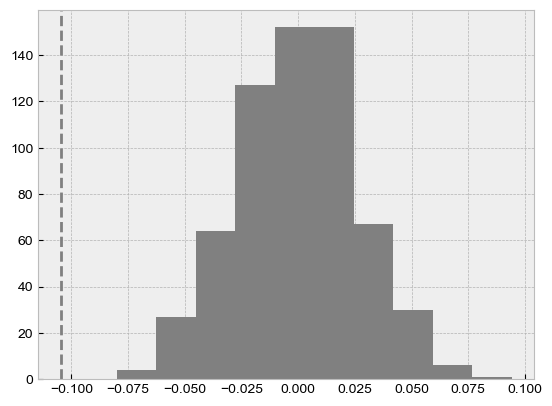

In [215]:
# plt.hist(cestrand,color='k',alpha=0.5,label='random edge'); plt.hist(cestsig,color='g',alpha=0.5,label='top outlier edge'); plt.legend(); plt.xlabel(r'$\hat{c}$')

# plt.hist(-2*(llrand[:,0]-llrand[:,1]),color='k',alpha=0.5,label='random edge'); plt.hist(-2*(llrand[:,0]-llsig),color='g',alpha=0.5,label='top outlier edge'); plt.legend(); plt.xlabel(r'$\lambda_{LR}$'); plt.axvline(6.5,color='grey',ls='--')
# plt.hist(cestrand[np.where(-2*(llrand[:,0]-llrand[:,1])>7)[0]],color='k',alpha=0.6,label='random edge'); plt.hist(cestsig[np.where(-2*(llrand[:,0]-llsig)>7)[0]],color='g',alpha=0.5,label='top outlier edge'); plt.legend(); plt.xlabel(r'$\hat{c}$'); plt.title('edges with p<0.01')
# sp.stats.chi2.sf(30,1)

# plt.hist(sp.stats.chi2.sf(-2*(llrand[:,0]-llsig),1),bins=25,color='g',alpha=0.5,label='top outlier edge'); plt.hist(sp.stats.chi2.sf(-2*(llrand[:,0]-llrand[:,1]),1),color='k',alpha=0.5,label='random edge',bins=25); plt.legend(); plt.xlabel(r'p-val');

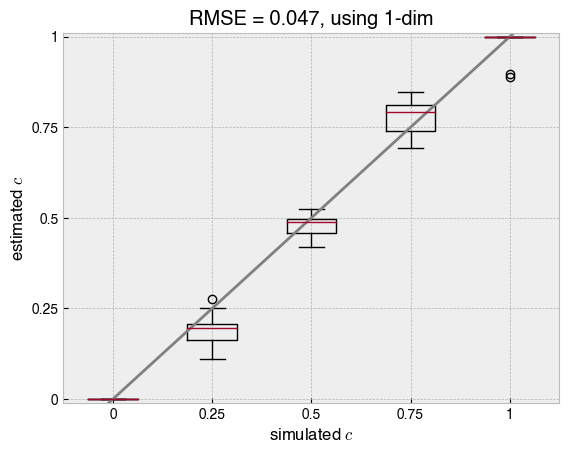

In [269]:
# plt.boxplot(estcR2mat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.ylim((-0.01,1.01)); plt.title(r'RMSE = %.3f, joint optim w/ $L^{-1} M L^{-1,T}$'%np.round(np.sqrt(np.mean((estcR2mat-np.array([0,0.25,0.5,0.75,1]))**2)),3)); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.show() #plt.axline((1,0),slope=0.25,color='grey'); 
plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.ylim((-0.01,1.01)); plt.title(r'RMSE = {}, using 1-dim'.format(np.round(np.sqrt(np.mean((estcllmat-np.array([0,0.25,0.5,0.75,1]))**2)),3))); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.axline((1,0),slope=0.25,color='grey'); 
# plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel('p-value'); plt.axhline(1e-4,color='grey',ls='--'); plt.semilogy(); plt.title('top outlier edge')
# np.sum(estcllmat[:,0]<5e-3)
# plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel('LL(correct) - LL(wrong)'); plt.axhline(1.,color='grey',ls='--'); 

# df = pd.DataFrame(np.random.rand(32,5), columns=[0,0.25,0.5,0.75,1])
# df['E'] = [r'joint optim, RMSE$ = 0.19$']*16+[r'stepwise optim, RMSE$ = 0.04$']*16
# df.iloc[:16,:5] = estcR2mat
# df.iloc[16:,:5] = estcllmat
# sns.violinplot(df.melt(id_vars=['E'], value_vars=[0,0.25,0.5,0.75,1]), cut=0, inner='box',x='variable', y='value', hue='E', palette='Set2'); plt.xlabel(r'simulated $c$'); plt.legend(loc='upper left'); plt.ylabel(r'estimated $c$'); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.show()

In [1487]:
# np.sqrt(np.mean((df.iloc[16:,:5] - np.repeat([0,0.25,0.5,0.75,1],16).reshape(-1,5,order='F'))**2))
# 10/sp_graph.s2[:10], sp_graph.q[:10]

(36,)

In [ ]:
# lamb_grid = np.geomspace(1e-1,100,10,endpoint=True)[::-1]
# cvq_err = run_cv_joint(sp_graph, lamb_grid=lamb_grid, lamb_q_grid=lamb_grid)
# print(lamb_grid[np.argmin(np.mean(cvq_err,axis=(0,2)))], lamb_grid[np.argmin(np.mean(cvq_err,axis=(0,1)))])
# plt.plot(lamb_grid,np.mean(cvq_err,axis=(0,1)),'k-o',label=r'$\lambda_w$'); plt.xlabel('values'); plt.ylabel('LOO CV error'); plt.plot(lamb_grid,np.mean(cvq_err,axis=(0,2)),'-o',color='grey',label=r'$\lambda_q$'); plt.semilogx(); plt.legend(); 
# sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def, long_range_edges=[(8,27)],c=0.2);
# sp_graph.fit(lamb=3.,optimize_q='n-dim',option='joint',lamb_q=3.,alpha_q=.3); sp_graph.c
# sp.optimize.minimize_scalar(get_grad_FEEMS_demes_nll_w_c,args=({'sp_graph':sp_graph,'obj':obj,'lrn':lrn}),bounds=(0,1),method='bounded').x

### Methods that DO NOT penalize long range edges (test the code here...)

The idea being that currently fitting graphs with many long range edges causes convergence issues, so we want to be able to add edges to the graph that are not constrained.

This will involve removing the penalty term + gradient term for these long range edges. Just need to index it correctly. 

In [ ]:
# edges_lr = deepcopy(edge_def)
# edges_lr = edges_lr.tolist()
# edges_lr.append(list(x+1 for x in (8,27)))
# sp_graph_lr = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, np.array(edges_lr), long_range_edges=[(23,56)])
# sp_graph_lr.fit(lamb=3., optimize_q='n-dim')
# plt.hist(sp_graph_lr.w); plt.axvline(sp_graph_lr.w[25],color='k')
# obj_lr = Joint_Objective(sp_graph_lr); obj_lr.lamb = 3.; obj_lr.alpha = 0.5
# obj_lr.inv(); obj_lr.grad(reg=True)

estwsmat = np.zeros((14,30)); estwdmat = np.zeros_like(estwsmat)[:12,:] # 0:7 rows-penalizing LRE, 7:14 rows-not (dest mat does not need LRE again)
for ic, truec in enumerate([0]*10+[0.5]*10+[1]*10):
    gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(int(truec*100),ic%10),delimiter=',')
    sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, np.array(edges_lr)); sp_graph.fit(lamb=3.,optimize_q='n-dim', verbose=False); 
    for idn, n in enumerate([2, 3, 7, 9, 14, 15, 27]):
        if n<8:
            estwsmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((n,8))]
        else:
            estwsmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((8,n))]
    for idn, n in enumerate([20, 21, 26, 28, 33, 32]):
        if n<27:
            estwdmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((n,27))]
        else:
            estwdmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((27,n))]

    sp_graph_lr = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, np.array(edges_lr), long_range_edges=[(8,27)]) 
    try: 
        sp_graph_lr.fit(lamb=3.,optimize_q='n-dim', verbose=False); 
    except:
        sp_graph_lr.fit(lamb=4.,optimize_q='n-dim', verbose=False); 
    for idn, n in enumerate([2, 3, 7, 9, 14, 15, 27]):
        if n<8:
            estwsmat[idn+7,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((n,8))]
        else:
            estwsmat[idn+7,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((8,n))]
    for idn, n in enumerate([20, 21, 26, 28, 33, 32]):
        if n<27:
            estwdmat[idn+6,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((n,27))]
        else:
            estwdmat[idn+6,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((27,n))]
# fig = plt.figure(dpi=110)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph_lr, projection=ccrs.Mercator(), edge_width=2, #weights=w,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True)
# v.draw_obs_nodes(use_ids=False)
# # get_best_lre(sp_graph, gen_test_128_adm, coord_def, grid_def, edge_def, k=2, top=10)

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:56: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.Delta_q = nx.incidence_matrix(self, oriented=True).T.tocsc()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:59: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.adj_base = sp.triu(nx.adjacency_matrix(self), k=1)
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:65: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:69: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:187: RuntimeWarning: invalid value encountered in lo

In [ ]:
estwsmat = np.zeros((18,30)); estwdmat = np.zeros_like(estwsmat) # 0:7 rows-penalizing LRE, 7:14 rows-not (dest mat does not need LRE again)
os.chdir("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture")
for ic, truec in enumerate([0]*10+[0.5]*10+[1]*10):
    gen_test_36_adm = np.loadtxt("gentest36_c{}_sim{}.csv".format(int(truec*100),ic%10),delimiter=',')
    sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def); sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default',verbose=False); 
    for idn, n in enumerate([2, 3, 7, 9, 14, 15]):
        if n<8:
            estwsmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((n,8))]
        else:
            estwsmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((8,n))]
    for idn, n in enumerate([20, 21, 26, 28, 33, 32]):
        if n<27:
            estwdmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((n,27))]
        else:
            estwdmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((27,n))]

    sp_graph_lr = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def)
    sp_graph_lr.fit(lamb=3., optimize_q='n-dim', verbose=False, long_range_edges=[(8,27)], option='joint'); 
    sp_graph_lr.fit(lamb=3.,optimize_q='n-dim', option='onlyc', long_range_edges=[(8,27)], verbose=False)
    for idn, n in enumerate([2, 3, 7, 9, 14, 15]):
        if n<8:
            estwsmat[idn+6,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((n,8))]
        else:
            estwsmat[idn+6,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((8,n))]
    for idn, n in enumerate([20, 21, 26, 28, 33, 32]):
        if n<27:
            estwdmat[idn+6,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((n,27))]
        else:
            estwdmat[idn+6,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((27,n))]

    sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def); sp_graph.fit(lamb=3.,optimize_q='n-dim', option='joint', long_range_edges=[(8,27)], verbose=False); 
    for idn, n in enumerate([2, 3, 7, 9, 14, 15]):
        if n<8:
            estwsmat[idn+12,ic] = sp_graph.w[list(sp_graph.edges).index((n,8))]
        else:
            estwsmat[idn+12,ic] = sp_graph.w[list(sp_graph.edges).index((8,n))]
    for idn, n in enumerate([20, 21, 26, 28, 33, 32]):
        if n<27:
            estwdmat[idn+12,ic] = sp_graph.w[list(sp_graph.edges).index((n,27))]
        else:
            estwdmat[idn+12,ic] = sp_graph.w[list(sp_graph.edges).index((27,n))]

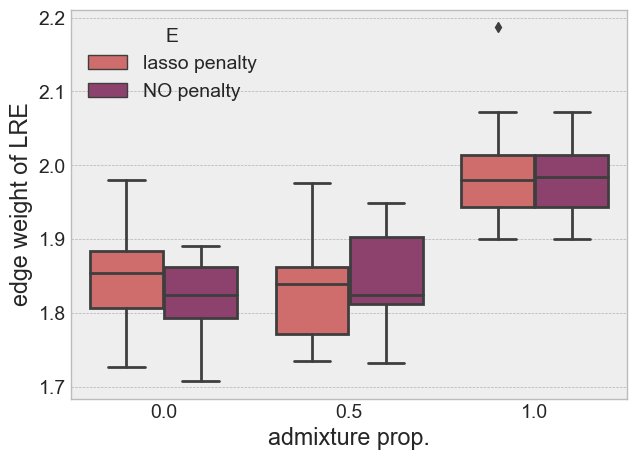

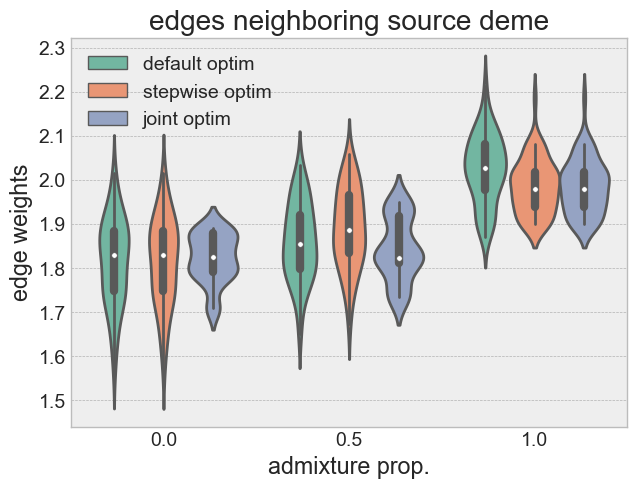

Ttest_indResult(statistic=5.84561729831843, pvalue=1.3977902153261863e-07)

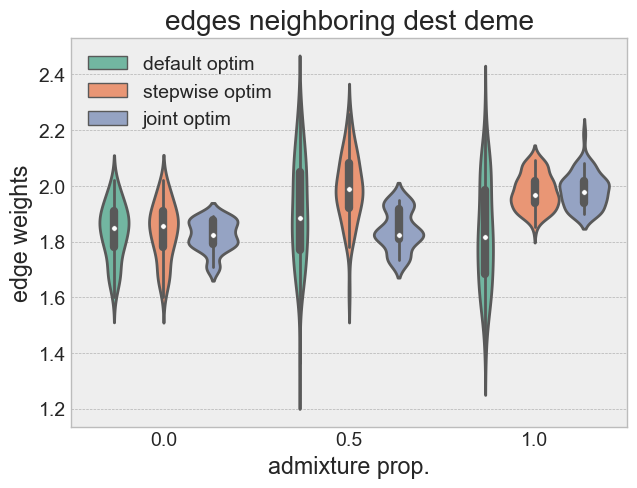

In [ ]:
## Delta is shape inds x edges
# df = pd.DataFrame(np.random.rand(20,3), columns=[0,0.5,1])
# df['E'] = ['lasso penalty']*10+['NO penalty']*10
# df.iloc[:10,0:3] = estwsmat[6,:].reshape(10,-1,order='F')
# df.iloc[10:,0:3] = estwsmat[13,:].reshape(10,-1,order='F')
# sns.boxplot(df.melt(id_vars=['E'], value_vars=[0,0.5,1]), x='variable', y='value', hue='E', palette='flare'); plt.xlabel('admixture prop.'); plt.ylabel('edge weight of LRE'); plt.show()

df2s = pd.DataFrame(np.random.rand(180,3), columns=[0,0.5,1])
df2s['E'] = ['default optim']*60+['stepwise optim']*60+['joint optim']*60
df2s.iloc[:60,0:3] = estwsmat[:6,:].reshape(60,-1,order='F')
df2s.iloc[60:120,0:3] = estwsmat[6:12,:].reshape(60,-1,order='F')
df2s.iloc[120:,0:3] = estwsmat[12:,:].reshape(60,-1,order='F') ## .loc[df2s['E'].isin(['default optim','stepwise optim'])]
sns.violinplot(df2s.melt(id_vars=['E'], value_vars=[0,0.5,1]), x='variable', y='value', hue='E', palette='Set2'); plt.legend(loc='upper left')
plt.xlabel('admixture prop.'); plt.ylabel('edge weights'); plt.title('edges neighboring source deme'); plt.show()
sp.stats.ttest_ind(df2s.iloc[0:60,2],df2s.iloc[120:,2],equal_var=False)

df2d = pd.DataFrame(np.random.rand(180,3), columns=[0,0.5,1])
df2d['E'] = ['default optim']*60+['stepwise optim']*60+['joint optim']*60
df2d.iloc[:60,0:3] = estwdmat[0:6,:].reshape(60,-1,order='F')
df2d.iloc[60:120,0:3] = estwdmat[6:12,:].reshape(60,-1,order='F')
df2d.iloc[120:,0:3] = estwsmat[12:,:].reshape(60,-1,order='F')
sns.violinplot(df2d.melt(id_vars=['E'], value_vars=[0,0.5,1]), x='variable', y='value', hue='E', palette='Set2'); plt.legend(loc='upper left'); 
plt.xlabel('admixture prop.'); plt.ylabel('edge weights'); plt.title('edges neighboring dest deme')
sp.stats.ttest_ind(df2d.iloc[60:120,2],df2d.iloc[:60,2],equal_var=False)

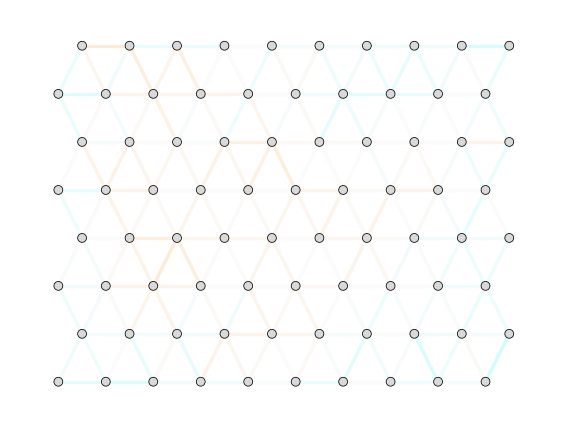

In [115]:
fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, #weights=w,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
# get_best_lre(sp_graph, gen_test_36_adm, coord_def, grid_def, edge_def, k=2, top=20)
# max_res_nodes = [(8, 27), (3, 27), (2, 27), (7, 27), (9, 27), (1, 27), (5, 27), (6, 27), (14, 27), (15, 27), (13, 27), (0, 27), (12, 27), (4, 27), (5, 18), (10, 27), (11, 27), (18, 27), (5, 12), (5, 32)]
# ss = []; dd = []
# for e in max_res_nodes:
#     ss.append(e[0]); dd.append(e[1])
# for d in np.unique(dd):
#     print(np.sum(dd==d))
# df.d.value_counts()
# v.draw_edge_colorbar()
# v.draw_c_colorbar()

## Demes with small sample sizes

Scenarios:
1. NO long range edges but with few demes with small samples (<10% of larger demes)
2. ONE long range edge but between demes with large samples 

In [ ]:
# n_rows, n_columns = 8, 10
# smallnodes = [12, 62,  9, 37, 25, 48, 53, 76]
# graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, option=2, ss=[4 if i in smallnodes else 40 for i in range(80)]) 
# gen_test_1e = simulate_genotypes(graph, target_n_snps=1500, n_print=1000)

# sp_Graph = Joint_SpatialGraph(gen_test_80, coord_def, grid_def, edge_def)
# sp_Graph.fit(lamb=3., optimize_q='n-dim')
# obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

# print(get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1, top=20))

# lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1)

# nreps = 30
# fit_dist = np.zeros((sp_Graph.n_observed_nodes*(sp_Graph.n_observed_nodes-1)//2,nreps+1)); emp_dist = np.zeros_like(fit_dist)
# ss = rng.bit_generator._seed_seq; child_states = ss.spawn(nreps)
# fit_cov, _, emp_cov = comp_mats(obj)
# fit_dist[:,0] = cov_to_dist(fit_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]
# emp_dist[:,0] = cov_to_dist(emp_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]

for n in range(1,nreps+1):
    bootgenotypes = deepcopy(gen_test_80)
    ## if we bootstrap over SNPs, then we can do the below
    ## bootgenotypes[:,rng.choice(range(gen_test_1e.shape[1]),gen_test_1e.shape[1])]
    ## bootstrapping over inds (since this is the source of uncertainty)
    ctr = 0
    for deme in range(sp_Graph.n_observed_nodes):
        bootgenotypes[ctr:(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme]),:] = gen_test_80[rng.choice(range(ctr,(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme])),sp_Graph.n_samples_per_obs_node_permuted[deme],replace=True),:]
        ctr += sp_Graph.n_samples_per_obs_node_permuted[deme]
    ## remove SNPs that are invariant after bootstrapping
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)
    sp_graph_boot = Joint_SpatialGraph(bootgenotypes, coord_def, grid_def, edge_def)
    sp_graph_boot.fit(lamb=3., optimize_q='n-dim', verbose=False)
    obj_boot = Joint_Objective(sp_graph_boot)
    fit_cov, _, emp_cov = comp_mats(obj_boot)
    fit_dist[:,n] = cov_to_dist(fit_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]
    emp_dist[:,n] = cov_to_dist(emp_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:57: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.Delta_q = nx.incidence_matrix(self, oriented=True).T.tocsc()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:60: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.adj_base = sp.triu(nx.adjacency_matrix(self), k=1)


In [1097]:
# X = sm.add_constant(fit_dist[:,0])
# mod = sm.OLS(emp_dist[:,0], X)
# res = mod.fit()
# muhat, betahat = res.params
# # computing the standard errors from before
# se_fit = np.zeros(fit_dist.shape[0]); se_emp = np.zeros_like(se_fit)
# for i in range(fit_dist.shape[0]):
#     se_fit[i] = np.sqrt(np.sum((fit_dist[i,:]-np.mean(fit_dist[i,:]))**2)/(nreps-1))
#     se_emp[i] = np.sqrt(np.sum((emp_dist[i,:]-np.mean(emp_dist[i,:]))**2)/(nreps-1))
# # finding the largest outliers, taking into account the SE might overlap with best-fit line
# max_idx = np.argpartition(res.resid, 100)[:100]
# max_idx = max_idx[np.argsort(res.resid[max_idx])]
# new_max_idx = []
# for i in max_idx:
#     if ((fit_dist[i,0]-se_fit[i])>(emp_dist[i,0]-muhat)/betahat) & ((betahat*fit_dist[i,0]+muhat) > (emp_dist[i,0]+se_emp[i])):
#         new_max_idx.append(i)

# new_max_res_node = []
# for k in new_max_idx:
#     x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
#     y = int(k - 0.5*x*(x-1))
#     new_max_res_node.append(tuple(sorted((x,y))))

# plt.plot(fit_dist[:,0], emp_dist[:,0], 'o', color='grey', alpha=0.3, markersize=4)
# plt.plot(fit_dist[:,0], betahat*fit_dist[:,0]+muhat, color='orange', ls='--', lw=1)
# plt.text(1.5, 0.5, r'$R^2 \approx 0.93$', fontsize=15)
# plt.plot(fit_dist[max_idx,0], emp_dist[max_idx,0], '+', color='black', markersize=8)
# plt.errorbar(fit_dist[new_max_idx[20:],0], emp_dist[new_max_idx[20:],0], yerr=np.random.uniform(3,5,size=80)*se_emp[new_max_idx[20:]], color='k', lw=1, capsize=2, capthick=1, ls='none', alpha=0.5)
# plt.errorbar(fit_dist[new_max_idx[:20],0], emp_dist[new_max_idx[:20],0], yerr=se_emp[new_max_idx[:20]], color='black', lw=1, capsize=2, capthick=1, ls='none')

0.0

In [ ]:
## for the case with NO admixture BUT correction for standard errors
# llinc = np.zeros(30,); topedge = np.zeros((30,3),dtype='int'); 
# n_rows, n_columns = 8, 10
for n in range(4):
    # smallnodes = np.random.choice(range(80),8,replace=False)
    # smallnodes = [12, 62, 9, 37, 25, 48, 53, 76]

    # graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, option=2, ss=[4 if i in smallnodes else 40 for i in range(80)]) 

    # gen_test_1e = simulate_genotypes(graph, target_n_snps=1500, n_print=1200)
    # np.savetxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/gen80small{}.txt'.format(n),gen_test_1e,fmt='%f')
    gen_test_1e = np.loadtxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/gen80small{}.txt'.format(n))

    sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
    sp_Graph.fit(lamb=3., optimize_q='n-dim', verbose=False)
    obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

    ## searching for best outlier node out of 20
    lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
    llinc[n] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2] 
    ee = te.iloc[np.argmax(lle),0]
    if ((ee[0] in smallnodes) & (ee[1] in smallnodes)):
        topedge[n,0] += 1
    elif ((ee[0] in smallnodes) | (ee[1] in smallnodes)):
        topedge[n,1] += 1
    else:
        topedge[n,2] += 1
    
    ## running the bootstrapping mechanism
    nreps = 20
    fit_dist = np.zeros((sp_Graph.n_observed_nodes*(sp_Graph.n_observed_nodes-1)//2,nreps+1)); emp_dist = np.zeros_like(fit_dist)
    ss = rng.bit_generator._seed_seq; child_states = ss.spawn(nreps)
    fit_cov, _, emp_cov = comp_mats(obj)
    fit_dist[:,0] = cov_to_dist(fit_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]
    emp_dist[:,0] = cov_to_dist(emp_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]

    for n in range(1,nreps+1):
        bootgenotypes = deepcopy(gen_test_1e)
        ## if we bootstrap over SNPs, then we can do the below
        ## bootgenotypes[:,rng.choice(range(gen_test_1e.shape[1]),gen_test_1e.shape[1])]
        ## bootstrapping over inds (since this is the source of uncertainty)
        ctr = 0
        for deme in range(sp_Graph.n_observed_nodes):
            bootgenotypes[ctr:(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme]),:] = gen_test_1e[rng.choice(range(ctr,(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme])),sp_Graph.n_samples_per_obs_node_permuted[deme],replace=True),:]
            ctr += sp_Graph.n_samples_per_obs_node_permuted[deme]
        ## remove SNPs that are invariant after bootstrapping
        bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
        bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)
        sp_graph_boot = Joint_SpatialGraph(bootgenotypes, coord, grid, edge)
        sp_graph_boot.fit(lamb=3., optimize_q='n-dim',verbose=False)
        obj_boot = Joint_Objective(sp_graph_boot)
        fit_cov, _, emp_cov = comp_mats(obj_boot)
        fit_dist[:,n] = cov_to_dist(fit_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]
        emp_dist[:,n] = cov_to_dist(emp_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]

    X = sm.add_constant(fit_dist[:,0])
    mod = sm.OLS(emp_dist[:,0], X)
    res = mod.fit()
    muhat, betahat = res.params
    # computing the standard errors from before
    se_fit = np.zeros(fit_dist.shape[0]); se_emp = np.zeros_like(se_fit)
    for i in range(fit_dist.shape[0]):
        se_fit[i] = np.sqrt(np.sum((fit_dist[i,:]-np.mean(fit_dist[i,:]))**2)/(nreps-1))
        se_emp[i] = np.sqrt(np.sum((emp_dist[i,:]-np.mean(emp_dist[i,:]))**2)/(nreps-1))
    # finding the largest outliers, taking into account the SE might overlap with best-fit line
    max_idx = np.argpartition(res.resid, 100)[:100]
    max_idx = max_idx[np.argsort(res.resid[max_idx])]
    new_max_idx = []
    for i in max_idx:
        if ((fit_dist[i,0]-se_fit[i])>(emp_dist[i,0]-muhat)/betahat) & ((betahat*fit_dist[i,0]+muhat) > (emp_dist[i,0]+se_emp[i])):
            new_max_idx.append(i)

    new_max_res_node = []
    for k in new_max_idx:
        x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
        y = int(k - 0.5*x*(x-1))
        new_max_res_node.append(tuple(sorted((x,y))))

    ll_edges = np.zeros((20,)); 
    for ie, e in enumerate(new_max_res_node[:20]):
        edges_t = deepcopy(edge.tolist())
        edges_t.append(list(x+1 for x in e))
        sp_graph_lr = Joint_SpatialGraph(gen_test_1e, coord, grid, np.array(edges_t), long_range_edges=new_max_res_node[ie:(ie+1)])
        sp_graph_lr.fit(lamb=3., optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph_lr.s2),verbose=False)
        obj_lr = Joint_Objective(sp_graph_lr); obj_lr.inv(); 
        ll_edges[ie] = -obj_lr.neg_log_lik()

    print(new_max_res_node[np.argmax(ll_edges)])

    if ee not in new_max_res_node:
        print("sim {}: top edge NOT found after correction. {}/20 left...\n".format(n, np.sum([te.iloc[i,0] in new_max_res_node for i in range(20)])))
    else:
        print("sim {}: {}/20 left...\n".format(n, np.sum([te.iloc[i,0] in new_max_res_node for i in range(20)])))

constant-w/variance fit, converged in 97 iterations, train_loss=-12150.6965079
lambda=3.0000000, alpha=0.7951398, converged in 12 iterations, train_loss=-13052.9709750
Starting search for edge 1...
(12, 37), found at index 0.
constant-w/variance fit, converged in 101 iterations, train_loss=-12294.3420486
lambda=3.0000000, alpha=0.8085983, converged in 9 iterations, train_loss=-14193.3519312
(71, 78)
sim 20: top edge NOT found after correction. 0/20 left...

constant-w/variance fit, converged in 109 iterations, train_loss=-12597.5124677
lambda=3.0000000, alpha=0.7561121, converged in 13 iterations, train_loss=-13365.8670281
Starting search for edge 1...
(37, 70), found at index 12.
constant-w/variance fit, converged in 101 iterations, train_loss=-12658.8789305
lambda=3.0000000, alpha=0.7802661, converged in 11 iterations, train_loss=-14334.4936021
(46, 70)
sim 20: top edge NOT found after correction. 0/20 left...

constant-w/variance fit, converged in 108 iterations, train_loss=-13741.6

Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 114 iterations, train_loss=26694.6687910
lambda=3.0000000, alpha=0.7432497, converged in 9 iterations, train_loss=24770.7137127
constant-w/variance fit, converged in 114 iterations, train_loss=26694.6687910
lambda=3.0000000, alpha=0.7432497, converged in 9 iterations, train_loss=24726.0988225
Starting search for edge 1...
(10, 19), found at index 2.
constant-w/variance fit, converged in 130 iterations, train_loss=26671.6679895
lambda=3.0000000, alpha=0.7897206, converged in 9 iterations, train_loss=24737.2838198
Simulating ~SNP 1000
constant-w/variance fit, converged in 118 iterations, train_loss=24375.5747222
lambda=3.0000000, alpha=0.7594077, converged in 11 iterations, train_loss=22549.6017338
constant-w/variance fit, converged in 118 iterations, train_loss=24375.5747222
lambda=3.0000000, alpha=0.7594077, converged in 12 iterations, train_loss=22512.3157933
Starting search for edge 1...
(20, 47), found at i

/Users/vivaswat/feems/feems/joint_ver.py:75: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswat/feems/feems/joint_ver.py:79: RuntimeWarning: divide by zero encountered in true_divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswat/feems/feems/joint_ver.py:93: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha_q * self.sp_graph.s2 + np.log(term_0)


(31, 37), found at index 5.
constant-w/variance fit, converged in 109 iterations, train_loss=24465.4396872
lambda=3.0000000, alpha=0.8535564, converged in 9 iterations, train_loss=22482.3657553
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 121 iterations, train_loss=24288.9292255
lambda=3.0000000, alpha=0.8004451, converged in 9 iterations, train_loss=22228.1237432
constant-w/variance fit, converged in 121 iterations, train_loss=24288.9292255
lambda=3.0000000, alpha=0.8004451, converged in 9 iterations, train_loss=22178.8651371
Starting search for edge 1...
(7, 9), found at index 8.
constant-w/variance fit, converged in 116 iterations, train_loss=24259.0332885
lambda=3.0000000, alpha=0.8126157, converged in 9 iterations, train_loss=22208.1687858
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 119 iterations, train_loss=26552.6153684
lambda=3.0000000, alpha=0.8054896, converged in 9 iterations, train_loss=24239.8998599
constant

/Users/vivaswat/feems/feems/joint_ver.py:75: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswat/feems/feems/joint_ver.py:79: RuntimeWarning: divide by zero encountered in true_divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswat/feems/feems/joint_ver.py:93: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha_q * self.sp_graph.s2 + np.log(term_0)


(7, 70), found at index 12.
constant-w/variance fit, converged in 112 iterations, train_loss=24813.7208425
lambda=3.0000000, alpha=0.8521788, converged in 9 iterations, train_loss=22873.3675732
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 120 iterations, train_loss=26819.8244709
lambda=3.0000000, alpha=0.7784440, converged in 9 iterations, train_loss=24907.1432253
constant-w/variance fit, converged in 120 iterations, train_loss=26819.8244709
lambda=3.0000000, alpha=0.7784440, converged in 9 iterations, train_loss=24858.0611572
Starting search for edge 1...
(33, 37), found at index 13.
constant-w/variance fit, converged in 117 iterations, train_loss=26746.2388384
lambda=3.0000000, alpha=0.7944864, converged in 10 iterations, train_loss=24878.8607123
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 123 iterations, train_loss=25291.8320730
lambda=3.0000000, alpha=0.7988672, converged in 11 iterations, train_loss=23396.8404836
con

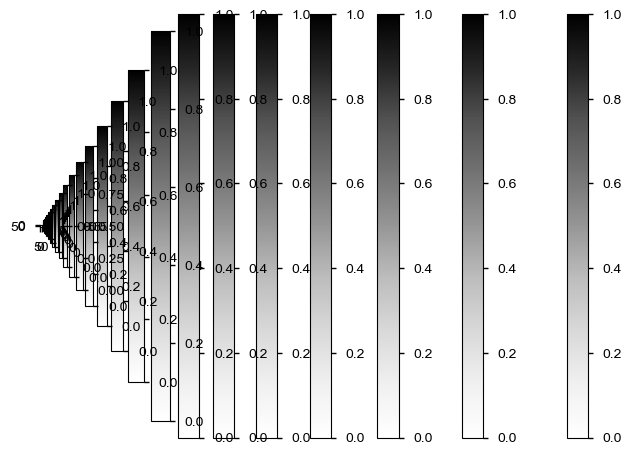

In [ ]:
## for the case with NO admixture
cnt = 0; llinc = np.zeros(20,); topedge = np.zeros((20,3),dtype='int')
### llinc[:25] = deepcopy(llinc_null); topedge[:25,:] = deepcopy(topedge_null)
n_rows, n_columns = 8, 10
for n in range(20):
    # smallnodes = np.random.choice(range(80),8,replace=False)
    smallnodes = [12, 62, 9, 37, 25, 48, 53, 76]
    graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, option=2, ss=[2 if i in smallnodes else 20 for i in range(80)]) 
    # lrn = [(23, 56)]

    gen_test_1e = simulate_genotypes(graph, target_n_snps=1500, n_print=1000)
    # gen_test_1e = simulate_genotypes_w_admixture(graph, target_n_snps=2000, n_print=250, long_range_nodes=lrn, admixture_props=[0.25], time_of_adm=[0.00001])

    sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
    sp_Graph.fit(lamb=3., optimize_q='n-dim')
    obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

    lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
    llinc[n] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2] 
    ee = te.iloc[np.argmax(lle),0]
    if ((ee[0] in smallnodes) & (ee[1] in smallnodes)):
        topedge[n,0] += 1
    elif ((ee[0] in smallnodes) | (ee[1] in smallnodes)):
        topedge[n,1] += 1
    else:
        topedge[n,2] += 1  

Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 133 iterations, train_loss=-35390.0514958
lambda=3.0000000, alpha=0.5743409, converged in 7 iterations, train_loss=-36602.9242113
constant-w/variance fit, converged in 133 iterations, train_loss=-35390.0514958
lambda=3.0000000, alpha=0.5743409, converged in 9 iterations, train_loss=-36108.4227041
Starting search for edge 1...
(23, 56), found at index 1.
constant-w/variance fit, converged in 124 iterations, train_loss=-35432.6499801
lambda=3.0000000, alpha=0.5884000, converged in 7 iterations, train_loss=-36745.6293496
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 131 iterations, train_loss=-35929.1890069
lambda=3.0000000, alpha=0.5891250, converged in 7 iterations, train_loss=-36998.1243836
constant-w/variance fit, converged in 131 iterations, train_loss=-35929.1890069
lambda=3.0000000, alpha=0.5891250, converged in 10 iterations, train_loss=-36566.2673286
Starting search for edg

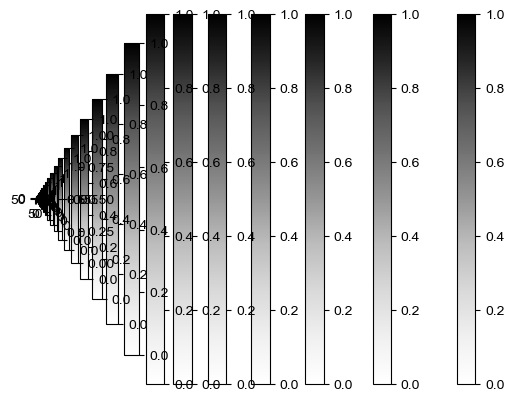

In [ ]:
## for the case with admix prop c = [0.25, 0.5, 0.75]
llinc = np.zeros((2,3)); topedge = pd.DataFrame(index=range(2),columns=['0.2','0.5','0.8'])
# n_rows, n_columns = 8, 10
# graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, n_samples_per_node=30) 
# lrn = [(23, 56)]
for ic, simc in enumerate([0.2,0.5,0.8]):
    for n in range(2):
        gen_test_1e = simulate_genotypes_w_admixture(graph, target_n_snps=1200, n_print=1000, long_range_nodes=lrn, admixture_props=[simc], time_of_adm=[0.0000001])

        sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
        sp_Graph.fit(lamb=3., optimize_q='n-dim')
        obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

        lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
        llinc[n,ic] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2] 
        topedge.iloc[n,ic] = te.loc[np.argmax(lle[:,0])][0]

In [ ]:
res_edges[0]

False

In [ ]:
## for the case with admix prop c = [0.25, 0.5, 0.75] but with bootstrapping
llinc = np.zeros((15,4)); topedge = pd.DataFrame(index=range(15),columns=['0.125','0.25','0.375','0.5']); estc = np.zeros_like(llinc)
# n_rows, n_columns = 8, 10
# graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, n_samples_per_node=20) 
# lrn = [(23, 56)]
# lrnidx = np.zeros((15,3))
# lrnidx_ashr = np.zeros((15,3))
for ic, simc in enumerate([0.125,0.25,0.375,0.5]):
    if ic<3:
        continue
    cntrec = 0; cnttot = 0
    print('for c={}...'.format(simc))
    for n in range(15):
        ## gen_test_1e = simulate_genotypes_w_admixture(graph, target_n_snps=1200, n_print=1000, long_range_nodes=lrn, admixture_props=[simc], time_of_adm=[0.0000001])
        ## np.savetxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/admixprop/gen80c{}sim{}.txt'.format(simc,n),gen_test_1e)

        # gen_test_1e = np.loadtxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/admixprop/gen80c{}sim{}.txt'.format(simc,n))

        sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
        sp_Graph.fit(lamb=3., optimize_q='n-dim', lamb_q=3., alpha_q=0.3, verbose=False); 
        obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

        # res_edges = comp_genetic_vs_fitted_distance(sp_Graph, n_lre=1000, lamb=3., plotFig=False, joint=True)[1]
        try:
            lle, res_edges = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, obj, k=1, nchoose=500)
        except:
            lle, res_edges = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, obj, lamb_cv=.1, k=1, nchoose=500)

        try: 
            print('Found in index: %d'%res_edges[0].tolist().index(lrn[0]))
        except:
            print('Not found in sim %d'%n)

        topedge.iloc[n,ic] = res_edges[0][np.argmax(lle)]
        llinc[n,ic] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2]
        sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge, long_range_edges=[topedge.iloc[n,ic]])
        sp_Graph.fit(lamb=3., optimize_q='n-dim', lamb_q=3., alpha_q=0.3, verbose=False); 
        sp_Graph.fit(lamb=3., optimize_q='n-dim', option='onlyc', lamb_q=3., alpha_q=0.3, verbose=False)
        estc[n,ic] = sp_Graph.c
        # res_edges = get_boot_edges(gen_test_1e,sp_Graph,coord,grid,edge,obj,ntop=600,nchoose=600)
        # res_edges = get_boot_edges(gen_test_1e,sp_Graph,coord,grid,edge,obj,nreps=30,ntop=600,nchoose=1500,option='ashr')
        # try:
        #     lrnidx_ashr[n,ic] = res_edges.index(lrn[0])
        # except:
        #     lrnidx_ashr[n,ic] = 1000
        # cntrec += lrn[0] in res_edges
        # print('{}/{} out of 15'.format(cntrec,cnttot))
    
        # lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
         
        # topedge.iloc[n,ic] = te.loc[np.argmax(lle[:,0])][0]
        # if (23,56) in new_max_res_node:
        #     print('sim {}: lrn not lost under bootstrapping!'.format(n))
        # else:
        #     print('sad :(')

for c=0.5...
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 113 iterations, train_loss=-23498.934
lambda=3.000, alpha=0.5883, converged in 5 iterations, train_loss=-24857.924
Found in index: 0
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 108 iterations, train_loss=-22597.168
lambda=3.000, alpha=0.6281, converged in 5 iterations, train_loss=-23716.981
Found in index: 0
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 120 iterations, train_loss=-23909.087
lambda=3.000, alpha=0.5966, converged in 4 iterations, train_loss=-25124.493
Found in index: 0
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...
(33, 56), found at index 15.
constant-w/variance fit, converged in 116 iterations, train_loss=-23960.894
lambda=3.

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:335: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:339: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))


(23, 56), found at index 0.
constant-w/variance fit, converged in 113 iterations, train_loss=-23065.114
lambda=3.000, alpha=0.6276, converged in 4 iterations, train_loss=-24208.044
Found in index: 0
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...


/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:335: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:339: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:348: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:352: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:366: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha_q * self.sp_graph.s2 + np.log(term_0)


(23, 56), found at index 0.
constant-w/variance fit, converged in 112 iterations, train_loss=-23155.131
lambda=3.000, alpha=0.6073, converged in 5 iterations, train_loss=-24493.314
Found in index: 0
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 111 iterations, train_loss=-21175.856
lambda=3.000, alpha=0.6428, converged in 4 iterations, train_loss=-22551.269
Found in index: 0
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 117 iterations, train_loss=-25100.671
lambda=3.000, alpha=0.5858, converged in 4 iterations, train_loss=-26298.477
Found in index: 0
Simulating ~SNP 1000
Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 117 iterations, train_loss=-23875.383
lambda=3.000, alpha=0.5930, converged in 5 iterations, train_loss=-25049.391
Found in index: 0
Simulating ~SNP

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:335: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:339: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:348: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:352: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:366: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha_q * self.sp_graph.s2 + np.log(term_0)


Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 116 iterations, train_loss=-23929.662
lambda=0.100, alpha=0.6001, converged in 31 iterations, train_loss=-25421.683
Found in index: 0
Simulating ~SNP 0
Simulating ~SNP 1000
Starting search for edge 1...
(23, 56), found at index 0.
constant-w/variance fit, converged in 135 iterations, train_loss=-23881.022
lambda=3.000, alpha=0.5945, converged in 5 iterations, train_loss=-25163.596
Found in index: 0


In [ ]:
## still need to run the estimation for c=0 (do it manually and just print the results)
# import ast
# te = pd.read_csv('/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/topedge1.5edge8x10.txt',).iloc[:,1:]
# topedge = te.applymap(lambda x: ast.literal_eval(x))
# pd.read_csv('/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/topedge1.5edge8x10.txt',sep=',',names=[0,0.125,0.25,0.375,0.5])
# topedge.to_csv('/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/topedge1.5edge8x10.txt')
# topedge.iloc[:,:3] = tt
# topedge.to_csv('/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/topedge1.5edge8x10.txt')
# topedge.insert(0,'0',[(1,33)]*15)
# topedge.to_csv('/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/topedge1.5edge8x10.txt')

In [404]:
# idx = []; truec = []
# for i in range(15):
#     for j in range(5):
#         if topedge.iloc[i,j]==lrn[0]:
#             idx.append(2); truec.append([0,0.125,0.25,0.375,0.5][j])
#         elif topedge.iloc[i,j][0] in sp_Graph.neighbors(23) or topedge.iloc[i,j][1] in sp_Graph.neighbors(56):
#             idx.append(1); truec.append([0,0.125,0.25,0.375,0.5][j])
#         else:
#             idx.append(0); truec.append(0)
# idx, truec
# plt.style.use('seaborn-whitegrid')
# fig = plt.figure(dpi=140)
# sns.swarmplot(data=pd.DataFrame(np.vstack((llinc.flatten(),[0,0.125,0.25,0.375,0.5]*15,idx,)).T,columns=['llinc','edge','true demes?']),x='edge',y='llinc',hue='true demes?',legend='full',alpha=0.8,s=5,); plt.xlabel(r'admixture proportion $c$'); plt.ylabel('improvement in log-lik over next best edge'); plt.axhline(2,color='grey',ls='--',linewidth=2);
# fig = plt.figure(dpi=140)
# sns.stripplot(data=pd.DataFrame(np.vstack((np.abs(estc-np.reshape(truec,(15,5))).flatten()**2,[0,0.125,0.25,0.375,0.5]*15,idx,)).T,columns=['llinc','edge','true demes?']),x='edge',y='llinc',hue='true demes?',alpha=0.8,s=6); plt.xlabel(r'admixture proportion $c$'); plt.ylabel('squared error'); plt.axhline(0,color='grey',ls='--',linewidth=2); plt.grid()
# mask = np.array([el > 0 for el in idx], dtype=bool)
# plt.scatter(np.array(truec)[mask],estc.flatten()[mask],color='k',alpha=0.6,label='true edge'); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.plot([0,0.5],[0,0.5],color='grey',linewidth=2); plt.scatter(np.array(truec)[0::5],estc.flatten()[0::5],color='k',alpha=0.6,label='true edge'); plt.boxplot(estc.flatten()[~mask],positions=[0],widths=0.02); plt.xlim((-0.02,0.52)); plt.xticks([0,0.125,0.25,0.375,0.5],['0','0.125','0.25','0.375','0.5']); plt.yticks([0,0.125,0.25,0.375,0.5],['0','0.125','0.25','0.375','0.5']); plt.axhline(0.05,color='grey',ls='--',alpha=0.5)

/var/folders/vc/r8504j4j0ds4cvn52fqczvzh0000gr/T/ipykernel_34571/359392794.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


([<matplotlib.axis.XTick at 0x28bc0c460>,
 [Text(0.0, 0, '0'),
  Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.5'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1')])

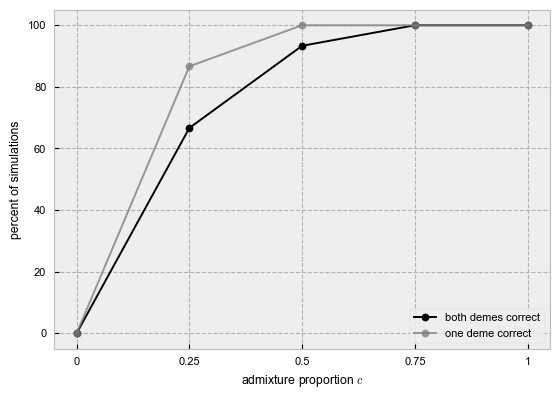

In [401]:
## include a counter for when both nodes are correctly identified and for when one node is correctly identified
# np.savetxt("/Volumes/GoogleDrive-115041122743441094352/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/llinc1edge8x10.txt",llinc)
# llinc0 = np.loadtxt("/Volumes/GoogleDrive-115041122743441094352/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/llinc0edge8x10.txt",skiprows=3)
# topedge.insert(0,'0',[(23,43)]*15)
# sns.swarmplot(data=pd.DataFrame(np.vstack((np.hstack((np.random.choice(llinc0,15).reshape(-1,1),llinc)).flatten(),[0,0.25,0.5,0.75]*15,np.ravel(topedge.apply(lambda x: x==(23,56))))).T,columns=['llinc','edge','true edge']),x='edge',y='llinc',hue='true edge',palette=['grey','k'],alpha=0.8,s=6); plt.legend(title='true edge?'); plt.xlabel(r'admixture proportion $c$'); plt.ylabel('improvement in log-lik over next best edge'); plt.grid(); plt.axhline(15,color='grey',ls='--'); 
# sns.swarmplot(data=pd.DataFrame(np.vstack((lrnidx.flatten()+1,[0.125,0.25,0.375]*15)).T,columns=['lrnidx','c',]),x='c',y='lrnidx',alpha=0.8,s=5,color='k'); plt.xlabel(r'admixture proportion $c$'); plt.ylabel('index of true edge'); plt.title('no threshsolding'); plt.grid(); plt.semilogy()
# plt.plot(lrnidx_boot.flatten()+1,lrnidx.flatten()+1,'ko'); plt.axline((0,0),slope=1,color='grey'); plt.loglog()
# get_boot_edges(gen_test_1e,sp_Graph,coord,grid,edge,obj)
# plt.plot([0,0.125,0.25,0.375,0.5],np.array([0,2/15,11/15,12/15,13/15])*100,'-o',color='grey',label='both demes correct'); plt.plot([0,0.125,0.25,0.375,0.5],np.array([0,5/15,12/15,15/15,15/15])*100,'-o',color='k',alpha=0.8,label='one deme correct'); plt.ylabel('percent of simulations'); plt.xlabel(r'admixture proportion $c$'); plt.legend()
plt.style.use('seaborn-paper')
plt.plot([0,0.25,0.5,0.75,1],np.array([0,10/15,14/15,15/15,15/15])*100,'-o',color='k',label='both demes correct'); plt.plot([0,0.25,0.5,0.75,1],np.array([0,13/15,15/15,15/15,15/15])*100,'-o',color='grey',alpha=0.8,label='one deme correct'); plt.ylabel('percent of simulations'); plt.xlabel(r'admixture proportion $c$'); plt.legend(loc='lower right'); plt.xticks([0,0.25,0.5,0.75,1],['0','0.25','0.5','0.75','1'])

In [ ]:
# topedge.sum(axis=0)
# edges_lr = deepcopy(edge)
# edges_lr = edges_lr.tolist()
# edges_lr.append([24,57]); edges_lr.append([1,57]); edges_lr.append([73,78])
# sp_Graph_lr = Joint_SpatialGraph(gen_test_1e, coord, grid, np.array(edges_lr), long_range_edges=[(23,56),(0,56),(72,77)])
# sp_Graph_lr.fit(lamb=3.,optimize_q='n-dim')
# [lle[:,ix].max()-lle[x,ix] for ix, x in enumerate(lle[:,:].T.argsort()[:,-2])]
# lle[:,:].T.argsort()[:,-1]
# (lle-np.max(lle,axis=0).T).argsort(axis=0)[-2,:]
# [sorted(i)[-2] for i in zip(*lle)] 
# np.max(lle,axis=0) - np.sort(lle, axis=0)[-2,:] 
# [te.iloc[np.argmax(lle[:,i]),i]==(23,56) for i in range(3)]
# sns.stripplot(data=pd.DataFrame(np.vstack((llinc.flatten(),[1,2,3]*10,topedge)).T,columns=['llinc','edge','true edge']),x='edge',y='llinc',hue='true edge',palette=['grey','k'],alpha=0.8); plt.legend(title='true edge?'); plt.xlabel('# of edges'); plt.ylabel('improvement in log-lik over next best edge'); plt.grid();
# plt.bar(range(4),[5,2,3,0],color='grey',alpha=0.8); plt.xticks(range(4),labels=['0/3','1/3','2/3','3/3']); plt.xlabel('# of edges b/w small demes (in each sim)'); plt.ylabel('total number (across sims)')
# np.random.choice(range(80),8,replace=False)
## just count the number of possible edges bruh...
# s2stot = 0; s2ltot = 0; l2ltot = 0
# for ii in range(80):
#     for jj in range(ii+1,80):
#         if jj in list(sp_Graph.neighbors(ii)):
#             # if neighboring nodes, do not count as potential long range edges
#             continue
#         if ((ii in smallnodes) & (jj in smallnodes)):
#             s2stot += 1
#         elif (((ii in smallnodes) & (jj not in smallnodes)) | ((ii not in smallnodes) & (jj in smallnodes))):
#             s2ltot += 1
#         else:
#             l2ltot += 1

# s2stot, s2ltot, l2ltot, len(sp_Graph.edges)
## binomial proportion test 
# ZZ = (10/25-s2ltot/2955)/np.sqrt((10/25*15/25)/25 + (s2ltot/2955*(2955-s2ltot)/2955)/2955)

### Including unobserved demes in the calculation of the likelihood 

Currently, I assume that all nodes in my grid are observed demes. But this is obviously not the case in real data. So I include a minimal working example with unobserved demes to ensure correct bookkeeping in my code. 

**NEW**: We want to be able to include unsampled demes as a potential source. 

In [398]:
# list(nx.get_node_attributes(graph, "sample_size").values())
sp_graph.q

(76,)

In [396]:
# n_rows, n_cols = 8, 10
# smallnodes = [12, 37, 45, 76]
# graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_cols, corridor_w=1.0, barrier_w=.5, barrier_prob=.3, corridor_left_prob=.8, corridor_right_prob=.6, barrier_startpt=0.5, barrier_endpt=6.5, option=2, ss=[0 if i in smallnodes else 20 for i in range(80)]) 

# gen_test_1e = simulate_genotypes_w_admixture(graph, target_n_snps=1200, n_print=1000, mu=1, long_range_nodes=[(23,56)], admixture_props=[0.5], time_of_adm=[0.000001])

# sp_graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
sp_graph.fit(lamb=3., optimize_q='n-dim')
sp_graph.fit(lamb=2.,optimize_q='n-dim',option='onlyc',long_range_edges=[(23,56)]); sp_graph.c
# get_best_lre(sp_graph,k=2)
# sp_graph.fit(lamb=3., optimize_q='n-dim', option='default'); sp_graph.fit(lamb=3., optimize_q='n-dim', option='onlyc')
# obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# print(sp_graph.lre,sp_graph.c, obj.neg_log_lik())
# sp_graph.q
# obj.Linv[:sp_graph.n_observednodes,:sp_graph.n_observed_nodes].shape

constant-w/variance fit, converged in 128 iterations, train_loss=22946.383
lambda=3.000, alpha=0.7867, converged in 8 iterations, train_loss=20638.548
lambda=2.000, alpha=0.7895, converged in 2 iterations, train_loss=20638.548


array([0.005])

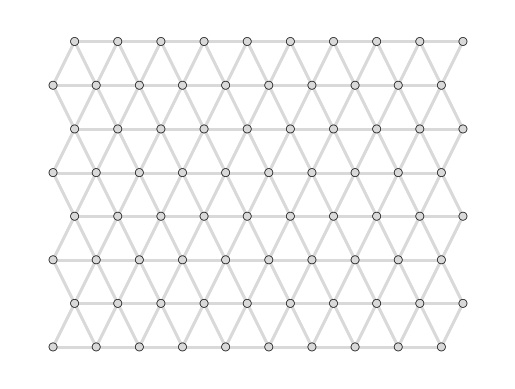

In [ ]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

## Tracking lineages that admixed $\tau$ generations ago using the migration matrix 

Here, we want to model the probability of seeing a lineage in deme $d$ in the present day, given that it was actually from from source $s$ but was the result of admixtre $\tau$ generations ago. We can use the migration matrix to evolve these rates forward in time (need to exponentiate?)

What if we have different node sizes / diversities? Include a $q$ vector in the calculation of probabilities

(matrix([[-0.66572033,  0.33111734,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.33111734, -1.32953905,  0.33197777, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.33197777, -1.3256713 , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        , ..., -1.3071122 ,
           0.32639233,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.32639233,
          -1.30770227,  0.32647754],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.32647754, -0.65519033]]),
 array([[-0.002,  0.001,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.001, -0.004,  0.001, ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.001, -0.004, ...,  0.   ,  0.   ,  0.   ],
        ...,
        [ 0.   ,  0.   ,  0.   , ..., -0.004,  0.001,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.001, -0.004,  0.001],
        [ 0.   ,  0.   ,  0.   ,

[]

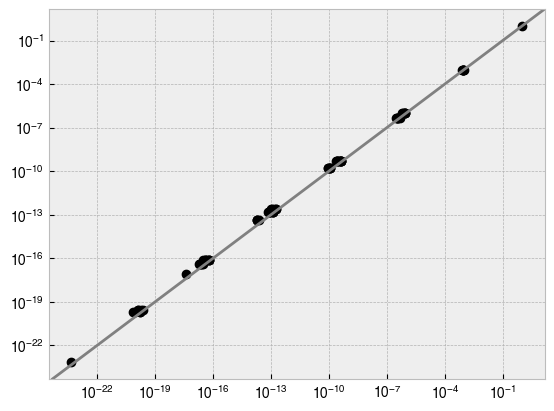

In [305]:
## assuming a 2d grid of 80 demes with an admixture from 12 to 66 2 generations ago (constant migration rate)...
# migmat = deepcopy(sp_graph.W.todense()); #migmat[sp_graph.W.todense()>0] = 1
# np.fill_diagonal(migmat, -np.ravel(migmat @ np.ones(80).reshape(-1,1)))
# migmat2 = np.array(nx.adjacency_matrix(graph_def, weight="w").toarray().tolist())
# np.fill_diagonal(migmat2, -np.ravel(migmat2 @ np.ones(80).reshape(-1,1)))
# plt.plot(sp_graph.W.todense()[:,66]/sp_graph.W.todense()[:,66].sum()); plt.xlabel('deme ID'); plt.axvline(66,color='grey',linestyle='--'); plt.axvline(12,color='grey',linestyle='--'); plt.title(r'$\tau=0$');
# plt.plot(migmat[:,12]/migmat[:,12].sum()); plt.xlabel('deme ID'); plt.title(r'$\tau=0$'); plt.axvline(66,color='grey',linestyle='--'); plt.axvline(12,color='grey',linestyle='--');
onehot = np.zeros(80); onehot[45] = 1
# probmat = sp.linalg.expm(migmat*15) # or sp.linalg.expm(-migmat*tau) @ np.diag(1/sp_graph.q) @ sp.linalg.expm(-migmat*tau) from Al-asadi et al 2019
# prod = np.ravel(onehot @ probmat)
probmat = sp.linalg.expm(migmat*0.0025); prod2 = np.ravel(onehot @ probmat)
probmat = sp.linalg.expm(migmat2*1); prod3 = np.ravel(onehot @ probmat)
# plt.plot(prod2, label=r'$\tau=3$ with $\hat w$ from FEEMS'); plt.plot(prod3, label=r'$\tau=0.8$ with $\hat w$ from FEEMS'); plt.axvline(56,color='k')
plt.plot(prod2,prod3,'ko'); plt.axline((0,0),slope=1,color='grey'); plt.loglog()
# plt.plot(prod3, label=r'$\tau=3$ with $m=10^{-3}$ from msprime'); plt.legend(); plt.ylabel('probability'); plt.xlabel('deme ID'); plt.semilogy()

In [1170]:
0.02/np.mean(np.diag(-obj.Linv-0.5*np.diag(1/sp_graph.q))), 100/15000

(-0.01678799587256793, 0.006666666666666667)

In [1159]:
1/sp_graph.q

array([5.98195702e-05, 6.37693829e-05, 6.13670555e-05, 5.60130410e-05,
       5.28171815e-05, 5.79705012e-05, 6.18799906e-05, 6.24196664e-05,
       6.48610806e-05, 7.09183648e-05, 6.27253804e-05, 6.29909344e-05,
       6.06137278e-05, 5.99291892e-05, 6.28880292e-05, 6.55586086e-05,
       6.57938962e-05, 6.39038567e-05, 6.99796282e-05, 7.30621953e-05,
       6.22444504e-05, 6.37969789e-05, 6.11187916e-05, 6.15251486e-05,
       6.72587112e-05, 7.26580164e-05, 6.94652901e-05, 6.30998205e-05,
       6.17626089e-05, 7.08004340e-05, 6.62157200e-05, 6.38520074e-05,
       6.72104721e-05, 7.25275330e-05, 7.47973088e-05, 7.27903241e-05,
       7.02417981e-05, 6.70135835e-05, 7.02504544e-05, 7.62140737e-05,
       7.00102077e-05, 6.81733045e-05, 6.75156445e-05, 6.81644555e-05,
       7.30220775e-05, 7.53439605e-05, 7.55420457e-05, 6.79001574e-05,
       6.85708270e-05, 7.30351487e-05, 6.70096396e-05, 6.82054858e-05,
       7.15580510e-05, 7.23330220e-05, 7.40761706e-05, 7.20221943e-05,
      

/var/folders/vc/r8504j4j0ds4cvn52fqczvzh0000gr/T/ipykernel_24476/2993223941.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=prod.max()), cmap=mpl.cm.Greys), orientation='horizontal', label='prob.'); plt.title(r'$\tau={}$'.format(tau))


Text(0.5, 1.0, '$\\tau=5000$')

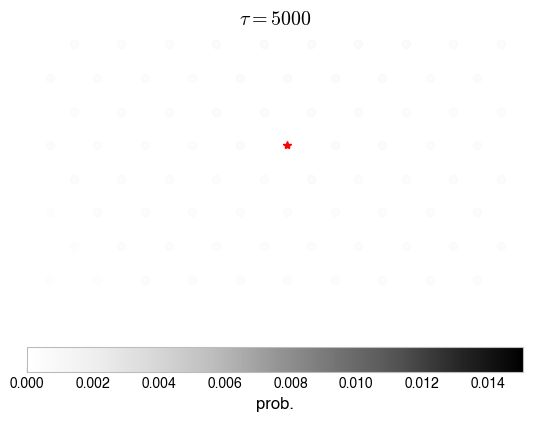

In [199]:
# ## plotting the grid and seeing where lineages end up
tau = 5000
probmat = sp.linalg.expm(migmat*tau) # or sp.linalg.expm(-migmat*tau) @ np.diag(1/sp_graph.q) @ sp.linalg.expm(-migmat*tau) from Al-asadi et al 2019
prod = np.ravel(onehot @ probmat)
for i in range(80):
    plt.plot(grid_def[i,0],grid_def[i,1],'o',color='k',alpha=prod[i]); 
plt.box(False); plt.tick_params(left = False, labelleft = False, labelbottom = False, bottom = False); plt.grid(); plt.plot(grid_def[45,0],grid_def[45,1],'r*')
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=prod.max()), cmap=mpl.cm.Greys), orientation='horizontal', label='prob.'); plt.title(r'$\tau={}$'.format(tau))

### Checking for variability in different FEEMS fits

Run over a baseline 8x10 grid with no admixture edges & grid with one admixture edge ($c=0.5$).  
Measure edge weights, long range edge detection, log-lik, genetic vs fitted distance, with & without penalty (?).  

1. vanilla FEEMS (constant variance)   
    - nll = -46884 with $\lambda_{CV} = 36$
    - nll = -47455 with $\lambda=3$ (log-lik increases with decreasing $\lambda$, but penalty decreases with increasing $\lambda$)
    - $\mu_w$ = 1.7, $\sigma_w$ = 0.14 & $\mu_w$ = 1.73, $\sigma_w$ = 0.37 (respectively)
    - $q$ = 11.2 (stays the same with different $\lambda$)
2. joint FEEMS (None)
    - same behavior as vanilla FEEMS (similar estimates for similar parameters)
3. joint FEEMS ('1-dim')
    - small difference b/w None and '1-dim': weights stay the same, slight change in q & log-lik
4. joint FEEMS ('n-dim')  
    a. setting $\lambda_q$ & $\alpha_q$  
    b. searching over $\lambda_q$ & $\alpha_q$ 

In [610]:
# n_rows, n_columns = 8, 10
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1., barrier_w=1, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=20)
# gen_test_80 = simulate_genotypes(graph_def, target_n_snps=1500, n_print=1000, mu=1)

# tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)

# sp_graph = FEEMSmix_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=.3); obj = Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# np.mean(sp_graph.w), np.std(sp_graph.w)
# fit_cov, _, emp_cov = comp_mats(obj); fit_dist = cov_to_dist(fit_cov)[tril_idx]; emp_dist = cov_to_dist(emp_cov)[tril_idx]
# print(obj.neg_log_lik(), np.mean(sp_graph.w), np.std(sp_graph.w), sp.stats.linregress(fit_dist, emp_dist)[2]**2)
# sp_graph.q
# lamb_grid = np.geomspace(1e-2, 1e2, 10)[::-1]
# cv_err = run_cv(sp_graph, lamb_grid, n_folds=10, factr=1e10)
# mean_cv_err = np.mean(cv_err, axis=0)
# print(float(lamb_grid[np.argmin(mean_cv_err)]))

# sp_graph_jt = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def)
# sp_graph_jt.fit(lamb=3., optimize_q=None); obj_jt = Joint_Objective(sp_graph_jt); obj_jt.inv(); 
# fit_cov, _, emp_cov = comp_mats(obj_jt); fit_dist = cov_to_dist(fit_cov)[tril_idx]; emp_dist = cov_to_dist(emp_cov)[tril_idx]
# print(obj_jt.neg_log_lik(), np.mean(sp_graph.w), np.std(sp_graph.w), sp.stats.linregress(fit_dist, emp_dist)[2]**2, sp_graph_jt.q)

# sp_graph_jt.fit(lamb=3., optimize_q='1-dim', lamb_q=0., alpha_q=0.); obj_jt = Joint_Objective(sp_graph_jt); obj_jt.inv(); 
# fit_cov, _, emp_cov = comp_mats(obj_jt); fit_dist = cov_to_dist(fit_cov)[tril_idx]; emp_dist = cov_to_dist(emp_cov)[tril_idx]
# print(obj_jt.neg_log_lik(), np.mean(sp_graph.w), np.std(sp_graph.w), sp.stats.linregress(fit_dist, emp_dist)[2]**2, sp_graph_jt.q)

## try it for with both LRE & base graph
# regpath = pd.DataFrame({'lambq':np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2)[:,0], 'alphq':np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2)[:,1],'loglik':np.zeros(36),'loss':np.zeros(36),'muw':np.zeros(36),'sigw':np.zeros(36),'R2':np.zeros(36),'muq':np.zeros(36),'sigq':np.zeros(36)})
# for i in range(regpath.shape[0]):    
#     sp_graph_jt.fit(lamb=3., optimize_q='n-dim', lamb_q=regpath['lambq'].iloc[i], alpha_q=regpath['alphq'].iloc[i]); 
#     obj_jt = Joint_Objective(sp_graph_jt); obj_jt.inv(); 
#     fit_cov, _, emp_cov = comp_mats(obj_jt); fit_dist = cov_to_dist(fit_cov)[tril_idx]; emp_dist = cov_to_dist(emp_cov)[tril_idx]
#     regpath['loglik'].iloc[i] = -obj_jt.neg_log_lik(); regpath['muw'].iloc[i] = np.mean(sp_graph_jt.w); regpath['sigw'].iloc[i] = np.std(sp_graph_jt.w)
#     regpath['R2'].iloc[i] = sp.stats.linregress(fit_dist, emp_dist)[2]**2; regpath['muq'].iloc[i] = np.mean(sp_graph_jt.q); regpath['sigq'].iloc[i] = np.std(sp_graph_jt.q)
#     print('{}...'.format(i))

# cvq_err = run_cvq(sp_graph_jt, lamb_cv=10., lamb_q_grid=lamb_grid, alpha_q_grid=lamb_grid, factr=1e6)
# lamb_grid[np.argmin(np.mean(cvq_err,axis=(0,2)))], lamb_grid[np.argmin(np.mean(cvq_err,axis=(0,1)))]

# fig = plt.figure(dpi=110)
# ax = fig.add_subplot(1, 1, 1)
# sp_graph_jt.fit(lamb=3., optimize_q='n-dim', lamb_q=1., alpha_q=1.)
# v = Viz(ax, sp_graph_jt, projection=ccrs.Mercator(), edge_width=2, #weights=w,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True)
# v.draw_obs_nodes(use_ids=False)
# # get_best_lre(sp_graph, gen_test_128_adm, coord_def, grid_def, edge_def, k=2, top=10)
# v.draw_edge_colorbar()

0.15263395341521946

In [ ]:
# np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2).shape
# regpath.iloc[0,2:8]
# plt.plot(regpath['R2'],'k-o'); plt.xticks(ticks=range(36),labels=[str(round(x[0],2))+','+str(round(x[1],2)) for x in np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2)],rotation=45); plt.ylabel('log-lik'); plt.xlabel(r'$\lambda_q, \alpha_q$')
# plt.plot(regpath['muw'],'ko'); plt.errorbar(range(36),regpath['muw'],regpath['sigw'],color='k'); plt.xticks(ticks=range(36),labels=[str(round(x[0],2))+','+str(round(x[1],2)) for x in np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2)],rotation=45); plt.ylabel(r'$\hat w$'); plt.xlabel(r'$\lambda_q, \alpha_q$')
# plt.plot(regpath['muq'],'ko'); plt.errorbar(range(36),regpath['muq'],regpath['sigq'],color='k'); plt.xticks(ticks=range(36),labels=[str(round(x[0],2))+','+str(round(x[1],2)) for x in np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2)],rotation=45); plt.ylabel(r'$\hat q$'); plt.xlabel(r'$\lambda_q, \alpha_q$')

## From msprime documentation: 

Simulating many replicates to get an expectation on the pairwise deme coalescent rates in the presence of an admixture event $\tau$ generatiosn ago with $c$ strength to test the formulae we've calculated

As described in the Definitions section, continuous migration between populations is modelled by a matrix of rates, so that $M[j, k]$ is the rate at which lineages move from population $j$ to population $k$ in the coalescent process, that is, backwards in time (see the Direction of time section for more details). Lineages that move from population $j$ to $k$ backwards in time actually correspond to individuals migrating from population $k$ to $j$ forwards in time.

In [1721]:
# n_rows, n_columns = 6, 6
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=0.001, barrier_w=0.001, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=3, barrier_endpt=7, n_samples_per_node=6)

# gen_test_36_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=400, mu=1, long_range_nodes=[(8,27)], admixture_props=[0.000], time_of_adm=[0.6], Ne=1000)

# os.chdir("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/")
# for r in range(16):
#     gen_test_1e = simulate_genotypes_w_admixture(graph_def, target_n_snps=500, n_print=400, mu=1, long_range_nodes=[(23,56)], admixture_props=[0.5], time_of_adm=[1], replic=r)

# sp_graph = FEEMSmix_SpatialGraph(gen_test_36_adm,coord_def,grid_def,edge_def)
%time sp_graph.fit(lamb=300., optimize_q='n-dim'); #obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
sp_graph.q

constant-w/variance fit, converged in 134 iterations, train_loss=76902.545
lambda=300.000, alpha=6.8929, converged in 29 iterations, train_loss=76834.814
CPU times: user 330 ms, sys: 55.6 ms, total: 386 ms
Wall time: 449 ms


array([0.85056822, 0.82243583, 0.80768539, 0.77915159, 0.81267186,
       0.8112842 , 0.80688365, 0.77449171, 0.75677594, 0.75526957,
       0.79117734, 0.80943879, 0.82290497, 0.78905807, 0.76128168,
       0.72732162, 0.75043695, 0.76082588, 0.80616018, 0.7773556 ,
       0.73828831, 0.73085755, 0.73286923, 0.74957131, 0.83995796,
       0.79372911, 0.75555493, 0.73394934, 0.71642203, 0.73001601,
       0.79979794, 0.77806387, 0.76132383, 0.73813923, 0.72805936,
       0.72774081])

In [ ]:
# def comp_fst_mat(genotypes, n_inds, n_demes):
#     """Computes an Fst distance matrix from a sample
#     genotype matrix and set of sub-population ids
#     """
#     n_snps = genotypes.shape[1]
#     acs = np.empty((n_demes, n_snps, 2))
    
#     # compute allele counts
#     for i in range(n_demes):
#         Gi = genotypes[np.arange(i*n_inds,(i+1)*n_inds), :]
#         acs[i, :, 0] = np.sum(Gi, axis=0)
#         acs[i, :, 1] = (2 * Gi.shape[0]) - np.sum(Gi, axis=0) 
    
#     # compute Fst matrix
#     Fst = np.empty((n_demes, n_demes))
#     for i in range(n_demes):
#         for j in range(n_demes):
#             Fst[i, j] = np.sum(allel.mean_pairwise_difference_between(acs[i, :, :].astype(np.int32), acs[j, :, :].astype(np.int32)))/n_snps

#     for i in range(n_demes):
#         Fst[i, i] = np.sum(allel.mean_pairwise_difference(acs[i, :, :].astype(np.int32)))/n_snps
#     return(Fst)

# Fst = comp_fst_mat(gen_test_80_adm,20,80)
# plt.hist(np.ravel(Fst))
# plt.imshow(Fst,cmap='RdBu_r'); plt.colorbar()

In [ ]:
# def avg_coal_time(tree):
#     coalescence_time = 0
#     sample_size = tree.get_sample_size()
#     for leaves in tree.samples():
#         num_branch = 0
#         u = leaves
#         visited = np.array([u])
#         while u != tskit.NULL:
#             u = tree.parent(u)
#             if u !=-1 :
#                 node_children = np.array(tree.children(u))
#                     #print("{}:{}".format(u, node_children))                                                                                               
#                 node_interest = np.setdiff1d(node_children, visited)
#                 if len(node_interest)!=0:
#                     for j in range(len(node_interest)):
#                         num_leaves = tree.get_num_leaves(node_interest[j])
#                         node_branch_len = tree.time(u) * num_leaves
#                         coalescence_time = coalescence_time + node_branch_len
#                         visited = np.append(visited, u)
#                         num_branch =+ num_leaves

#         #print("leaves{}:{},{}".format(leaves, num_branch, visited))                                                                                       
#     return(coalescence_time/(sample_size * (sample_size-1)))

In [133]:
# import tskit
## 8x10, Ne=1000, m=1e-3, n_samples_per_node=10, n_snps=500: tree{j}_8x10_c0_t0.tree
# mytree = []
# for j in np.arange(500):
#     mytree.append(tskit.load(f"/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/trees/tree{j}_8x10_c0_t0.tree"))

In [1596]:
## reading in trees from SLiM (https://github.com/petrelharp/isolation_by_coalescence)
# origts = tskit.load("/Users/vivaswat/feems/docs/notebooks/results/slimtrees/pop_10000.trees")
# origtree = []
# for t in origts.trees():
#     origtree.append(t)

## how to compute just the diagonal elements of the coalescence time matrix?
dcoaltime = np.zeros(ndemes)
for snp in range(nsnps):
    tt = mytree[snp].first()
    for i in range(ninds*ndemes):
        for j in range(i+1,ninds*ndemes):
            if int(i/ninds) == int(j/ninds):
                dcoaltime[int(i/ninds)] += tt.tmrca(i,j)
            else:
                continue
dcoaltime /= np.sum(range(ninds))*ninds**2

# ndemes = 80; ninds = 2*10; nsnps = 500
# coaltimemat = np.zeros((ndemes,ndemes))
# for snp in range(nsnps):
#     tt = mytree[snp].first()
#     for i in range(ninds*ndemes):
#         for j in range(i+1,ninds*ndemes):
#             coaltimemat[int(i/ninds),int(j/ninds)] += tt.tmrca(i,j)

# coaltimemat[np.diag_indices_from(coaltimemat)] /= np.sum(range(ninds))
# coaltimemat[np.triu_indices_from(coaltimemat,1)] /= ninds*ninds

# coaltimemat = coaltimemat + coaltimemat.T
# coaltimemat[np.diag_indices_from(coaltimemat)] *= 0.5
# coaltimemat /= nsnps

# ndemes = 36; ninds = 2*6; nsnps = 1000
# coaltimemat36 = np.zeros((ndemes,ndemes))
# for snp in range(nsnps):
#     tt = mytree[snp].first()
#     for i in range(ninds*ndemes):
#         for j in range(i+1,ninds*ndemes):
#             coaltimemat36[int(i/ninds),int(j/ninds)] += tt.tmrca(i,j)

# coaltimemat36[np.diag_indices_from(coaltimemat36)] /= np.sum(range(ninds))
# coaltimemat36[np.triu_indices_from(coaltimemat36,1)] /= ninds*ninds

# coaltimemat36 = coaltimemat36 + coaltimemat36.T
# coaltimemat36[np.diag_indices_from(coaltimemat36)] *= 0.5
# coaltimemat36 /= nsnps

# for rep in range(3,16):
#     mytree = []
#     for j in np.arange(500):
#         mytree.append(tskit.load(f"feemsResults/trees/mytreewadms{j}_rep{rep}_tau1_c0.5.tree"))

#     print(f"Working on rep {rep}...")
#     coaltimemat = np.zeros((ndemes,ndemes))
#     for snp in range(nsnps):
#         tt = mytree[snp].first()
#         for i in range(ninds*ndemes):
#             for j in range(i+1,ninds*ndemes):
#                 coaltimemat[int(i/ninds),int(j/ninds)] += tt.tmrca(i,j)
    
#     coaltimemat[np.diag_indices_from(coaltimemat)] /= np.sum(range(ninds))
#     coaltimemat[np.triu_indices_from(coaltimemat,1)] /= ninds*ninds
#     coaltimemat = coaltimemat + coaltimemat.T
#     coaltimemat[np.diag_indices_from(coaltimemat)] *= 0.5
#     coaltimemat /= nsnps
#     np.savetxt(f"feemsResults/trees/coaltimemat{rep}t1c0.5.txt",coaltimemat)

# coaltimemattot = np.zeros((16,80,80))
# for rep in range(16):
#     coaltimemattot[rep,:,:] = np.loadtxt(f"feemsResults/trees/coaltimemat{rep}t1c0.5.txt")
# coaltimemat = np.mean(coaltimemattot,axis=0)
# coaltimemat = np.loadtxt(f"/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/trees/coaltimemat1t1c0.5.txt")